<a href="https://colab.research.google.com/github/sjquill/MSc_diss/blob/main/BREAST_Data/Breast_DeepHit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 2.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=7d4121447bd41c2eb9e0b54427a80d919d292886bf3414b2f681b5fcfd504c30
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/

In [ ]:
import pickle
import lifelines
import numpy as np
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

import torch
import torchtuples as tt


In [ ]:
import pandas as pd

breast_train_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_train_data_imputed1.csv")
breast_test_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_test_data_imputed1.csv")
train_data = breast_train_data_imputed1.copy()
test_data = breast_test_data_imputed1.copy()

In [ ]:
column_names = [
    'mask_id',
    'disease_free_survival_status',
    'disease_free_survival_months',
    'race_asian',
    'race_black',
    'race_other',
    'Treatment_CA_6',
    'Treatment_T_4',
    'Treatment_T_6',
    'post_menopausal',
    'tumor_side_right',
    'tumor_side_bilateral',
    'receptor_status_er_pos',
    'receptor_status_pgrn_pos',
    'histologic_grade_inter',
    'histologic_grade_high',
    'her2_status_pos',
    'prior_hormonal_therapy_yes',
    'most_extensive_primary_surgery_mast_NOS',
    'tumor_size_2_to_5cm',
    'tumor_size_over_5cm',
    'num_pos_nodes_1',
    'num_pos_nodes_2+',
    'age_over_fifty'
]
# Set the new column names
train_data.columns = column_names
test_data.columns = column_names

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(
    train_data, test_size=0.2, stratify=train_data['disease_free_survival_status'], random_state=42
)


In [ ]:
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 2000
Validation set size: 500
Test set size: 624


In [ ]:
train_data = train_data.drop(columns=['mask_id'])
val_data = val_data.drop(columns=['mask_id'])
test_data = test_data.drop(columns=['mask_id'])

x_train = train_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months'])
x_val = val_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months'])
x_test = test_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months'])

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test= x_test.astype('float32')

x_train = x_train.values
print(type(x_train))

x_test = x_test.values
print(type(x_test))

x_val = x_val.values
print(type(x_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [ ]:
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['disease_free_survival_months'].values, df['disease_free_survival_status'].values)
y_train = labtrans.fit_transform(*get_target(train_data))
y_val = labtrans.transform(*get_target(val_data))

train = (x_train, y_train)
val = (x_val, y_val)

durations_train, events_train = get_target(train_data)
durations_val, events_val = get_target(val_data)
durations_test, events_test = get_target(test_data)

In [ ]:
best_val_ci = 0
best_hyperparameters = None
RS_ITERATION = 100
in_features = x_train.shape[1]
get_target = lambda df: (df['disease_free_survival_months'].values, df['disease_free_survival_status'].values)
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
y_train = labtrans.fit_transform(*get_target(train_data))
y_val = labtrans.transform(*get_target(val_data))
out_features = labtrans.out_features
batch_norm = True
batch_size = 256
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]

In [ ]:

from lifelines.utils import concordance_index
def get_random_hyperparameters():
    SET_BATCH_SIZE = [32, 64, 128, 256]
    SET_LAYERS = [1,2,3,5]
    SET_NODES = [25, 50, 75, 100]
    SET_ACTIVATION_FN = ['relu', 'elu', 'tanh']
    SET_ALPHA = [0.1, 0.5, 1.0]
    SET_SIGMA = [0.1, 0.5, 1.0]
    SET_LR = [0.001, 0.01, 0.1]
    SET_DROPOUT = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    SET_PATIENCE = [25, 50, 75]

    return {
        'batch_size': SET_BATCH_SIZE[np.random.randint(len(SET_BATCH_SIZE))],
        'layers': SET_LAYERS[np.random.randint(len(SET_LAYERS))],
        'nodes': SET_NODES[np.random.randint(len(SET_NODES))],
        'activation_fn': SET_ACTIVATION_FN[np.random.randint(len(SET_ACTIVATION_FN))],
        'alpha': SET_ALPHA[np.random.randint(len(SET_ALPHA))],
        'sigma': SET_SIGMA[np.random.randint(len(SET_SIGMA))],
        'lr': SET_LR[np.random.randint(len(SET_LR))],
        'dropout': SET_DROPOUT[np.random.randint(len(SET_DROPOUT))],
        'patience': SET_PATIENCE[np.random.randint(len(SET_PATIENCE))],
    }


# Main loop
max_valid = 0.0
best_model = None
best_hyperparameters = None

for r_itr in range(RS_ITERATION):
    print(f'Random search... itr: {r_itr}')
    hyperparameters = get_random_hyperparameters()
    print(hyperparameters)

    # Use chosen hyperparameters
    num_nodes = [hyperparameters['nodes']] * hyperparameters['layers']
    batch_norm = True if hyperparameters['activation_fn'] == 'relu' else False
    dropout = hyperparameters['dropout']

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    model = DeepHitSingle(net, tt.optim.Adam, alpha=hyperparameters['alpha'], sigma=hyperparameters['sigma'], duration_index=labtrans.cuts)

    batch_size = hyperparameters['batch_size']
    model.optimizer.set_lr(hyperparameters['lr'])

    epochs = 100
    callbacks = [tt.callbacks.EarlyStopping(patience=hyperparameters['patience'])]
    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

    # Validate the model
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
    c_index = ev.concordance_td('antolini')

    # If this model is better, save it
    if c_index > max_valid:
        max_valid = c_index
        best_model = model
        best_hyperparameters = hyperparameters

    print(f'Current best c-index: {max_valid}')

print(f'Best hyperparameters: {best_hyperparameters}')



Random search... itr: 0
{'batch_size': 256, 'layers': 2, 'nodes': 75, 'activation_fn': 'elu', 'alpha': 1.0, 'sigma': 0.1, 'lr': 0.1, 'dropout': 0.8, 'patience': 25}
0:	[0s / 0s],		train_loss: 1.0143,	val_loss: 0.5803
1:	[0s / 0s],		train_loss: 0.7177,	val_loss: 0.4894
2:	[0s / 0s],		train_loss: 0.5868,	val_loss: 0.4911
3:	[0s / 0s],		train_loss: 0.5443,	val_loss: 0.4966
4:	[0s / 0s],		train_loss: 0.5207,	val_loss: 0.4935
5:	[0s / 0s],		train_loss: 0.5286,	val_loss: 0.4892
6:	[0s / 0s],		train_loss: 0.5097,	val_loss: 0.4884
7:	[0s / 0s],		train_loss: 0.5157,	val_loss: 0.4901
8:	[0s / 0s],		train_loss: 0.5083,	val_loss: 0.4878
9:	[0s / 0s],		train_loss: 0.5100,	val_loss: 0.4861
10:	[0s / 0s],		train_loss: 0.5090,	val_loss: 0.4865
11:	[0s / 0s],		train_loss: 0.5066,	val_loss: 0.4870
12:	[0s / 0s],		train_loss: 0.5047,	val_loss: 0.4862
13:	[0s / 0s],		train_loss: 0.5036,	val_loss: 0.4861
14:	[0s / 0s],		train_loss: 0.5043,	val_loss: 0.4858
15:	[0s / 0s],		train_loss: 0.5044,	val_loss: 0.48

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.0010208248264597796
Random search... itr: 1
{'batch_size': 32, 'layers': 5, 'nodes': 75, 'activation_fn': 'tanh', 'alpha': 1.0, 'sigma': 1.0, 'lr': 0.01, 'dropout': 0.05, 'patience': 75}
0:	[0s / 0s],		train_loss: 0.5648,	val_loss: 0.5047
1:	[0s / 0s],		train_loss: 0.5312,	val_loss: 0.5112
2:	[0s / 0s],		train_loss: 0.5149,	val_loss: 0.4828
3:	[0s / 0s],		train_loss: 0.5134,	val_loss: 0.5109
4:	[0s / 0s],		train_loss: 0.5008,	val_loss: 0.4856
5:	[0s / 0s],		train_loss: 0.4998,	val_loss: 0.5131
6:	[0s / 1s],		train_loss: 0.4926,	val_loss: 0.5042
7:	[0s / 1s],		train_loss: 0.4834,	val_loss: 0.5533
8:	[0s / 1s],		train_loss: 0.4878,	val_loss: 0.5282
9:	[0s / 1s],		train_loss: 0.4736,	val_loss: 0.5490
10:	[0s / 1s],		train_loss: 0.4707,	val_loss: 0.5741
11:	[0s / 1s],		train_loss: 0.4633,	val_loss: 0.5451
12:	[0s / 2s],		train_loss: 0.4644,	val_loss: 0.6573
13:	[0s / 2s],		train_loss: 0.4561,	val_loss: 0.6141
14:	[0s / 2s],		train_loss: 0.4505,	val_loss: 0.6807
15:	

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6117,	val_loss: 0.4979
1:	[0s / 0s],		train_loss: 0.5571,	val_loss: 0.5126
2:	[0s / 0s],		train_loss: 0.5251,	val_loss: 0.4880
3:	[0s / 0s],		train_loss: 0.5247,	val_loss: 0.5016
4:	[0s / 0s],		train_loss: 0.5049,	val_loss: 0.4914
5:	[0s / 0s],		train_loss: 0.5097,	val_loss: 0.4874
6:	[0s / 0s],		train_loss: 0.5065,	val_loss: 0.4922
7:	[0s / 1s],		train_loss: 0.4921,	val_loss: 0.4784
8:	[0s / 1s],		train_loss: 0.4903,	val_loss: 0.4803
9:	[0s / 1s],		train_loss: 0.4893,	val_loss: 0.4891
10:	[0s / 1s],		train_loss: 0.4958,	val_loss: 0.4891
11:	[0s / 1s],		train_loss: 0.4897,	val_loss: 0.4903
12:	[0s / 1s],		train_loss: 0.4832,	val_loss: 0.4932
13:	[0s / 1s],		train_loss: 0.4825,	val_loss: 0.4952
14:	[0s / 1s],		train_loss: 0.4860,	val_loss: 0.5147
15:	[0s / 2s],		train_loss: 0.4775,	val_loss: 0.5331
16:	[0s / 2s],		train_loss: 0.4754,	val_loss: 0.5066
17:	[0s / 2s],		train_loss: 0.4687,	val_loss: 0.5260
18:	[0s / 2s],		train_loss: 0.4757,	val_loss: 0.5220
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 0.3134,	val_loss: 0.2767
4:	[0s / 0s],		train_loss: 0.3128,	val_loss: 0.2776
5:	[0s / 0s],		train_loss: 0.2980,	val_loss: 0.2814
6:	[0s / 0s],		train_loss: 0.3025,	val_loss: 0.2785
7:	[0s / 0s],		train_loss: 0.2906,	val_loss: 0.2782
8:	[0s / 0s],		train_loss: 0.2900,	val_loss: 0.2786
9:	[0s / 0s],		train_loss: 0.2861,	val_loss: 0.2788
10:	[0s / 0s],		train_loss: 0.2872,	val_loss: 0.2782
11:	[0s / 0s],		train_loss: 0.2878,	val_loss: 0.2776
12:	[0s / 1s],		train_loss: 0.2819,	val_loss: 0.2785
13:	[0s / 1s],		train_loss: 0.2852,	val_loss: 0.2786
14:	[0s / 1s],		train_loss: 0.2815,	val_loss: 0.2789
15:	[0s / 1s],		train_loss: 0.2795,	val_loss: 0.2791
16:	[0s / 1s],		train_loss: 0.2822,	val_loss: 0.2797
17:	[0s / 1s],		train_loss: 0.2731,	val_loss: 0.2818
18:	[0s / 1s],		train_loss: 0.2762,	val_loss: 0.2825
19:	[0s / 1s],		train_loss: 0.2691,	val_loss: 0.2829
20:	[0s / 1s],		train_loss: 0.2741,	val_loss: 0.2810
21:	[0s / 2s],		train_loss: 0.2753,	val_loss: 0.2825


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 30.9613,	val_loss: 2.4534
1:	[0s / 0s],		train_loss: 14.0938,	val_loss: 0.7293
2:	[0s / 0s],		train_loss: 4.4797,	val_loss: 0.5938
3:	[0s / 0s],		train_loss: 3.8208,	val_loss: 0.4883
4:	[0s / 0s],		train_loss: 1.2128,	val_loss: 0.4834
5:	[0s / 0s],		train_loss: 0.7362,	val_loss: 0.4839
6:	[0s / 0s],		train_loss: 1.1424,	val_loss: 0.4887
7:	[0s / 0s],		train_loss: 0.7041,	val_loss: 0.4830
8:	[0s / 0s],		train_loss: 8.6283,	val_loss: 0.4873
9:	[0s / 0s],		train_loss: 0.5554,	val_loss: 0.4874
10:	[0s / 1s],		train_loss: 0.5268,	val_loss: 0.4838
11:	[0s / 1s],		train_loss: 0.5008,	val_loss: 0.4872
12:	[0s / 1s],		train_loss: 0.8873,	val_loss: 0.4877
13:	[0s / 1s],		train_loss: 0.5298,	val_loss: 0.4888
14:	[0s / 1s],		train_loss: 1.5078,	val_loss: 0.4913
15:	[0s / 1s],		train_loss: 0.9197,	val_loss: 0.4893
16:	[0s / 1s],		train_loss: 0.5218,	val_loss: 0.4882
17:	[0s / 1s],		train_loss: 0.5118,	val_loss: 0.4859
18:	[0s / 1s],		train_loss: 0.5525,	val_loss: 0.4833
1

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.4785,	val_loss: 0.4412
1:	[0s / 0s],		train_loss: 0.3488,	val_loss: 0.2976
2:	[0s / 0s],		train_loss: 0.3064,	val_loss: 0.2977
3:	[0s / 0s],		train_loss: 0.2954,	val_loss: 0.2895
4:	[0s / 0s],		train_loss: 0.2883,	val_loss: 0.2931
5:	[0s / 0s],		train_loss: 0.2908,	val_loss: 0.2909
6:	[0s / 0s],		train_loss: 0.2824,	val_loss: 0.2983
7:	[0s / 0s],		train_loss: 0.2851,	val_loss: 0.2959
8:	[0s / 0s],		train_loss: 0.2801,	val_loss: 0.2959
9:	[0s / 0s],		train_loss: 0.2817,	val_loss: 0.2930
10:	[0s / 0s],		train_loss: 0.2762,	val_loss: 0.3034
11:	[0s / 0s],		train_loss: 0.2752,	val_loss: 0.3065
12:	[0s / 0s],		train_loss: 0.2829,	val_loss: 0.2999
13:	[0s / 0s],		train_loss: 0.2730,	val_loss: 0.2955
14:	[0s / 0s],		train_loss: 0.2632,	val_loss: 0.2949
15:	[0s / 0s],		train_loss: 0.2709,	val_loss: 0.3106
16:	[0s / 0s],		train_loss: 0.2642,	val_loss: 0.3018
17:	[0s / 0s],		train_loss: 0.2702,	val_loss: 0.3197
18:	[0s / 0s],		train_loss: 0.2690,	val_loss: 0.3246
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.7078,	val_loss: 0.5735
1:	[0s / 0s],		train_loss: 0.6640,	val_loss: 0.5597
2:	[0s / 0s],		train_loss: 0.5855,	val_loss: 0.5243
3:	[0s / 0s],		train_loss: 0.5445,	val_loss: 0.4864
4:	[0s / 0s],		train_loss: 0.5284,	val_loss: 0.5043
5:	[0s / 0s],		train_loss: 0.5276,	val_loss: 0.4866
6:	[0s / 1s],		train_loss: 0.5181,	val_loss: 0.4876
7:	[0s / 1s],		train_loss: 0.5209,	val_loss: 0.4840
8:	[0s / 1s],		train_loss: 0.5161,	val_loss: 0.4855
9:	[0s / 1s],		train_loss: 0.5146,	val_loss: 0.4851
10:	[0s / 1s],		train_loss: 0.5108,	val_loss: 0.4930
11:	[0s / 1s],		train_loss: 0.5084,	val_loss: 0.4842
12:	[0s / 2s],		train_loss: 0.5202,	val_loss: 0.4832
13:	[0s / 2s],		train_loss: 0.5116,	val_loss: 0.4855
14:	[0s / 2s],		train_loss: 0.5123,	val_loss: 0.4895
15:	[0s / 2s],		train_loss: 0.5181,	val_loss: 0.4877
16:	[0s / 2s],		train_loss: 0.5122,	val_loss: 0.4863
17:	[0s / 2s],		train_loss: 0.5154,	val_loss: 0.4886
18:	[0s / 3s],		train_loss: 0.5117,	val_loss: 0.4837
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1455,	val_loss: 0.1192
1:	[0s / 0s],		train_loss: 0.1209,	val_loss: 0.1133
2:	[0s / 0s],		train_loss: 0.1147,	val_loss: 0.1127
3:	[0s / 0s],		train_loss: 0.1084,	val_loss: 0.1129
4:	[0s / 0s],		train_loss: 0.1076,	val_loss: 0.1132
5:	[0s / 0s],		train_loss: 0.1044,	val_loss: 0.1128
6:	[0s / 0s],		train_loss: 0.0977,	val_loss: 0.1167
7:	[0s / 0s],		train_loss: 0.0954,	val_loss: 0.1170
8:	[0s / 0s],		train_loss: 0.0898,	val_loss: 0.1262
9:	[0s / 0s],		train_loss: 0.0882,	val_loss: 0.1178
10:	[0s / 0s],		train_loss: 0.0825,	val_loss: 0.1225
11:	[0s / 0s],		train_loss: 0.0820,	val_loss: 0.1269
12:	[0s / 0s],		train_loss: 0.0816,	val_loss: 0.1333
13:	[0s / 0s],		train_loss: 0.0775,	val_loss: 0.1439
14:	[0s / 1s],		train_loss: 0.0718,	val_loss: 0.1488
15:	[0s / 1s],		train_loss: 0.0684,	val_loss: 0.1479
16:	[0s / 1s],		train_loss: 0.0657,	val_loss: 0.1425
17:	[0s / 1s],		train_loss: 0.0613,	val_loss: 0.1534
18:	[0s / 1s],		train_loss: 0.0600,	val_loss: 0.1604
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.1211,	val_loss: 0.1138
2:	[0s / 0s],		train_loss: 0.1186,	val_loss: 0.1145
3:	[0s / 0s],		train_loss: 0.1189,	val_loss: 0.1146
4:	[0s / 0s],		train_loss: 0.1190,	val_loss: 0.1138
5:	[0s / 0s],		train_loss: 0.1188,	val_loss: 0.1137
6:	[0s / 0s],		train_loss: 0.1182,	val_loss: 0.1150
7:	[0s / 0s],		train_loss: 0.1181,	val_loss: 0.1142
8:	[0s / 1s],		train_loss: 0.1186,	val_loss: 0.1144
9:	[0s / 1s],		train_loss: 0.1191,	val_loss: 0.1144
10:	[0s / 1s],		train_loss: 0.1186,	val_loss: 0.1147
11:	[0s / 1s],		train_loss: 0.1180,	val_loss: 0.1144
12:	[0s / 1s],		train_loss: 0.1188,	val_loss: 0.1145
13:	[0s / 1s],		train_loss: 0.1181,	val_loss: 0.1140
14:	[0s / 1s],		train_loss: 0.1191,	val_loss: 0.1143
15:	[0s / 2s],		train_loss: 0.1187,	val_loss: 0.1148
16:	[0s / 2s],		train_loss: 0.1179,	val_loss: 0.1142
17:	[0s / 2s],		train_loss: 0.1181,	val_loss: 0.1142
18:	[0s / 2s],		train_loss: 0.1190,	val_loss: 0.1146
19:	[0s / 2s],		train_loss: 0.1177,	val_loss: 0.1150
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3383,	val_loss: 0.2834
1:	[0s / 0s],		train_loss: 0.2959,	val_loss: 0.2820
2:	[0s / 0s],		train_loss: 0.2866,	val_loss: 0.2801
3:	[0s / 0s],		train_loss: 0.2837,	val_loss: 0.2838
4:	[0s / 0s],		train_loss: 0.2817,	val_loss: 0.2875
5:	[0s / 0s],		train_loss: 0.2718,	val_loss: 0.2865
6:	[0s / 0s],		train_loss: 0.2700,	val_loss: 0.2875
7:	[0s / 0s],		train_loss: 0.2646,	val_loss: 0.3183
8:	[0s / 0s],		train_loss: 0.2683,	val_loss: 0.3047
9:	[0s / 0s],		train_loss: 0.2604,	val_loss: 0.3029
10:	[0s / 0s],		train_loss: 0.2586,	val_loss: 0.3052
11:	[0s / 0s],		train_loss: 0.2438,	val_loss: 0.3091
12:	[0s / 0s],		train_loss: 0.2468,	val_loss: 0.3680
13:	[0s / 0s],		train_loss: 0.2360,	val_loss: 0.3741
14:	[0s / 1s],		train_loss: 0.2318,	val_loss: 0.3812
15:	[0s / 1s],		train_loss: 0.2353,	val_loss: 0.3654
16:	[0s / 1s],		train_loss: 0.2347,	val_loss: 0.4246
17:	[0s / 1s],		train_loss: 0.2436,	val_loss: 0.3783
18:	[0s / 1s],		train_loss: 0.2275,	val_loss: 0.3706
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.3199,	val_loss: 0.2979
2:	[0s / 0s],		train_loss: 0.3144,	val_loss: 0.2890
3:	[0s / 0s],		train_loss: 0.3037,	val_loss: 0.2835
4:	[0s / 0s],		train_loss: 0.3068,	val_loss: 0.2984
5:	[0s / 1s],		train_loss: 0.3014,	val_loss: 0.2913
6:	[0s / 1s],		train_loss: 0.2995,	val_loss: 0.2893
7:	[0s / 1s],		train_loss: 0.2990,	val_loss: 0.2830
8:	[0s / 1s],		train_loss: 0.2940,	val_loss: 0.2924
9:	[0s / 1s],		train_loss: 0.2939,	val_loss: 0.2848
10:	[0s / 1s],		train_loss: 0.2892,	val_loss: 0.2843
11:	[0s / 2s],		train_loss: 0.2945,	val_loss: 0.2965
12:	[0s / 2s],		train_loss: 0.2907,	val_loss: 0.2843
13:	[0s / 2s],		train_loss: 0.2957,	val_loss: 0.2849
14:	[0s / 2s],		train_loss: 0.2897,	val_loss: 0.2933
15:	[0s / 2s],		train_loss: 0.2907,	val_loss: 0.2903
16:	[0s / 2s],		train_loss: 0.2876,	val_loss: 0.2844
17:	[0s / 2s],		train_loss: 0.2868,	val_loss: 0.2806
18:	[0s / 3s],		train_loss: 0.2862,	val_loss: 0.2897
19:	[0s / 3s],		train_loss: 0.2811,	val_loss: 0.2896
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.1206,	val_loss: 0.1165
2:	[0s / 0s],		train_loss: 0.1185,	val_loss: 0.1180
3:	[0s / 0s],		train_loss: 0.1145,	val_loss: 0.1168
4:	[0s / 0s],		train_loss: 0.1132,	val_loss: 0.1220
5:	[0s / 0s],		train_loss: 0.1108,	val_loss: 0.1196
6:	[0s / 1s],		train_loss: 0.1072,	val_loss: 0.1271
7:	[0s / 1s],		train_loss: 0.1064,	val_loss: 0.1181
8:	[0s / 1s],		train_loss: 0.1017,	val_loss: 0.1247
9:	[0s / 1s],		train_loss: 0.0987,	val_loss: 0.1265
10:	[0s / 1s],		train_loss: 0.0943,	val_loss: 0.1241
11:	[0s / 1s],		train_loss: 0.0950,	val_loss: 0.1311
12:	[0s / 1s],		train_loss: 0.0965,	val_loss: 0.1499
13:	[0s / 1s],		train_loss: 0.0937,	val_loss: 0.1506
14:	[0s / 2s],		train_loss: 0.1266,	val_loss: 0.1420
15:	[0s / 2s],		train_loss: 0.1105,	val_loss: 0.1328
16:	[0s / 2s],		train_loss: 0.0974,	val_loss: 0.1347
17:	[0s / 2s],		train_loss: 0.0982,	val_loss: 0.1394
18:	[0s / 2s],		train_loss: 0.0950,	val_loss: 0.1404
19:	[0s / 2s],		train_loss: 0.0897,	val_loss: 0.1471
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.5279,	val_loss: 0.4823
3:	[0s / 0s],		train_loss: 0.5257,	val_loss: 0.4989
4:	[0s / 0s],		train_loss: 0.5066,	val_loss: 0.5044
5:	[0s / 0s],		train_loss: 0.4948,	val_loss: 0.4956
6:	[0s / 0s],		train_loss: 0.4955,	val_loss: 0.4908
7:	[0s / 0s],		train_loss: 0.4782,	val_loss: 0.4972
8:	[0s / 0s],		train_loss: 0.4858,	val_loss: 0.5032
9:	[0s / 0s],		train_loss: 0.4760,	val_loss: 0.5222
10:	[0s / 0s],		train_loss: 0.4597,	val_loss: 0.5201
11:	[0s / 0s],		train_loss: 0.4541,	val_loss: 0.5430
12:	[0s / 0s],		train_loss: 0.4801,	val_loss: 0.4851
13:	[0s / 1s],		train_loss: 0.4438,	val_loss: 0.5020
14:	[0s / 1s],		train_loss: 0.4504,	val_loss: 0.5439
15:	[0s / 1s],		train_loss: 0.4392,	val_loss: 0.5416
16:	[0s / 1s],		train_loss: 0.4402,	val_loss: 0.5442
17:	[0s / 1s],		train_loss: 0.4406,	val_loss: 0.6187
18:	[0s / 1s],		train_loss: 0.4411,	val_loss: 0.5314
19:	[0s / 1s],		train_loss: 0.4207,	val_loss: 0.5743
20:	[0s / 1s],		train_loss: 0.3998,	val_loss: 0.5903
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3397,	val_loss: 0.2786
1:	[0s / 0s],		train_loss: 0.2963,	val_loss: 0.2797
2:	[0s / 0s],		train_loss: 0.2950,	val_loss: 0.2835
3:	[0s / 0s],		train_loss: 0.2951,	val_loss: 0.2796
4:	[0s / 0s],		train_loss: 0.2958,	val_loss: 0.2807
5:	[0s / 1s],		train_loss: 0.2913,	val_loss: 0.2822
6:	[0s / 1s],		train_loss: 0.2932,	val_loss: 0.2773
7:	[0s / 1s],		train_loss: 0.2919,	val_loss: 0.2797
8:	[0s / 1s],		train_loss: 0.2927,	val_loss: 0.2815
9:	[0s / 1s],		train_loss: 0.2930,	val_loss: 0.2790
10:	[0s / 2s],		train_loss: 0.2912,	val_loss: 0.2775
11:	[0s / 2s],		train_loss: 0.2914,	val_loss: 0.2798
12:	[0s / 2s],		train_loss: 0.2921,	val_loss: 0.2782
13:	[0s / 2s],		train_loss: 0.2947,	val_loss: 0.2774
14:	[0s / 2s],		train_loss: 0.2917,	val_loss: 0.2871
15:	[0s / 2s],		train_loss: 0.2951,	val_loss: 0.2775
16:	[0s / 2s],		train_loss: 0.2932,	val_loss: 0.2776
17:	[0s / 3s],		train_loss: 0.2916,	val_loss: 0.2824
18:	[0s / 3s],		train_loss: 0.2940,	val_loss: 0.2783
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


6:	[0s / 0s],		train_loss: 0.1181,	val_loss: 0.1142
7:	[0s / 0s],		train_loss: 0.1186,	val_loss: 0.1148
8:	[0s / 0s],		train_loss: 0.1178,	val_loss: 0.1142
9:	[0s / 0s],		train_loss: 0.1189,	val_loss: 0.1163
10:	[0s / 0s],		train_loss: 0.1191,	val_loss: 0.1158
11:	[0s / 0s],		train_loss: 0.1180,	val_loss: 0.1156
12:	[0s / 0s],		train_loss: 0.1168,	val_loss: 0.1171
13:	[0s / 0s],		train_loss: 0.1171,	val_loss: 0.1185
14:	[0s / 0s],		train_loss: 0.1175,	val_loss: 0.1170
15:	[0s / 0s],		train_loss: 0.1167,	val_loss: 0.1183
16:	[0s / 0s],		train_loss: 0.1178,	val_loss: 0.1185
17:	[0s / 0s],		train_loss: 0.1176,	val_loss: 0.1155
18:	[0s / 0s],		train_loss: 0.1174,	val_loss: 0.1140
19:	[0s / 0s],		train_loss: 0.1183,	val_loss: 0.1149
20:	[0s / 0s],		train_loss: 0.1181,	val_loss: 0.1150
21:	[0s / 0s],		train_loss: 0.1167,	val_loss: 0.1166
22:	[0s / 0s],		train_loss: 0.1166,	val_loss: 0.1156
23:	[0s / 1s],		train_loss: 0.1184,	val_loss: 0.1154
24:	[0s / 1s],		train_loss: 0.1167,	val_loss: 0.11

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.9468,	val_loss: 0.6179
1:	[0s / 0s],		train_loss: 0.6269,	val_loss: 0.5759
2:	[0s / 0s],		train_loss: 0.6365,	val_loss: 0.5199
3:	[0s / 0s],		train_loss: 0.5751,	val_loss: 0.5809
4:	[0s / 0s],		train_loss: 0.5904,	val_loss: 0.5580
5:	[0s / 0s],		train_loss: 0.5877,	val_loss: 0.5610
6:	[0s / 0s],		train_loss: 0.5975,	val_loss: 0.6107
7:	[0s / 1s],		train_loss: 0.6796,	val_loss: 0.6827
8:	[0s / 1s],		train_loss: 0.7094,	val_loss: 0.6664
9:	[0s / 1s],		train_loss: 0.7506,	val_loss: 0.7313
10:	[0s / 1s],		train_loss: 0.7533,	val_loss: 0.7815
11:	[0s / 1s],		train_loss: 0.7034,	val_loss: 0.6139
12:	[0s / 1s],		train_loss: 0.6457,	val_loss: 0.7088
13:	[0s / 1s],		train_loss: 0.6743,	val_loss: 0.5960
14:	[0s / 2s],		train_loss: 0.6294,	val_loss: 0.5504
15:	[0s / 2s],		train_loss: 0.6110,	val_loss: 0.6427
16:	[0s / 2s],		train_loss: 0.6071,	val_loss: 0.5630
17:	[0s / 2s],		train_loss: 0.6327,	val_loss: 0.6257
18:	[0s / 2s],		train_loss: 0.7102,	val_loss: 0.6256
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3575,	val_loss: 0.3080
1:	[0s / 0s],		train_loss: 0.3283,	val_loss: 0.3164
2:	[0s / 0s],		train_loss: 0.3229,	val_loss: 0.3108
3:	[0s / 0s],		train_loss: 0.3218,	val_loss: 0.3119
4:	[0s / 0s],		train_loss: 0.3111,	val_loss: 0.3193
5:	[0s / 0s],		train_loss: 0.3011,	val_loss: 0.3125
6:	[0s / 0s],		train_loss: 0.3074,	val_loss: 0.3277
7:	[0s / 1s],		train_loss: 0.2990,	val_loss: 0.3119
8:	[0s / 1s],		train_loss: 0.3030,	val_loss: 0.3055
9:	[0s / 1s],		train_loss: 0.3029,	val_loss: 0.3101
10:	[0s / 1s],		train_loss: 0.2955,	val_loss: 0.3078
11:	[0s / 1s],		train_loss: 0.2964,	val_loss: 0.3093
12:	[0s / 1s],		train_loss: 0.2948,	val_loss: 0.3093
13:	[0s / 1s],		train_loss: 0.2954,	val_loss: 0.3146
14:	[0s / 1s],		train_loss: 0.2907,	val_loss: 0.3059
15:	[0s / 2s],		train_loss: 0.2946,	val_loss: 0.2989
16:	[0s / 2s],		train_loss: 0.2929,	val_loss: 0.2981
17:	[0s / 2s],		train_loss: 0.2930,	val_loss: 0.3026
18:	[0s / 2s],		train_loss: 0.2900,	val_loss: 0.3008
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


6:	[0s / 0s],		train_loss: 0.1283,	val_loss: 0.1161
7:	[0s / 0s],		train_loss: 0.1271,	val_loss: 0.1160
8:	[0s / 0s],		train_loss: 0.1265,	val_loss: 0.1158
9:	[0s / 0s],		train_loss: 0.1265,	val_loss: 0.1153
10:	[0s / 0s],		train_loss: 0.1240,	val_loss: 0.1150
11:	[0s / 0s],		train_loss: 0.1262,	val_loss: 0.1150
12:	[0s / 0s],		train_loss: 0.1233,	val_loss: 0.1152
13:	[0s / 0s],		train_loss: 0.1251,	val_loss: 0.1150
14:	[0s / 0s],		train_loss: 0.1239,	val_loss: 0.1150
15:	[0s / 0s],		train_loss: 0.1225,	val_loss: 0.1149
16:	[0s / 0s],		train_loss: 0.1242,	val_loss: 0.1149
17:	[0s / 0s],		train_loss: 0.1241,	val_loss: 0.1148
18:	[0s / 0s],		train_loss: 0.1231,	val_loss: 0.1149
19:	[0s / 0s],		train_loss: 0.1243,	val_loss: 0.1150
20:	[0s / 0s],		train_loss: 0.1234,	val_loss: 0.1147
21:	[0s / 0s],		train_loss: 0.1224,	val_loss: 0.1148
22:	[0s / 0s],		train_loss: 0.1232,	val_loss: 0.1145
23:	[0s / 1s],		train_loss: 0.1236,	val_loss: 0.1142
24:	[0s / 1s],		train_loss: 0.1227,	val_loss: 0.11

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1506,	val_loss: 0.1363
1:	[0s / 0s],		train_loss: 0.1342,	val_loss: 0.1256
2:	[0s / 0s],		train_loss: 0.1261,	val_loss: 0.1203
3:	[0s / 0s],		train_loss: 0.1222,	val_loss: 0.1184
4:	[0s / 0s],		train_loss: 0.1216,	val_loss: 0.1152
5:	[0s / 1s],		train_loss: 0.1218,	val_loss: 0.1153
6:	[0s / 1s],		train_loss: 0.1197,	val_loss: 0.1148
7:	[0s / 1s],		train_loss: 0.1178,	val_loss: 0.1144
8:	[0s / 1s],		train_loss: 0.1200,	val_loss: 0.1140
9:	[0s / 1s],		train_loss: 0.1193,	val_loss: 0.1141
10:	[0s / 1s],		train_loss: 0.1197,	val_loss: 0.1141
11:	[0s / 2s],		train_loss: 0.1189,	val_loss: 0.1142
12:	[0s / 2s],		train_loss: 0.1182,	val_loss: 0.1141
13:	[0s / 2s],		train_loss: 0.1199,	val_loss: 0.1145
14:	[0s / 2s],		train_loss: 0.1188,	val_loss: 0.1140
15:	[0s / 2s],		train_loss: 0.1197,	val_loss: 0.1142
16:	[0s / 2s],		train_loss: 0.1195,	val_loss: 0.1144
17:	[0s / 3s],		train_loss: 0.1197,	val_loss: 0.1139
18:	[0s / 3s],		train_loss: 0.1184,	val_loss: 0.1141
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


6:	[0s / 0s],		train_loss: 0.2949,	val_loss: 0.2807
7:	[0s / 0s],		train_loss: 0.2919,	val_loss: 0.2792
8:	[0s / 0s],		train_loss: 0.2914,	val_loss: 0.2781
9:	[0s / 0s],		train_loss: 0.2931,	val_loss: 0.2791
10:	[0s / 0s],		train_loss: 0.2944,	val_loss: 0.2816
11:	[0s / 0s],		train_loss: 0.2922,	val_loss: 0.2792
12:	[0s / 0s],		train_loss: 0.2905,	val_loss: 0.2797
13:	[0s / 0s],		train_loss: 0.2926,	val_loss: 0.2793
14:	[0s / 0s],		train_loss: 0.2933,	val_loss: 0.2795
15:	[0s / 0s],		train_loss: 0.2932,	val_loss: 0.2809
16:	[0s / 0s],		train_loss: 0.2931,	val_loss: 0.2797
17:	[0s / 0s],		train_loss: 0.2945,	val_loss: 0.2792
18:	[0s / 0s],		train_loss: 0.2926,	val_loss: 0.2798
19:	[0s / 0s],		train_loss: 0.2928,	val_loss: 0.2792
20:	[0s / 0s],		train_loss: 0.2923,	val_loss: 0.2802
21:	[0s / 0s],		train_loss: 0.2944,	val_loss: 0.2795
22:	[0s / 0s],		train_loss: 0.2920,	val_loss: 0.2786
23:	[0s / 0s],		train_loss: 0.2922,	val_loss: 0.2795
24:	[0s / 0s],		train_loss: 0.2934,	val_loss: 0.27

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.4508,	val_loss: 0.3510
1:	[0s / 0s],		train_loss: 0.3555,	val_loss: 0.2968
2:	[0s / 0s],		train_loss: 0.3437,	val_loss: 0.2838
3:	[0s / 0s],		train_loss: 0.3126,	val_loss: 0.2732
4:	[0s / 0s],		train_loss: 0.3064,	val_loss: 0.2721
5:	[0s / 0s],		train_loss: 0.2978,	val_loss: 0.2729
6:	[0s / 0s],		train_loss: 0.2961,	val_loss: 0.2713
7:	[0s / 0s],		train_loss: 0.2901,	val_loss: 0.2713
8:	[0s / 0s],		train_loss: 0.2878,	val_loss: 0.2717
9:	[0s / 0s],		train_loss: 0.2864,	val_loss: 0.2714
10:	[0s / 0s],		train_loss: 0.2837,	val_loss: 0.2721
11:	[0s / 0s],		train_loss: 0.2876,	val_loss: 0.2736
12:	[0s / 0s],		train_loss: 0.2863,	val_loss: 0.2740
13:	[0s / 0s],		train_loss: 0.2862,	val_loss: 0.2742
14:	[0s / 0s],		train_loss: 0.2842,	val_loss: 0.2736
15:	[0s / 1s],		train_loss: 0.2856,	val_loss: 0.2692
16:	[0s / 1s],		train_loss: 0.2801,	val_loss: 0.2704
17:	[0s / 1s],		train_loss: 0.2788,	val_loss: 0.2725
18:	[0s / 1s],		train_loss: 0.2803,	val_loss: 0.2749
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


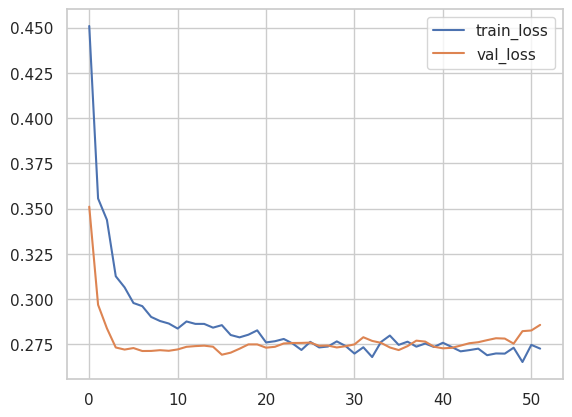

In [ ]:

num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
batch_norm = True if best_hyperparameters['activation_fn'] == 'relu' else False
dropout = [best_hyperparameters['dropout']]

best_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

best_model = DeepHitSingle(best_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

batch_size = best_hyperparameters['batch_size']
best_model.optimizer.set_lr(best_hyperparameters['lr'])

# Train on the entire training set
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience =best_hyperparameters['patience'])]
log = best_model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
_ = log.plot()

# Evaluate on the test set
surv = best_model.predict_surv_df(x_test)
ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
c_index_test = ev_test.concordance_td('antolini')

print(f'Concordance index on test set: {c_index_test}')

# Calculate the integrated Brier score
ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))

print(f'Integrated Brier Score on test set: {ibs}')

In [ ]:
RS_ITERATION = 100
from lifelines.utils import concordance_index
def get_random_hyperparameters():
    SET_BATCH_SIZE = [32, 256]
    SET_LAYERS = [1,5]
    SET_NODES = [25, 100]
    SET_ACTIVATION_FN = ['relu', 'elu', 'tanh']
    SET_ALPHA = [0.1, 1.0]
    SET_SIGMA = [0.1, 1.0]
    SET_LR = [0.001, 0.1]
    SET_DROPOUT = [0.0, 0.95]
    SET_PATIENCE = [25, 75]
    SET_BATCH_NORM = [True, False]

    return {
        'batch_size': int(np.random.uniform(*SET_BATCH_SIZE)),
        'layers': int(np.random.uniform(*SET_LAYERS)),
        'nodes': int(np.random.uniform(*SET_NODES)),
        'activation_fn': SET_ACTIVATION_FN[np.random.randint(len(SET_ACTIVATION_FN))],
        'alpha': np.random.uniform(*SET_ALPHA),
        'sigma': np.random.uniform(*SET_SIGMA),
        'lr': np.random.uniform(*SET_LR),
        'dropout': np.random.uniform(*SET_DROPOUT),
        'patience': int(np.random.uniform(*SET_PATIENCE)),
        'batch_norm': np.random.choice(SET_BATCH_NORM)
    }

# Main loop
max_valid = 0.0
best_model = None
best_hyperparameters = None

for r_itr in range(RS_ITERATION):
    print(f'Random search... itr: {r_itr}')
    hyperparameters = get_random_hyperparameters()
    print(hyperparameters)


    num_nodes = [hyperparameters['nodes']] * hyperparameters['layers']
    batch_norm = hyperparameters['batch_norm']
    dropout = hyperparameters['dropout']

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    model = DeepHitSingle(net, tt.optim.Adam, alpha=hyperparameters['alpha'], sigma=hyperparameters['sigma'], duration_index=labtrans.cuts)

    batch_size = hyperparameters['batch_size']
    model.optimizer.set_lr(hyperparameters['lr'])
    epochs = 100
    callbacks = [tt.callbacks.EarlyStopping(patience=hyperparameters['patience'])]
    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

    # Validate the model
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
    c_index = ev.concordance_td('antolini')

    # If this model is better, save it
    if c_index > max_valid:
        max_valid = c_index
        best_model = model
        best_hyperparameters = hyperparameters

    print(f'Current best c-index: {max_valid}')

print(f'Best hyperparameters: {best_hyperparameters}')



Random search... itr: 0
{'batch_size': 209, 'layers': 1, 'nodes': 73, 'activation_fn': 'tanh', 'alpha': 0.45238118840431807, 'sigma': 0.17585827835328768, 'lr': 0.08638568518622398, 'dropout': 0.2178335761246409, 'patience': 42, 'batch_norm': False}
0:	[0s / 0s],		train_loss: 0.4708,	val_loss: 0.2927
1:	[0s / 0s],		train_loss: 0.3335,	val_loss: 0.3025
2:	[0s / 0s],		train_loss: 0.2808,	val_loss: 0.3058
3:	[0s / 0s],		train_loss: 0.2766,	val_loss: 0.2939
4:	[0s / 0s],		train_loss: 0.2685,	val_loss: 0.2894
5:	[0s / 0s],		train_loss: 0.2477,	val_loss: 0.2898
6:	[0s / 0s],		train_loss: 0.2566,	val_loss: 0.2911
7:	[0s / 0s],		train_loss: 0.2383,	val_loss: 0.3190
8:	[0s / 0s],		train_loss: 0.2343,	val_loss: 0.3036
9:	[0s / 0s],		train_loss: 0.2225,	val_loss: 0.3026
10:	[0s / 0s],		train_loss: 0.2218,	val_loss: 0.3204
11:	[0s / 0s],		train_loss: 0.2150,	val_loss: 0.3272
12:	[0s / 0s],		train_loss: 0.2169,	val_loss: 0.3360
13:	[0s / 0s],		train_loss: 0.2213,	val_loss: 0.3415
14:	[0s / 0s],		tr

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


46:	[0s / 2s],		train_loss: 0.1781,	val_loss: 0.4948
Current best c-index: 0.5582380563495304
Random search... itr: 1
{'batch_size': 212, 'layers': 2, 'nodes': 86, 'activation_fn': 'relu', 'alpha': 0.7529739194472821, 'sigma': 0.3109878673115315, 'lr': 0.09057204713662542, 'dropout': 0.7010333150120399, 'patience': 38, 'batch_norm': True}
0:	[0s / 0s],		train_loss: 0.7689,	val_loss: 0.5518
1:	[0s / 0s],		train_loss: 0.5874,	val_loss: 0.3926
2:	[0s / 0s],		train_loss: 0.4899,	val_loss: 0.3839
3:	[0s / 0s],		train_loss: 0.4602,	val_loss: 0.3971
4:	[0s / 0s],		train_loss: 0.4459,	val_loss: 0.3817
5:	[0s / 0s],		train_loss: 0.4317,	val_loss: 0.3859
6:	[0s / 0s],		train_loss: 0.4269,	val_loss: 0.3864
7:	[0s / 0s],		train_loss: 0.4370,	val_loss: 0.3869
8:	[0s / 0s],		train_loss: 0.4290,	val_loss: 0.3867
9:	[0s / 0s],		train_loss: 0.4125,	val_loss: 0.3835
10:	[0s / 0s],		train_loss: 0.4210,	val_loss: 0.3768
11:	[0s / 0s],		train_loss: 0.4182,	val_loss: 0.3768
12:	[0s / 0s],		train_loss: 0.412

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 9.6001,	val_loss: 6.0176
1:	[0s / 0s],		train_loss: 8.1382,	val_loss: 5.0680
2:	[0s / 0s],		train_loss: 8.8272,	val_loss: 1.5206
3:	[0s / 0s],		train_loss: 2.2910,	val_loss: 0.5841
4:	[0s / 0s],		train_loss: 1.2370,	val_loss: 0.2321
5:	[0s / 0s],		train_loss: 0.5006,	val_loss: 0.2585
6:	[0s / 1s],		train_loss: 0.4391,	val_loss: 0.2193
7:	[0s / 1s],		train_loss: 0.2344,	val_loss: 0.2020
8:	[0s / 1s],		train_loss: 0.2152,	val_loss: 0.1875
9:	[0s / 1s],		train_loss: 0.2010,	val_loss: 0.1756
10:	[0s / 1s],		train_loss: 0.1900,	val_loss: 0.1685
11:	[0s / 2s],		train_loss: 0.2646,	val_loss: 0.1630
12:	[0s / 2s],		train_loss: 0.1821,	val_loss: 0.1601
13:	[0s / 2s],		train_loss: 0.1709,	val_loss: 0.1583
14:	[0s / 2s],		train_loss: 0.4989,	val_loss: 0.1568
15:	[0s / 2s],		train_loss: 0.1851,	val_loss: 0.1569
16:	[0s / 3s],		train_loss: 0.1679,	val_loss: 0.1546
17:	[0s / 3s],		train_loss: 0.1668,	val_loss: 0.1518
18:	[0s / 3s],		train_loss: 0.1638,	val_loss: 0.1510
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6931,	val_loss: 0.3577
1:	[0s / 0s],		train_loss: 0.4894,	val_loss: 0.3589
2:	[0s / 0s],		train_loss: 0.4153,	val_loss: 0.3537
3:	[0s / 1s],		train_loss: 0.3887,	val_loss: 0.3518
4:	[0s / 1s],		train_loss: 0.3904,	val_loss: 0.3550
5:	[0s / 1s],		train_loss: 0.3917,	val_loss: 0.3587
6:	[0s / 1s],		train_loss: 0.3749,	val_loss: 0.3541
7:	[0s / 1s],		train_loss: 0.3859,	val_loss: 0.3502
8:	[0s / 2s],		train_loss: 0.3832,	val_loss: 0.3609
9:	[0s / 2s],		train_loss: 0.4144,	val_loss: 0.3535
10:	[0s / 2s],		train_loss: 0.3933,	val_loss: 0.3559
11:	[0s / 2s],		train_loss: 0.4093,	val_loss: 0.3542
12:	[0s / 3s],		train_loss: 0.4134,	val_loss: 0.3605
13:	[0s / 3s],		train_loss: 0.4023,	val_loss: 0.3562
14:	[0s / 3s],		train_loss: 0.4067,	val_loss: 0.3502
15:	[0s / 3s],		train_loss: 0.3876,	val_loss: 0.3522
16:	[0s / 3s],		train_loss: 0.3983,	val_loss: 0.3565
17:	[0s / 4s],		train_loss: 0.3994,	val_loss: 0.3510
18:	[0s / 4s],		train_loss: 0.4136,	val_loss: 0.3538
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.3857,	val_loss: 0.3995
3:	[0s / 0s],		train_loss: 0.3634,	val_loss: 0.3856
4:	[0s / 0s],		train_loss: 0.3324,	val_loss: 0.3742
5:	[0s / 0s],		train_loss: 0.3192,	val_loss: 0.3597
6:	[0s / 0s],		train_loss: 0.3060,	val_loss: 0.3487
7:	[0s / 0s],		train_loss: 0.2923,	val_loss: 0.3448
8:	[0s / 0s],		train_loss: 0.2831,	val_loss: 0.3435
9:	[0s / 0s],		train_loss: 0.2788,	val_loss: 0.3440
10:	[0s / 0s],		train_loss: 0.2647,	val_loss: 0.3401
11:	[0s / 0s],		train_loss: 0.2673,	val_loss: 0.3389
12:	[0s / 0s],		train_loss: 0.2611,	val_loss: 0.3361
13:	[0s / 0s],		train_loss: 0.2609,	val_loss: 0.3418
14:	[0s / 0s],		train_loss: 0.2575,	val_loss: 0.3427
15:	[0s / 1s],		train_loss: 0.2509,	val_loss: 0.3443
16:	[0s / 1s],		train_loss: 0.2458,	val_loss: 0.3405
17:	[0s / 1s],		train_loss: 0.2456,	val_loss: 0.3403
18:	[0s / 1s],		train_loss: 0.2403,	val_loss: 0.3443
19:	[0s / 1s],		train_loss: 0.2443,	val_loss: 0.3474
20:	[0s / 1s],		train_loss: 0.2316,	val_loss: 0.3502
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6886,	val_loss: 0.5202
1:	[0s / 0s],		train_loss: 0.5310,	val_loss: 0.4737
2:	[0s / 0s],		train_loss: 0.4928,	val_loss: 0.4735
3:	[0s / 0s],		train_loss: 0.5038,	val_loss: 0.4779
4:	[0s / 1s],		train_loss: 0.5018,	val_loss: 0.4679
5:	[0s / 1s],		train_loss: 0.4881,	val_loss: 0.4685
6:	[0s / 1s],		train_loss: 0.4862,	val_loss: 0.4663
7:	[0s / 1s],		train_loss: 0.4917,	val_loss: 0.4681
8:	[0s / 2s],		train_loss: 0.4850,	val_loss: 0.4631
9:	[0s / 2s],		train_loss: 0.4806,	val_loss: 0.4673
10:	[0s / 2s],		train_loss: 0.4864,	val_loss: 0.4725
11:	[0s / 3s],		train_loss: 0.4806,	val_loss: 0.4770
12:	[0s / 3s],		train_loss: 0.4883,	val_loss: 0.4774
13:	[0s / 3s],		train_loss: 0.4770,	val_loss: 0.4809
14:	[0s / 3s],		train_loss: 0.4871,	val_loss: 0.4750
15:	[0s / 3s],		train_loss: 0.4847,	val_loss: 0.4732
16:	[0s / 3s],		train_loss: 0.4750,	val_loss: 0.4810
17:	[0s / 3s],		train_loss: 0.4784,	val_loss: 0.4824
18:	[0s / 4s],		train_loss: 0.4779,	val_loss: 0.4714
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 0.2298,	val_loss: 0.2060
4:	[0s / 0s],		train_loss: 0.2516,	val_loss: 0.2058
5:	[0s / 0s],		train_loss: 0.2135,	val_loss: 0.2069
6:	[0s / 0s],		train_loss: 0.2262,	val_loss: 0.2104
7:	[0s / 0s],		train_loss: 0.2076,	val_loss: 0.2077
8:	[0s / 0s],		train_loss: 0.2111,	val_loss: 0.2072
9:	[0s / 0s],		train_loss: 0.2219,	val_loss: 0.2087
10:	[0s / 0s],		train_loss: 0.2224,	val_loss: 0.2092
11:	[0s / 0s],		train_loss: 0.2307,	val_loss: 0.2085
12:	[0s / 0s],		train_loss: 0.2013,	val_loss: 0.2171
13:	[0s / 0s],		train_loss: 0.2237,	val_loss: 0.2051
14:	[0s / 0s],		train_loss: 0.2201,	val_loss: 0.2117
15:	[0s / 0s],		train_loss: 0.2057,	val_loss: 0.2088
16:	[0s / 1s],		train_loss: 0.2099,	val_loss: 0.2088
17:	[0s / 1s],		train_loss: 0.2025,	val_loss: 0.2092
18:	[0s / 1s],		train_loss: 0.2057,	val_loss: 0.2092
19:	[0s / 1s],		train_loss: 0.2089,	val_loss: 0.2084
20:	[0s / 1s],		train_loss: 0.2100,	val_loss: 0.2124
21:	[0s / 1s],		train_loss: 0.2155,	val_loss: 0.2146


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 1.9952,	val_loss: 0.1653
2:	[0s / 0s],		train_loss: 2.4434,	val_loss: 0.1526
3:	[0s / 0s],		train_loss: 2.1733,	val_loss: 0.1471
4:	[0s / 0s],		train_loss: 2.2278,	val_loss: 0.1431
5:	[0s / 0s],		train_loss: 1.4827,	val_loss: 0.1425
6:	[0s / 0s],		train_loss: 1.2462,	val_loss: 0.1431
7:	[0s / 0s],		train_loss: 1.5047,	val_loss: 0.1435
8:	[0s / 0s],		train_loss: 0.8979,	val_loss: 0.1437
9:	[0s / 1s],		train_loss: 0.8833,	val_loss: 0.1462
10:	[0s / 1s],		train_loss: 0.7054,	val_loss: 0.1470
11:	[0s / 1s],		train_loss: 1.2424,	val_loss: 0.1457
12:	[0s / 1s],		train_loss: 0.4438,	val_loss: 0.1439
13:	[0s / 1s],		train_loss: 0.6501,	val_loss: 0.1436
14:	[0s / 1s],		train_loss: 0.6523,	val_loss: 0.1445
15:	[0s / 1s],		train_loss: 2.2080,	val_loss: 0.1426
16:	[0s / 1s],		train_loss: 1.0612,	val_loss: 0.1422
17:	[0s / 1s],		train_loss: 2.4202,	val_loss: 0.1423
18:	[0s / 2s],		train_loss: 0.6326,	val_loss: 0.1428
19:	[0s / 2s],		train_loss: 0.5817,	val_loss: 0.1426
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.8463,	val_loss: 0.6623
2:	[0s / 0s],		train_loss: 0.7651,	val_loss: 0.5706
3:	[0s / 0s],		train_loss: 0.6756,	val_loss: 0.5325
4:	[0s / 0s],		train_loss: 0.6249,	val_loss: 0.5224
5:	[0s / 0s],		train_loss: 0.5780,	val_loss: 0.5175
6:	[0s / 1s],		train_loss: 0.5724,	val_loss: 0.5087
7:	[0s / 1s],		train_loss: 0.5554,	val_loss: 0.5026
8:	[0s / 1s],		train_loss: 0.5648,	val_loss: 0.4974
9:	[0s / 1s],		train_loss: 0.5108,	val_loss: 0.4939
10:	[0s / 1s],		train_loss: 0.5230,	val_loss: 0.4892
11:	[0s / 1s],		train_loss: 0.5193,	val_loss: 0.4881
12:	[0s / 2s],		train_loss: 0.5070,	val_loss: 0.4817
13:	[0s / 2s],		train_loss: 0.5114,	val_loss: 0.4762
14:	[0s / 2s],		train_loss: 0.4830,	val_loss: 0.4778
15:	[0s / 2s],		train_loss: 0.4966,	val_loss: 0.4779
16:	[0s / 2s],		train_loss: 0.4984,	val_loss: 0.4789
17:	[0s / 2s],		train_loss: 0.4961,	val_loss: 0.4774
18:	[0s / 3s],		train_loss: 0.4955,	val_loss: 0.4723
19:	[0s / 3s],		train_loss: 0.4850,	val_loss: 0.4746
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.6811,	val_loss: 0.4591
2:	[0s / 0s],		train_loss: 0.5627,	val_loss: 0.4312
3:	[0s / 0s],		train_loss: 0.4667,	val_loss: 0.4266
4:	[0s / 0s],		train_loss: 0.4710,	val_loss: 0.4231
5:	[0s / 1s],		train_loss: 0.4541,	val_loss: 0.4250
6:	[0s / 1s],		train_loss: 0.4512,	val_loss: 0.4321
7:	[0s / 1s],		train_loss: 0.4512,	val_loss: 0.4301
8:	[0s / 1s],		train_loss: 0.4638,	val_loss: 0.4253
9:	[0s / 1s],		train_loss: 0.4502,	val_loss: 0.4250
10:	[0s / 1s],		train_loss: 0.4472,	val_loss: 0.4248
11:	[0s / 2s],		train_loss: 0.4379,	val_loss: 0.4262
12:	[0s / 2s],		train_loss: 0.4378,	val_loss: 0.4250
13:	[0s / 2s],		train_loss: 0.4479,	val_loss: 0.4254
14:	[0s / 2s],		train_loss: 0.4407,	val_loss: 0.4249
15:	[0s / 2s],		train_loss: 0.4467,	val_loss: 0.4259
16:	[0s / 2s],		train_loss: 0.4387,	val_loss: 0.4264
17:	[0s / 3s],		train_loss: 0.4392,	val_loss: 0.4263
18:	[0s / 3s],		train_loss: 0.4548,	val_loss: 0.4251
19:	[0s / 3s],		train_loss: 0.4517,	val_loss: 0.4284
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 0.2577,	val_loss: 0.2448
4:	[0s / 0s],		train_loss: 0.2496,	val_loss: 0.2443
5:	[0s / 0s],		train_loss: 0.2427,	val_loss: 0.2427
6:	[0s / 0s],		train_loss: 0.2408,	val_loss: 0.2471
7:	[0s / 0s],		train_loss: 0.2408,	val_loss: 0.2450
8:	[0s / 0s],		train_loss: 0.2362,	val_loss: 0.2471
9:	[0s / 0s],		train_loss: 0.2420,	val_loss: 0.2467
10:	[0s / 0s],		train_loss: 0.2340,	val_loss: 0.2476
11:	[0s / 0s],		train_loss: 0.2365,	val_loss: 0.2498
12:	[0s / 0s],		train_loss: 0.2275,	val_loss: 0.2519
13:	[0s / 0s],		train_loss: 0.2284,	val_loss: 0.2533
14:	[0s / 0s],		train_loss: 0.2303,	val_loss: 0.2519
15:	[0s / 0s],		train_loss: 0.2242,	val_loss: 0.2528
16:	[0s / 0s],		train_loss: 0.2244,	val_loss: 0.2512
17:	[0s / 0s],		train_loss: 0.2271,	val_loss: 0.2531
18:	[0s / 0s],		train_loss: 0.2282,	val_loss: 0.2529
19:	[0s / 0s],		train_loss: 0.2238,	val_loss: 0.2523
20:	[0s / 1s],		train_loss: 0.2193,	val_loss: 0.2559
21:	[0s / 1s],		train_loss: 0.2222,	val_loss: 0.2546


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6873,	val_loss: 0.5559
1:	[0s / 0s],		train_loss: 0.5017,	val_loss: 0.4150
2:	[0s / 0s],		train_loss: 0.4632,	val_loss: 0.4122
3:	[0s / 0s],		train_loss: 0.4560,	val_loss: 0.4135
4:	[0s / 0s],		train_loss: 0.4417,	val_loss: 0.4108
5:	[0s / 0s],		train_loss: 0.4523,	val_loss: 0.4121
6:	[0s / 1s],		train_loss: 0.4472,	val_loss: 0.4137
7:	[0s / 1s],		train_loss: 0.4255,	val_loss: 0.4102
8:	[0s / 1s],		train_loss: 0.4363,	val_loss: 0.4086
9:	[0s / 1s],		train_loss: 0.4292,	val_loss: 0.4131
10:	[0s / 1s],		train_loss: 0.4315,	val_loss: 0.4070
11:	[0s / 1s],		train_loss: 0.4364,	val_loss: 0.4083
12:	[0s / 2s],		train_loss: 0.4439,	val_loss: 0.4104
13:	[0s / 2s],		train_loss: 0.4332,	val_loss: 0.4058
14:	[0s / 2s],		train_loss: 0.4388,	val_loss: 0.4070
15:	[0s / 2s],		train_loss: 0.4194,	val_loss: 0.4122
16:	[0s / 2s],		train_loss: 0.4409,	val_loss: 0.4059
17:	[0s / 2s],		train_loss: 0.4299,	val_loss: 0.4110
18:	[0s / 2s],		train_loss: 0.4388,	val_loss: 0.4142
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 1.0466,	val_loss: 0.8527
1:	[0s / 0s],		train_loss: 0.9765,	val_loss: 0.8204
2:	[0s / 0s],		train_loss: 0.9496,	val_loss: 0.7903
3:	[0s / 0s],		train_loss: 0.9375,	val_loss: 0.7688
4:	[0s / 0s],		train_loss: 0.8762,	val_loss: 0.7513
5:	[0s / 0s],		train_loss: 0.8520,	val_loss: 0.7337
6:	[0s / 0s],		train_loss: 0.8306,	val_loss: 0.7135
7:	[0s / 0s],		train_loss: 0.8196,	val_loss: 0.6978
8:	[0s / 0s],		train_loss: 0.7836,	val_loss: 0.6827
9:	[0s / 0s],		train_loss: 0.7700,	val_loss: 0.6692
10:	[0s / 0s],		train_loss: 0.7514,	val_loss: 0.6538
11:	[0s / 0s],		train_loss: 0.7234,	val_loss: 0.6369
12:	[0s / 0s],		train_loss: 0.7353,	val_loss: 0.6237
13:	[0s / 1s],		train_loss: 0.6959,	val_loss: 0.6075
14:	[0s / 1s],		train_loss: 0.7014,	val_loss: 0.5933
15:	[0s / 1s],		train_loss: 0.6752,	val_loss: 0.5813
16:	[0s / 1s],		train_loss: 0.6774,	val_loss: 0.5742
17:	[0s / 1s],		train_loss: 0.6670,	val_loss: 0.5624
18:	[0s / 1s],		train_loss: 0.6518,	val_loss: 0.5555
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.2171,	val_loss: 0.2059
3:	[0s / 0s],		train_loss: 0.2140,	val_loss: 0.1972
4:	[0s / 0s],		train_loss: 0.1957,	val_loss: 0.1939
5:	[0s / 0s],		train_loss: 0.2095,	val_loss: 0.1970
6:	[0s / 0s],		train_loss: 0.2290,	val_loss: 0.1898
7:	[0s / 0s],		train_loss: 0.2164,	val_loss: 0.1882
8:	[0s / 0s],		train_loss: 0.1956,	val_loss: 0.1734
9:	[0s / 0s],		train_loss: 0.1848,	val_loss: 0.1601
10:	[0s / 0s],		train_loss: 0.1598,	val_loss: 0.1656
11:	[0s / 0s],		train_loss: 0.2445,	val_loss: 0.1811
12:	[0s / 0s],		train_loss: 0.2109,	val_loss: 0.1884
13:	[0s / 0s],		train_loss: 0.2073,	val_loss: 0.1724
14:	[0s / 0s],		train_loss: 0.1873,	val_loss: 0.1606
15:	[0s / 0s],		train_loss: 0.1769,	val_loss: 0.1613
16:	[0s / 0s],		train_loss: 0.1693,	val_loss: 0.1596
17:	[0s / 1s],		train_loss: 0.1564,	val_loss: 0.1542
18:	[0s / 1s],		train_loss: 0.1500,	val_loss: 0.1507
19:	[0s / 1s],		train_loss: 0.1437,	val_loss: 0.1533
20:	[0s / 1s],		train_loss: 0.1414,	val_loss: 0.1525
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.4538,	val_loss: 0.3391
1:	[0s / 0s],		train_loss: 0.3762,	val_loss: 0.3386
2:	[0s / 0s],		train_loss: 0.3529,	val_loss: 0.3442
3:	[0s / 0s],		train_loss: 0.3650,	val_loss: 0.3470
4:	[0s / 0s],		train_loss: 0.3499,	val_loss: 0.3359
5:	[0s / 0s],		train_loss: 0.3624,	val_loss: 0.3372
6:	[0s / 0s],		train_loss: 0.3377,	val_loss: 0.3366
7:	[0s / 0s],		train_loss: 0.3235,	val_loss: 0.3483
8:	[0s / 1s],		train_loss: 0.3257,	val_loss: 0.3317
9:	[0s / 1s],		train_loss: 0.3212,	val_loss: 0.3391
10:	[0s / 1s],		train_loss: 0.3174,	val_loss: 0.3385
11:	[0s / 1s],		train_loss: 0.3157,	val_loss: 0.3376
12:	[0s / 1s],		train_loss: 0.3127,	val_loss: 0.3314
13:	[0s / 1s],		train_loss: 0.3191,	val_loss: 0.3355
14:	[0s / 1s],		train_loss: 0.3230,	val_loss: 0.3338
15:	[0s / 1s],		train_loss: 0.3137,	val_loss: 0.3443
16:	[0s / 2s],		train_loss: 0.3100,	val_loss: 0.3394
17:	[0s / 2s],		train_loss: 0.3158,	val_loss: 0.3338
18:	[0s / 2s],		train_loss: 0.3146,	val_loss: 0.3489
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.4290,	val_loss: 0.4134
2:	[0s / 0s],		train_loss: 0.4220,	val_loss: 0.4168
3:	[0s / 0s],		train_loss: 0.4117,	val_loss: 0.4190
4:	[0s / 0s],		train_loss: 0.3988,	val_loss: 0.4075
5:	[0s / 0s],		train_loss: 0.4026,	val_loss: 0.4106
6:	[0s / 0s],		train_loss: 0.3950,	val_loss: 0.4190
7:	[0s / 1s],		train_loss: 0.3919,	val_loss: 0.4248
8:	[0s / 1s],		train_loss: 0.3894,	val_loss: 0.4375
9:	[0s / 1s],		train_loss: 0.4035,	val_loss: 0.4239
10:	[0s / 1s],		train_loss: 0.3828,	val_loss: 0.4585
11:	[0s / 1s],		train_loss: 0.3708,	val_loss: 0.4810
12:	[0s / 1s],		train_loss: 0.3798,	val_loss: 0.4493
13:	[0s / 1s],		train_loss: 0.3852,	val_loss: 0.4743
14:	[0s / 1s],		train_loss: 0.3662,	val_loss: 0.4633
15:	[0s / 2s],		train_loss: 0.3783,	val_loss: 0.4399
16:	[0s / 2s],		train_loss: 0.3942,	val_loss: 0.4336
17:	[0s / 2s],		train_loss: 0.3877,	val_loss: 0.4768
18:	[0s / 2s],		train_loss: 0.3674,	val_loss: 0.4649
19:	[0s / 2s],		train_loss: 0.3634,	val_loss: 0.4945
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.1663,	val_loss: 0.1423
3:	[0s / 0s],		train_loss: 0.1532,	val_loss: 0.1418
4:	[0s / 0s],		train_loss: 0.1588,	val_loss: 0.1419
5:	[0s / 0s],		train_loss: 0.1502,	val_loss: 0.1413
6:	[0s / 0s],		train_loss: 0.1499,	val_loss: 0.1408
7:	[0s / 0s],		train_loss: 0.1525,	val_loss: 0.1410
8:	[0s / 0s],		train_loss: 0.1480,	val_loss: 0.1409
9:	[0s / 0s],		train_loss: 0.1495,	val_loss: 0.1407
10:	[0s / 0s],		train_loss: 0.1467,	val_loss: 0.1412
11:	[0s / 1s],		train_loss: 0.1482,	val_loss: 0.1409
12:	[0s / 1s],		train_loss: 0.1478,	val_loss: 0.1408
13:	[0s / 1s],		train_loss: 0.1488,	val_loss: 0.1409
14:	[0s / 1s],		train_loss: 0.1476,	val_loss: 0.1410
15:	[0s / 1s],		train_loss: 0.1483,	val_loss: 0.1406
16:	[0s / 1s],		train_loss: 0.1482,	val_loss: 0.1409
17:	[0s / 1s],		train_loss: 0.1473,	val_loss: 0.1407
18:	[0s / 1s],		train_loss: 0.1453,	val_loss: 0.1407
19:	[0s / 1s],		train_loss: 0.1489,	val_loss: 0.1410
20:	[0s / 1s],		train_loss: 0.1474,	val_loss: 0.1408
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.4743,	val_loss: 0.4589
2:	[0s / 0s],		train_loss: 0.4452,	val_loss: 0.4597
3:	[0s / 0s],		train_loss: 0.5181,	val_loss: 0.4746
4:	[0s / 0s],		train_loss: 0.5905,	val_loss: 0.4933
5:	[0s / 0s],		train_loss: 0.4410,	val_loss: 0.4412
6:	[0s / 0s],		train_loss: 0.4409,	val_loss: 0.4526
7:	[0s / 0s],		train_loss: 0.5006,	val_loss: 0.4682
8:	[0s / 1s],		train_loss: 0.5250,	val_loss: 0.4440
9:	[0s / 1s],		train_loss: 0.4384,	val_loss: 0.4661
10:	[0s / 1s],		train_loss: 0.4397,	val_loss: 0.4424
11:	[0s / 1s],		train_loss: 0.4122,	val_loss: 0.4449
12:	[0s / 1s],		train_loss: 0.3968,	val_loss: 0.4601
13:	[0s / 1s],		train_loss: 0.4044,	val_loss: 0.4570
14:	[0s / 1s],		train_loss: 0.3968,	val_loss: 0.4594
15:	[0s / 1s],		train_loss: 0.3973,	val_loss: 0.4565
16:	[0s / 1s],		train_loss: 0.3868,	val_loss: 0.4711
17:	[0s / 1s],		train_loss: 0.4218,	val_loss: 0.4780
18:	[0s / 2s],		train_loss: 0.4048,	val_loss: 0.4783
19:	[0s / 2s],		train_loss: 0.4469,	val_loss: 0.4560
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.2638,	val_loss: 0.2637
3:	[0s / 0s],		train_loss: 0.2614,	val_loss: 0.2613
4:	[0s / 0s],		train_loss: 0.2609,	val_loss: 0.2476
5:	[0s / 0s],		train_loss: 0.2556,	val_loss: 0.2504
6:	[0s / 0s],		train_loss: 0.2461,	val_loss: 0.2476
7:	[0s / 0s],		train_loss: 0.2490,	val_loss: 0.2473
8:	[0s / 0s],		train_loss: 0.2466,	val_loss: 0.2478
9:	[0s / 0s],		train_loss: 0.2437,	val_loss: 0.2544
10:	[0s / 1s],		train_loss: 0.2371,	val_loss: 0.2496
11:	[0s / 1s],		train_loss: 0.2435,	val_loss: 0.2546
12:	[0s / 1s],		train_loss: 0.2486,	val_loss: 0.2531
13:	[0s / 1s],		train_loss: 0.2509,	val_loss: 0.2601
14:	[0s / 1s],		train_loss: 0.2493,	val_loss: 0.2532
15:	[0s / 1s],		train_loss: 0.2353,	val_loss: 0.2557
16:	[0s / 1s],		train_loss: 0.2354,	val_loss: 0.2614
17:	[0s / 1s],		train_loss: 0.2366,	val_loss: 0.2618
18:	[0s / 1s],		train_loss: 0.2410,	val_loss: 0.2630
19:	[0s / 1s],		train_loss: 0.2413,	val_loss: 0.2563
20:	[0s / 1s],		train_loss: 0.2440,	val_loss: 0.2598
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2122,	val_loss: 0.1401
2:	[0s / 0s],		train_loss: 0.1667,	val_loss: 0.1442
3:	[0s / 0s],		train_loss: 0.1564,	val_loss: 0.1401
4:	[0s / 0s],		train_loss: 0.1588,	val_loss: 0.1400
5:	[0s / 0s],		train_loss: 0.1494,	val_loss: 0.1409
6:	[0s / 0s],		train_loss: 0.1528,	val_loss: 0.1410
7:	[0s / 0s],		train_loss: 0.1502,	val_loss: 0.1405
8:	[0s / 0s],		train_loss: 0.1537,	val_loss: 0.1412
9:	[0s / 1s],		train_loss: 0.1525,	val_loss: 0.1400
10:	[0s / 1s],		train_loss: 0.1556,	val_loss: 0.1399
11:	[0s / 1s],		train_loss: 0.1489,	val_loss: 0.1408
12:	[0s / 1s],		train_loss: 0.1517,	val_loss: 0.1413
13:	[0s / 1s],		train_loss: 0.1504,	val_loss: 0.1398
14:	[0s / 1s],		train_loss: 0.1545,	val_loss: 0.1406
15:	[0s / 1s],		train_loss: 0.1531,	val_loss: 0.1402
16:	[0s / 1s],		train_loss: 0.1546,	val_loss: 0.1400
17:	[0s / 1s],		train_loss: 0.1517,	val_loss: 0.1419
18:	[0s / 1s],		train_loss: 0.1565,	val_loss: 0.1399
19:	[0s / 2s],		train_loss: 0.1535,	val_loss: 0.1407
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.638985300122499
Random search... itr: 20
{'batch_size': 143, 'layers': 3, 'nodes': 25, 'activation_fn': 'relu', 'alpha': 0.3685204379003709, 'sigma': 0.6707332861741353, 'lr': 0.01648528631483533, 'dropout': 0.7904520730033374, 'patience': 53, 'batch_norm': False}
0:	[0s / 0s],		train_loss: 0.6421,	val_loss: 0.2834
1:	[0s / 0s],		train_loss: 0.3742,	val_loss: 0.2801
2:	[0s / 0s],		train_loss: 0.3531,	val_loss: 0.2611
3:	[0s / 0s],		train_loss: 0.3031,	val_loss: 0.2468
4:	[0s / 0s],		train_loss: 0.2703,	val_loss: 0.2350
5:	[0s / 0s],		train_loss: 0.2644,	val_loss: 0.2309
6:	[0s / 0s],		train_loss: 0.2593,	val_loss: 0.2310
7:	[0s / 1s],		train_loss: 0.2471,	val_loss: 0.2289
8:	[0s / 1s],		train_loss: 0.2513,	val_loss: 0.2267
9:	[0s / 1s],		train_loss: 0.2487,	val_loss: 0.2271
10:	[0s / 1s],		train_loss: 0.2436,	val_loss: 0.2256
11:	[0s / 1s],		train_loss: 0.2423,	val_loss: 0.2251
12:	[0s / 1s],		train_loss: 0.2412,	val_loss: 0.2255
13:	[0s / 1s],		train_loss: 0.24

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 0.4434,	val_loss: 0.4190
4:	[0s / 0s],		train_loss: 0.4239,	val_loss: 0.4149
5:	[0s / 0s],		train_loss: 0.3998,	val_loss: 0.4237
6:	[0s / 0s],		train_loss: 0.4182,	val_loss: 0.4194
7:	[0s / 0s],		train_loss: 0.4033,	val_loss: 0.4125
8:	[0s / 0s],		train_loss: 0.4076,	val_loss: 0.4223
9:	[0s / 0s],		train_loss: 0.4114,	val_loss: 0.4477
10:	[0s / 0s],		train_loss: 0.4151,	val_loss: 0.4358
11:	[0s / 0s],		train_loss: 0.4027,	val_loss: 0.4242
12:	[0s / 0s],		train_loss: 0.3908,	val_loss: 0.4462
13:	[0s / 0s],		train_loss: 0.4049,	val_loss: 0.4350
14:	[0s / 0s],		train_loss: 0.3999,	val_loss: 0.4313
15:	[0s / 0s],		train_loss: 0.4084,	val_loss: 0.4438
16:	[0s / 1s],		train_loss: 0.4248,	val_loss: 0.4297
17:	[0s / 1s],		train_loss: 0.3989,	val_loss: 0.4421
18:	[0s / 1s],		train_loss: 0.4191,	val_loss: 0.4419
19:	[0s / 1s],		train_loss: 0.4085,	val_loss: 0.4400
20:	[0s / 1s],		train_loss: 0.3848,	val_loss: 0.4359
21:	[0s / 1s],		train_loss: 0.3885,	val_loss: 0.4343


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2048,	val_loss: 0.1454
2:	[0s / 0s],		train_loss: 0.1677,	val_loss: 0.1397
3:	[0s / 0s],		train_loss: 0.1614,	val_loss: 0.1359
4:	[0s / 0s],		train_loss: 0.1545,	val_loss: 0.1401
5:	[0s / 0s],		train_loss: 0.1541,	val_loss: 0.1362
6:	[0s / 0s],		train_loss: 0.1517,	val_loss: 0.1377
7:	[0s / 0s],		train_loss: 0.1507,	val_loss: 0.1368
8:	[0s / 0s],		train_loss: 0.1517,	val_loss: 0.1378
9:	[0s / 0s],		train_loss: 0.1489,	val_loss: 0.1381
10:	[0s / 0s],		train_loss: 0.1504,	val_loss: 0.1379
11:	[0s / 0s],		train_loss: 0.1491,	val_loss: 0.1411
12:	[0s / 0s],		train_loss: 0.1490,	val_loss: 0.1378
13:	[0s / 0s],		train_loss: 0.1477,	val_loss: 0.1356
14:	[0s / 0s],		train_loss: 0.1465,	val_loss: 0.1371
15:	[0s / 1s],		train_loss: 0.1508,	val_loss: 0.1354
16:	[0s / 1s],		train_loss: 0.1484,	val_loss: 0.1371
17:	[0s / 1s],		train_loss: 0.1451,	val_loss: 0.1364
18:	[0s / 1s],		train_loss: 0.1486,	val_loss: 0.1346
19:	[0s / 1s],		train_loss: 0.1493,	val_loss: 0.1351
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2504,	val_loss: 0.1762
1:	[0s / 0s],		train_loss: 0.2064,	val_loss: 0.1544
2:	[0s / 0s],		train_loss: 0.1708,	val_loss: 0.1504
3:	[0s / 0s],		train_loss: 0.1672,	val_loss: 0.1494
4:	[0s / 0s],		train_loss: 0.1671,	val_loss: 0.1515
5:	[0s / 0s],		train_loss: 0.1698,	val_loss: 0.1512
6:	[0s / 0s],		train_loss: 0.1648,	val_loss: 0.1515
7:	[0s / 0s],		train_loss: 0.1649,	val_loss: 0.1502
8:	[0s / 1s],		train_loss: 0.1630,	val_loss: 0.1493
9:	[0s / 1s],		train_loss: 0.1621,	val_loss: 0.1510
10:	[0s / 1s],		train_loss: 0.1596,	val_loss: 0.1487
11:	[0s / 1s],		train_loss: 0.1563,	val_loss: 0.1516
12:	[0s / 1s],		train_loss: 0.1645,	val_loss: 0.1500
13:	[0s / 1s],		train_loss: 0.1551,	val_loss: 0.1512
14:	[0s / 1s],		train_loss: 0.1624,	val_loss: 0.1508
15:	[0s / 1s],		train_loss: 0.1614,	val_loss: 0.1495
16:	[0s / 1s],		train_loss: 0.1605,	val_loss: 0.1519
17:	[0s / 1s],		train_loss: 0.1554,	val_loss: 0.1529
18:	[0s / 2s],		train_loss: 0.1654,	val_loss: 0.1509
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.7226,	val_loss: 0.5145
1:	[0s / 0s],		train_loss: 0.4888,	val_loss: 0.4275
2:	[0s / 0s],		train_loss: 0.4714,	val_loss: 0.4194
3:	[0s / 0s],		train_loss: 0.4506,	val_loss: 0.4318
4:	[0s / 1s],		train_loss: 0.4509,	val_loss: 0.4131
5:	[0s / 1s],		train_loss: 0.4478,	val_loss: 0.4132
6:	[0s / 1s],		train_loss: 0.4501,	val_loss: 0.4205
7:	[0s / 1s],		train_loss: 0.4447,	val_loss: 0.4286
8:	[0s / 1s],		train_loss: 0.4525,	val_loss: 0.4569
9:	[0s / 2s],		train_loss: 0.4515,	val_loss: 0.4160
10:	[0s / 2s],		train_loss: 0.4512,	val_loss: 0.4221
11:	[0s / 2s],		train_loss: 0.4528,	val_loss: 0.4123
12:	[0s / 2s],		train_loss: 0.4467,	val_loss: 0.4327
13:	[0s / 3s],		train_loss: 0.4489,	val_loss: 0.4227
14:	[0s / 3s],		train_loss: 0.4530,	val_loss: 0.4437
15:	[0s / 3s],		train_loss: 0.4444,	val_loss: 0.4431
16:	[0s / 4s],		train_loss: 0.4523,	val_loss: 0.4352
17:	[0s / 4s],		train_loss: 0.4561,	val_loss: 0.4259
18:	[0s / 4s],		train_loss: 0.4437,	val_loss: 0.4316
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.4624,	val_loss: 0.4269
3:	[0s / 0s],		train_loss: 0.4608,	val_loss: 0.4211
4:	[0s / 0s],		train_loss: 0.4508,	val_loss: 0.4149
5:	[0s / 0s],		train_loss: 0.4431,	val_loss: 0.4149
6:	[0s / 0s],		train_loss: 0.4440,	val_loss: 0.4165
7:	[0s / 0s],		train_loss: 0.4385,	val_loss: 0.4119
8:	[0s / 0s],		train_loss: 0.4402,	val_loss: 0.4090
9:	[0s / 0s],		train_loss: 0.4368,	val_loss: 0.4128
10:	[0s / 0s],		train_loss: 0.4368,	val_loss: 0.4118
11:	[0s / 0s],		train_loss: 0.4387,	val_loss: 0.4154
12:	[0s / 0s],		train_loss: 0.4324,	val_loss: 0.4081
13:	[0s / 1s],		train_loss: 0.4287,	val_loss: 0.4244
14:	[0s / 1s],		train_loss: 0.4408,	val_loss: 0.4199
15:	[0s / 1s],		train_loss: 0.4388,	val_loss: 0.4146
16:	[0s / 1s],		train_loss: 0.4377,	val_loss: 0.4228
17:	[0s / 1s],		train_loss: 0.4321,	val_loss: 0.4132
18:	[0s / 1s],		train_loss: 0.4329,	val_loss: 0.4203
19:	[0s / 1s],		train_loss: 0.4311,	val_loss: 0.4266
20:	[0s / 1s],		train_loss: 0.4333,	val_loss: 0.4104
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.1915,	val_loss: 0.1696
2:	[0s / 0s],		train_loss: 0.1698,	val_loss: 0.1675
3:	[0s / 0s],		train_loss: 0.1648,	val_loss: 0.1606
4:	[0s / 0s],		train_loss: 0.1622,	val_loss: 0.1583
5:	[0s / 0s],		train_loss: 0.1603,	val_loss: 0.1565
6:	[0s / 0s],		train_loss: 0.1542,	val_loss: 0.1559
7:	[0s / 0s],		train_loss: 0.1593,	val_loss: 0.1536
8:	[0s / 1s],		train_loss: 0.1549,	val_loss: 0.1568
9:	[0s / 1s],		train_loss: 0.1540,	val_loss: 0.1570
10:	[0s / 1s],		train_loss: 0.1550,	val_loss: 0.1567
11:	[0s / 1s],		train_loss: 0.1533,	val_loss: 0.1593
12:	[0s / 1s],		train_loss: 0.1514,	val_loss: 0.1592
13:	[0s / 1s],		train_loss: 0.1499,	val_loss: 0.1567
14:	[0s / 1s],		train_loss: 0.1527,	val_loss: 0.1572
15:	[0s / 1s],		train_loss: 0.1530,	val_loss: 0.1578
16:	[0s / 1s],		train_loss: 0.1486,	val_loss: 0.1590
17:	[0s / 2s],		train_loss: 0.1467,	val_loss: 0.1597
18:	[0s / 2s],		train_loss: 0.1461,	val_loss: 0.1587
19:	[0s / 2s],		train_loss: 0.1472,	val_loss: 0.1567
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.5787,	val_loss: 0.4826
3:	[0s / 0s],		train_loss: 0.5391,	val_loss: 0.4728
4:	[0s / 0s],		train_loss: 0.5131,	val_loss: 0.4447
5:	[0s / 0s],		train_loss: 0.4985,	val_loss: 0.4305
6:	[0s / 0s],		train_loss: 0.4909,	val_loss: 0.4316
7:	[0s / 0s],		train_loss: 0.4762,	val_loss: 0.4340
8:	[0s / 0s],		train_loss: 0.4710,	val_loss: 0.4276
9:	[0s / 0s],		train_loss: 0.4690,	val_loss: 0.4259
10:	[0s / 0s],		train_loss: 0.4596,	val_loss: 0.4273
11:	[0s / 0s],		train_loss: 0.4672,	val_loss: 0.4274
12:	[0s / 0s],		train_loss: 0.4555,	val_loss: 0.4282
13:	[0s / 1s],		train_loss: 0.4609,	val_loss: 0.4259
14:	[0s / 1s],		train_loss: 0.4600,	val_loss: 0.4265
15:	[0s / 1s],		train_loss: 0.4581,	val_loss: 0.4285
16:	[0s / 1s],		train_loss: 0.4574,	val_loss: 0.4272
17:	[0s / 1s],		train_loss: 0.4454,	val_loss: 0.4258
18:	[0s / 1s],		train_loss: 0.4525,	val_loss: 0.4257
19:	[0s / 1s],		train_loss: 0.4479,	val_loss: 0.4235
20:	[0s / 1s],		train_loss: 0.4518,	val_loss: 0.4236
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.5302,	val_loss: 0.4416
2:	[0s / 0s],		train_loss: 0.4771,	val_loss: 0.4200
3:	[0s / 0s],		train_loss: 0.4732,	val_loss: 0.4148
4:	[0s / 0s],		train_loss: 0.4527,	val_loss: 0.4119
5:	[0s / 0s],		train_loss: 0.4523,	val_loss: 0.4213
6:	[0s / 0s],		train_loss: 0.4205,	val_loss: 0.4058
7:	[0s / 0s],		train_loss: 0.4327,	val_loss: 0.4180
8:	[0s / 0s],		train_loss: 0.4277,	val_loss: 0.4074
9:	[0s / 0s],		train_loss: 0.4299,	val_loss: 0.4142
10:	[0s / 1s],		train_loss: 0.4379,	val_loss: 0.4064
11:	[0s / 1s],		train_loss: 0.4253,	val_loss: 0.4014
12:	[0s / 1s],		train_loss: 0.4181,	val_loss: 0.4014
13:	[0s / 1s],		train_loss: 0.4303,	val_loss: 0.4043
14:	[0s / 1s],		train_loss: 0.4287,	val_loss: 0.3998
15:	[0s / 1s],		train_loss: 0.4265,	val_loss: 0.4062
16:	[0s / 1s],		train_loss: 0.3959,	val_loss: 0.3989
17:	[0s / 1s],		train_loss: 0.4174,	val_loss: 0.3999
18:	[0s / 1s],		train_loss: 0.4101,	val_loss: 0.4012
19:	[0s / 2s],		train_loss: 0.4232,	val_loss: 0.3964
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.638985300122499
Random search... itr: 29
{'batch_size': 171, 'layers': 2, 'nodes': 58, 'activation_fn': 'elu', 'alpha': 0.41993234851848316, 'sigma': 0.7859517856477491, 'lr': 0.05958590391863763, 'dropout': 0.01571558761310095, 'patience': 46, 'batch_norm': False}
0:	[0s / 0s],		train_loss: 0.3137,	val_loss: 0.2895
1:	[0s / 0s],		train_loss: 0.2652,	val_loss: 0.2550
2:	[0s / 0s],		train_loss: 0.2511,	val_loss: 0.2651
3:	[0s / 0s],		train_loss: 0.2528,	val_loss: 0.2601
4:	[0s / 0s],		train_loss: 0.2383,	val_loss: 0.2831
5:	[0s / 0s],		train_loss: 0.2318,	val_loss: 0.2788
6:	[0s / 0s],		train_loss: 0.2303,	val_loss: 0.2927
7:	[0s / 0s],		train_loss: 0.2237,	val_loss: 0.3070
8:	[0s / 0s],		train_loss: 0.2312,	val_loss: 0.3003
9:	[0s / 0s],		train_loss: 0.2324,	val_loss: 0.3045
10:	[0s / 0s],		train_loss: 0.2275,	val_loss: 0.2894
11:	[0s / 0s],		train_loss: 0.2280,	val_loss: 0.2962
12:	[0s / 0s],		train_loss: 0.2252,	val_loss: 0.3251
13:	[0s / 0s],		train_loss: 0.2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.4667,	val_loss: 0.4357
3:	[0s / 0s],		train_loss: 0.4556,	val_loss: 0.4264
4:	[0s / 0s],		train_loss: 0.4491,	val_loss: 0.4203
5:	[0s / 0s],		train_loss: 0.4381,	val_loss: 0.4187
6:	[0s / 0s],		train_loss: 0.4220,	val_loss: 0.4263
7:	[0s / 0s],		train_loss: 0.4257,	val_loss: 0.4232
8:	[0s / 0s],		train_loss: 0.4253,	val_loss: 0.4298
9:	[0s / 0s],		train_loss: 0.4435,	val_loss: 0.4289
10:	[0s / 0s],		train_loss: 0.4263,	val_loss: 0.4165
11:	[0s / 0s],		train_loss: 0.4285,	val_loss: 0.4200
12:	[0s / 0s],		train_loss: 0.4483,	val_loss: 0.4289
13:	[0s / 1s],		train_loss: 0.4363,	val_loss: 0.4146
14:	[0s / 1s],		train_loss: 0.4335,	val_loss: 0.4332
15:	[0s / 1s],		train_loss: 0.4462,	val_loss: 0.4177
16:	[0s / 1s],		train_loss: 0.4267,	val_loss: 0.4162
17:	[0s / 1s],		train_loss: 0.4322,	val_loss: 0.4235
18:	[0s / 1s],		train_loss: 0.4250,	val_loss: 0.4224
19:	[0s / 1s],		train_loss: 0.4312,	val_loss: 0.4198
20:	[0s / 1s],		train_loss: 0.4318,	val_loss: 0.4225
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.638985300122499
Random search... itr: 31
{'batch_size': 89, 'layers': 2, 'nodes': 46, 'activation_fn': 'elu', 'alpha': 0.9632045250100247, 'sigma': 0.4310328214540088, 'lr': 0.03998511271622363, 'dropout': 0.45962906712178286, 'patience': 72, 'batch_norm': True}
0:	[0s / 0s],		train_loss: 0.7180,	val_loss: 0.5138
1:	[0s / 0s],		train_loss: 0.5382,	val_loss: 0.4793
2:	[0s / 0s],		train_loss: 0.5078,	val_loss: 0.4740
3:	[0s / 0s],		train_loss: 0.5114,	val_loss: 0.4702
4:	[0s / 0s],		train_loss: 0.4932,	val_loss: 0.4652
5:	[0s / 0s],		train_loss: 0.4852,	val_loss: 0.4651
6:	[0s / 0s],		train_loss: 0.4844,	val_loss: 0.4679
7:	[0s / 0s],		train_loss: 0.4891,	val_loss: 0.4662
8:	[0s / 1s],		train_loss: 0.4813,	val_loss: 0.4610
9:	[0s / 1s],		train_loss: 0.4850,	val_loss: 0.4594
10:	[0s / 1s],		train_loss: 0.4806,	val_loss: 0.4680
11:	[0s / 1s],		train_loss: 0.4782,	val_loss: 0.4654
12:	[0s / 1s],		train_loss: 0.4689,	val_loss: 0.4606
13:	[0s / 1s],		train_loss: 0.4976

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.5591,	val_loss: 0.1199
3:	[0s / 0s],		train_loss: 0.6344,	val_loss: 0.1189
4:	[0s / 0s],		train_loss: 0.3618,	val_loss: 0.1214
5:	[0s / 0s],		train_loss: 0.4676,	val_loss: 0.1168
6:	[0s / 0s],		train_loss: 0.5155,	val_loss: 0.1164
7:	[0s / 0s],		train_loss: 0.4696,	val_loss: 0.1163
8:	[0s / 0s],		train_loss: 0.5001,	val_loss: 0.1163
9:	[0s / 0s],		train_loss: 0.5339,	val_loss: 0.1166
10:	[0s / 0s],		train_loss: 0.3781,	val_loss: 0.1165
11:	[0s / 1s],		train_loss: 0.3567,	val_loss: 0.1166
12:	[0s / 1s],		train_loss: 0.2951,	val_loss: 0.1162
13:	[0s / 1s],		train_loss: 0.3170,	val_loss: 0.1157
14:	[0s / 1s],		train_loss: 0.1901,	val_loss: 0.1148
15:	[0s / 1s],		train_loss: 0.2265,	val_loss: 0.1148
16:	[0s / 1s],		train_loss: 0.1697,	val_loss: 0.1150
17:	[0s / 1s],		train_loss: 0.1697,	val_loss: 0.1149
18:	[0s / 1s],		train_loss: 0.2746,	val_loss: 0.1149
19:	[0s / 1s],		train_loss: 0.2296,	val_loss: 0.1151
20:	[0s / 1s],		train_loss: 0.3247,	val_loss: 0.1150
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2003,	val_loss: 0.1370
1:	[0s / 0s],		train_loss: 0.1675,	val_loss: 0.1314
2:	[0s / 0s],		train_loss: 0.1520,	val_loss: 0.1265
3:	[0s / 0s],		train_loss: 0.1390,	val_loss: 0.1241
4:	[0s / 0s],		train_loss: 0.1327,	val_loss: 0.1235
5:	[0s / 0s],		train_loss: 0.1340,	val_loss: 0.1230
6:	[0s / 0s],		train_loss: 0.1335,	val_loss: 0.1227
7:	[0s / 0s],		train_loss: 0.1311,	val_loss: 0.1226
8:	[0s / 0s],		train_loss: 0.1300,	val_loss: 0.1225
9:	[0s / 0s],		train_loss: 0.1280,	val_loss: 0.1224
10:	[0s / 0s],		train_loss: 0.1276,	val_loss: 0.1222
11:	[0s / 0s],		train_loss: 0.1301,	val_loss: 0.1223
12:	[0s / 0s],		train_loss: 0.1291,	val_loss: 0.1222
13:	[0s / 0s],		train_loss: 0.1294,	val_loss: 0.1224
14:	[0s / 0s],		train_loss: 0.1286,	val_loss: 0.1222
15:	[0s / 0s],		train_loss: 0.1288,	val_loss: 0.1221
16:	[0s / 0s],		train_loss: 0.1284,	val_loss: 0.1221
17:	[0s / 0s],		train_loss: 0.1298,	val_loss: 0.1223
18:	[0s / 0s],		train_loss: 0.1280,	val_loss: 0.1221
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.638985300122499
Random search... itr: 34
{'batch_size': 198, 'layers': 3, 'nodes': 91, 'activation_fn': 'tanh', 'alpha': 0.9233550058028855, 'sigma': 0.9571261573555485, 'lr': 0.0627113196459892, 'dropout': 0.535890131253898, 'patience': 29, 'batch_norm': True}
0:	[0s / 0s],		train_loss: 0.9045,	val_loss: 1.0745
1:	[0s / 0s],		train_loss: 0.6945,	val_loss: 0.4996
2:	[0s / 0s],		train_loss: 0.5538,	val_loss: 0.4708
3:	[0s / 0s],		train_loss: 0.5018,	val_loss: 0.4551
4:	[0s / 0s],		train_loss: 0.5214,	val_loss: 0.4595
5:	[0s / 0s],		train_loss: 0.4913,	val_loss: 0.4559
6:	[0s / 0s],		train_loss: 0.4832,	val_loss: 0.4645
7:	[0s / 0s],		train_loss: 0.5122,	val_loss: 0.4512
8:	[0s / 0s],		train_loss: 0.4971,	val_loss: 0.4554
9:	[0s / 0s],		train_loss: 0.4954,	val_loss: 0.4541
10:	[0s / 0s],		train_loss: 0.5410,	val_loss: 0.4489
11:	[0s / 1s],		train_loss: 0.5120,	val_loss: 0.4463
12:	[0s / 1s],		train_loss: 0.4752,	val_loss: 0.4737
13:	[0s / 1s],		train_loss: 0.4937,

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3398,	val_loss: 0.1416
1:	[0s / 0s],		train_loss: 0.2573,	val_loss: 0.1479
2:	[0s / 0s],		train_loss: 0.1862,	val_loss: 0.1431
3:	[0s / 0s],		train_loss: 0.1785,	val_loss: 0.1394
4:	[0s / 0s],		train_loss: 0.1683,	val_loss: 0.1353
5:	[0s / 0s],		train_loss: 0.1506,	val_loss: 0.1334
6:	[0s / 0s],		train_loss: 0.1520,	val_loss: 0.1313
7:	[0s / 0s],		train_loss: 0.1459,	val_loss: 0.1307
8:	[0s / 1s],		train_loss: 0.1424,	val_loss: 0.1301
9:	[0s / 1s],		train_loss: 0.1445,	val_loss: 0.1299
10:	[0s / 1s],		train_loss: 0.1402,	val_loss: 0.1296
11:	[0s / 1s],		train_loss: 0.1407,	val_loss: 0.1294
12:	[0s / 1s],		train_loss: 0.1402,	val_loss: 0.1292
13:	[0s / 1s],		train_loss: 0.1421,	val_loss: 0.1291
14:	[0s / 1s],		train_loss: 0.1374,	val_loss: 0.1289
15:	[0s / 1s],		train_loss: 0.1380,	val_loss: 0.1288
16:	[0s / 1s],		train_loss: 0.1363,	val_loss: 0.1287
17:	[0s / 2s],		train_loss: 0.1381,	val_loss: 0.1286
18:	[0s / 2s],		train_loss: 0.1359,	val_loss: 0.1287
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.4848,	val_loss: 0.2266
1:	[0s / 0s],		train_loss: 0.3010,	val_loss: 0.2147
2:	[0s / 0s],		train_loss: 0.2825,	val_loss: 0.2177
3:	[0s / 0s],		train_loss: 0.2509,	val_loss: 0.2155
4:	[0s / 0s],		train_loss: 0.2460,	val_loss: 0.2158
5:	[0s / 1s],		train_loss: 0.2469,	val_loss: 0.2150
6:	[0s / 1s],		train_loss: 0.2450,	val_loss: 0.2203
7:	[0s / 1s],		train_loss: 0.2461,	val_loss: 0.2142
8:	[0s / 2s],		train_loss: 0.2483,	val_loss: 0.2168
9:	[0s / 2s],		train_loss: 0.2534,	val_loss: 0.2179
10:	[0s / 2s],		train_loss: 0.2518,	val_loss: 0.2268
11:	[0s / 2s],		train_loss: 0.2461,	val_loss: 0.2236
12:	[0s / 3s],		train_loss: 0.2514,	val_loss: 0.2158
13:	[0s / 3s],		train_loss: 0.2467,	val_loss: 0.2185
14:	[0s / 3s],		train_loss: 0.2597,	val_loss: 0.2263
15:	[0s / 4s],		train_loss: 0.2747,	val_loss: 0.2186
16:	[0s / 4s],		train_loss: 0.2805,	val_loss: 0.2175
17:	[0s / 4s],		train_loss: 0.2893,	val_loss: 0.2177
18:	[0s / 4s],		train_loss: 0.2762,	val_loss: 0.2209
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2631,	val_loss: 0.2440
2:	[0s / 0s],		train_loss: 0.2532,	val_loss: 0.2317
3:	[0s / 0s],		train_loss: 0.2277,	val_loss: 0.2212
4:	[0s / 0s],		train_loss: 0.2154,	val_loss: 0.2124
5:	[0s / 0s],		train_loss: 0.2160,	val_loss: 0.1996
6:	[0s / 0s],		train_loss: 0.1946,	val_loss: 0.1970
7:	[0s / 0s],		train_loss: 0.1872,	val_loss: 0.1922
8:	[0s / 1s],		train_loss: 0.1849,	val_loss: 0.1900
9:	[0s / 1s],		train_loss: 0.1793,	val_loss: 0.1871
10:	[0s / 1s],		train_loss: 0.1745,	val_loss: 0.1844
11:	[0s / 1s],		train_loss: 0.1699,	val_loss: 0.1826
12:	[0s / 1s],		train_loss: 0.1650,	val_loss: 0.1799
13:	[0s / 1s],		train_loss: 0.1621,	val_loss: 0.1791
14:	[0s / 1s],		train_loss: 0.1642,	val_loss: 0.1790
15:	[0s / 1s],		train_loss: 0.1631,	val_loss: 0.1792
16:	[0s / 2s],		train_loss: 0.1748,	val_loss: 0.1778
17:	[0s / 2s],		train_loss: 0.1618,	val_loss: 0.1787
18:	[0s / 2s],		train_loss: 0.1585,	val_loss: 0.1781
19:	[0s / 2s],		train_loss: 0.1578,	val_loss: 0.1779
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.3506,	val_loss: 0.2285
2:	[0s / 0s],		train_loss: 0.3555,	val_loss: 0.1984
3:	[0s / 0s],		train_loss: 0.3159,	val_loss: 0.1905
4:	[0s / 0s],		train_loss: 0.3188,	val_loss: 0.1898
5:	[0s / 0s],		train_loss: 0.2725,	val_loss: 0.1910
6:	[0s / 0s],		train_loss: 0.2882,	val_loss: 0.1945
7:	[0s / 0s],		train_loss: 0.2877,	val_loss: 0.2028
8:	[0s / 0s],		train_loss: 0.3001,	val_loss: 0.1818
9:	[0s / 0s],		train_loss: 0.2598,	val_loss: 0.1836
10:	[0s / 0s],		train_loss: 0.2661,	val_loss: 0.1884
11:	[0s / 0s],		train_loss: 0.2878,	val_loss: 0.1889
12:	[0s / 0s],		train_loss: 0.2469,	val_loss: 0.1952
13:	[0s / 0s],		train_loss: 0.2537,	val_loss: 0.1989
14:	[0s / 0s],		train_loss: 0.2325,	val_loss: 0.1862
15:	[0s / 0s],		train_loss: 0.2506,	val_loss: 0.1844
16:	[0s / 0s],		train_loss: 0.2406,	val_loss: 0.1851
17:	[0s / 1s],		train_loss: 0.2446,	val_loss: 0.1905
18:	[0s / 1s],		train_loss: 0.1841,	val_loss: 0.1929
19:	[0s / 1s],		train_loss: 0.2389,	val_loss: 0.1904
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 1.0322,	val_loss: 0.8796
1:	[0s / 0s],		train_loss: 1.0155,	val_loss: 0.5440
2:	[0s / 0s],		train_loss: 0.7665,	val_loss: 0.4866
3:	[0s / 0s],		train_loss: 0.7111,	val_loss: 0.4995
4:	[0s / 1s],		train_loss: 0.5989,	val_loss: 0.4271
5:	[0s / 1s],		train_loss: 0.5280,	val_loss: 0.4514
6:	[0s / 1s],		train_loss: 0.4685,	val_loss: 0.4216
7:	[0s / 1s],		train_loss: 0.4334,	val_loss: 0.4159
8:	[0s / 2s],		train_loss: 0.4169,	val_loss: 0.4342
9:	[0s / 2s],		train_loss: 0.4046,	val_loss: 0.4275
10:	[0s / 2s],		train_loss: 0.4232,	val_loss: 0.4266
11:	[0s / 2s],		train_loss: 0.4228,	val_loss: 0.4194
12:	[0s / 3s],		train_loss: 0.4461,	val_loss: 0.4231
13:	[0s / 3s],		train_loss: 0.4238,	val_loss: 0.4365
14:	[0s / 3s],		train_loss: 0.4065,	val_loss: 0.4253
15:	[0s / 3s],		train_loss: 0.4191,	val_loss: 0.4279
16:	[0s / 4s],		train_loss: 0.4624,	val_loss: 0.4292
17:	[0s / 4s],		train_loss: 0.4082,	val_loss: 0.4306
18:	[0s / 4s],		train_loss: 0.4857,	val_loss: 0.4285
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.2227,	val_loss: 0.1717
3:	[0s / 0s],		train_loss: 0.2099,	val_loss: 0.1667
4:	[0s / 0s],		train_loss: 0.2268,	val_loss: 0.1632
5:	[0s / 0s],		train_loss: 0.1869,	val_loss: 0.1626
6:	[0s / 0s],		train_loss: 0.2723,	val_loss: 0.1630
7:	[0s / 0s],		train_loss: 0.1840,	val_loss: 0.1622
8:	[0s / 0s],		train_loss: 0.1742,	val_loss: 0.1616
9:	[0s / 0s],		train_loss: 0.1743,	val_loss: 0.1612
10:	[0s / 0s],		train_loss: 0.1659,	val_loss: 0.1612
11:	[0s / 0s],		train_loss: 0.1595,	val_loss: 0.1610
12:	[0s / 0s],		train_loss: 0.1793,	val_loss: 0.1608
13:	[0s / 0s],		train_loss: 0.1646,	val_loss: 0.1604
14:	[0s / 1s],		train_loss: 0.1707,	val_loss: 0.1604
15:	[0s / 1s],		train_loss: 0.1914,	val_loss: 0.1604
16:	[0s / 1s],		train_loss: 0.1631,	val_loss: 0.1605
17:	[0s / 1s],		train_loss: 0.1838,	val_loss: 0.1604
18:	[0s / 1s],		train_loss: 0.1628,	val_loss: 0.1603
19:	[0s / 1s],		train_loss: 0.1757,	val_loss: 0.1605
20:	[0s / 1s],		train_loss: 0.1715,	val_loss: 0.1607
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.4675,	val_loss: 0.3405
1:	[0s / 0s],		train_loss: 0.3767,	val_loss: 0.3421
2:	[0s / 0s],		train_loss: 0.3827,	val_loss: 0.3382
3:	[0s / 0s],		train_loss: 0.3635,	val_loss: 0.3492
4:	[0s / 0s],		train_loss: 0.3789,	val_loss: 0.3274
5:	[0s / 0s],		train_loss: 0.3470,	val_loss: 0.3255
6:	[0s / 0s],		train_loss: 0.3532,	val_loss: 0.3349
7:	[0s / 0s],		train_loss: 0.3355,	val_loss: 0.3382
8:	[0s / 0s],		train_loss: 0.3381,	val_loss: 0.3266
9:	[0s / 0s],		train_loss: 0.3312,	val_loss: 0.3241
10:	[0s / 0s],		train_loss: 0.3330,	val_loss: 0.3171
11:	[0s / 0s],		train_loss: 0.3305,	val_loss: 0.3217
12:	[0s / 0s],		train_loss: 0.3349,	val_loss: 0.3233
13:	[0s / 0s],		train_loss: 0.3309,	val_loss: 0.3209
14:	[0s / 0s],		train_loss: 0.3223,	val_loss: 0.3230
15:	[0s / 1s],		train_loss: 0.3312,	val_loss: 0.3287
16:	[0s / 1s],		train_loss: 0.3166,	val_loss: 0.3303
17:	[0s / 1s],		train_loss: 0.3322,	val_loss: 0.3250
18:	[0s / 1s],		train_loss: 0.3239,	val_loss: 0.3154
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3182,	val_loss: 0.2658
1:	[0s / 0s],		train_loss: 0.2598,	val_loss: 0.2516
2:	[0s / 0s],		train_loss: 0.2579,	val_loss: 0.2477
3:	[0s / 1s],		train_loss: 0.2485,	val_loss: 0.2500
4:	[0s / 1s],		train_loss: 0.2571,	val_loss: 0.2625
5:	[0s / 1s],		train_loss: 0.2547,	val_loss: 0.2513
6:	[0s / 1s],		train_loss: 0.2542,	val_loss: 0.2623
7:	[0s / 2s],		train_loss: 0.2548,	val_loss: 0.2439
8:	[0s / 2s],		train_loss: 0.2528,	val_loss: 0.2548
9:	[0s / 2s],		train_loss: 0.2499,	val_loss: 0.2646
10:	[0s / 2s],		train_loss: 0.2480,	val_loss: 0.2621
11:	[0s / 2s],		train_loss: 0.2484,	val_loss: 0.2506
12:	[0s / 3s],		train_loss: 0.2506,	val_loss: 0.2525
13:	[0s / 3s],		train_loss: 0.2443,	val_loss: 0.2487
14:	[0s / 3s],		train_loss: 0.2521,	val_loss: 0.2650
15:	[0s / 3s],		train_loss: 0.2473,	val_loss: 0.2556
16:	[0s / 3s],		train_loss: 0.2473,	val_loss: 0.2769
17:	[0s / 4s],		train_loss: 0.2487,	val_loss: 0.2631
18:	[0s / 4s],		train_loss: 0.2464,	val_loss: 0.2786
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 0.1975,	val_loss: 0.1821
4:	[0s / 0s],		train_loss: 0.1921,	val_loss: 0.1849
5:	[0s / 0s],		train_loss: 0.1946,	val_loss: 0.1815
6:	[0s / 0s],		train_loss: 0.1891,	val_loss: 0.1824
7:	[0s / 0s],		train_loss: 0.1923,	val_loss: 0.1814
8:	[0s / 0s],		train_loss: 0.1904,	val_loss: 0.1842
9:	[0s / 0s],		train_loss: 0.1876,	val_loss: 0.1840
10:	[0s / 0s],		train_loss: 0.1862,	val_loss: 0.1831
11:	[0s / 0s],		train_loss: 0.1864,	val_loss: 0.1818
12:	[0s / 0s],		train_loss: 0.1904,	val_loss: 0.1812
13:	[0s / 0s],		train_loss: 0.1874,	val_loss: 0.1849
14:	[0s / 0s],		train_loss: 0.1900,	val_loss: 0.1818
15:	[0s / 0s],		train_loss: 0.1900,	val_loss: 0.1817
16:	[0s / 0s],		train_loss: 0.1835,	val_loss: 0.1824
17:	[0s / 0s],		train_loss: 0.1878,	val_loss: 0.1833
18:	[0s / 1s],		train_loss: 0.1876,	val_loss: 0.1862
19:	[0s / 1s],		train_loss: 0.1886,	val_loss: 0.1807
20:	[0s / 1s],		train_loss: 0.1851,	val_loss: 0.1839
21:	[0s / 1s],		train_loss: 0.1879,	val_loss: 0.1834


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.7530,	val_loss: 0.5522
1:	[0s / 0s],		train_loss: 0.5385,	val_loss: 0.4989
2:	[0s / 0s],		train_loss: 0.4965,	val_loss: 0.4730
3:	[0s / 0s],		train_loss: 0.4819,	val_loss: 0.4634
4:	[0s / 0s],		train_loss: 0.4649,	val_loss: 0.4680
5:	[0s / 0s],		train_loss: 0.4443,	val_loss: 0.4645
6:	[0s / 0s],		train_loss: 0.4511,	val_loss: 0.4576
7:	[0s / 0s],		train_loss: 0.4453,	val_loss: 0.4666
8:	[0s / 0s],		train_loss: 0.4471,	val_loss: 0.4626
9:	[0s / 0s],		train_loss: 0.4452,	val_loss: 0.4614
10:	[0s / 0s],		train_loss: 0.4366,	val_loss: 0.4635
11:	[0s / 0s],		train_loss: 0.4296,	val_loss: 0.4632
12:	[0s / 0s],		train_loss: 0.4297,	val_loss: 0.4619
13:	[0s / 0s],		train_loss: 0.4285,	val_loss: 0.4881
14:	[0s / 0s],		train_loss: 0.4218,	val_loss: 0.4927
15:	[0s / 0s],		train_loss: 0.4537,	val_loss: 0.4652
16:	[0s / 0s],		train_loss: 0.4238,	val_loss: 0.4770
17:	[0s / 1s],		train_loss: 0.4313,	val_loss: 0.4654
18:	[0s / 1s],		train_loss: 0.4261,	val_loss: 0.4801
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.8194,	val_loss: 0.4071
3:	[0s / 0s],		train_loss: 0.5483,	val_loss: 0.3997
4:	[0s / 0s],		train_loss: 0.7788,	val_loss: 0.3980
5:	[0s / 0s],		train_loss: 0.8513,	val_loss: 0.3955
6:	[0s / 0s],		train_loss: 0.5361,	val_loss: 0.3940
7:	[0s / 0s],		train_loss: 0.6214,	val_loss: 0.3950
8:	[0s / 0s],		train_loss: 0.4916,	val_loss: 0.3947
9:	[0s / 0s],		train_loss: 0.5827,	val_loss: 0.3928
10:	[0s / 0s],		train_loss: 0.4141,	val_loss: 0.3940
11:	[0s / 0s],		train_loss: 0.4216,	val_loss: 0.3950
12:	[0s / 1s],		train_loss: 0.5520,	val_loss: 0.3933
13:	[0s / 1s],		train_loss: 0.4765,	val_loss: 0.3936
14:	[0s / 1s],		train_loss: 0.5731,	val_loss: 0.3921
15:	[0s / 1s],		train_loss: 0.5383,	val_loss: 0.3936
16:	[0s / 1s],		train_loss: 0.5536,	val_loss: 0.3937
17:	[0s / 1s],		train_loss: 0.4298,	val_loss: 0.3921
18:	[0s / 1s],		train_loss: 0.6005,	val_loss: 0.3931
19:	[0s / 1s],		train_loss: 0.7075,	val_loss: 0.3935
20:	[0s / 1s],		train_loss: 0.4440,	val_loss: 0.3941
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.3271,	val_loss: 0.3292
2:	[0s / 0s],		train_loss: 0.2969,	val_loss: 0.3339
3:	[0s / 0s],		train_loss: 0.2894,	val_loss: 0.3304
4:	[0s / 0s],		train_loss: 0.2658,	val_loss: 0.3492
5:	[0s / 0s],		train_loss: 0.2605,	val_loss: 0.3437
6:	[0s / 0s],		train_loss: 0.2521,	val_loss: 0.3740
7:	[0s / 0s],		train_loss: 0.2308,	val_loss: 0.3595
8:	[0s / 0s],		train_loss: 0.2287,	val_loss: 0.3922
9:	[0s / 0s],		train_loss: 0.2296,	val_loss: 0.3964
10:	[0s / 1s],		train_loss: 0.2195,	val_loss: 0.3843
11:	[0s / 1s],		train_loss: 0.2274,	val_loss: 0.3968
12:	[0s / 1s],		train_loss: 0.1940,	val_loss: 0.4104
13:	[0s / 1s],		train_loss: 0.1932,	val_loss: 0.4094
14:	[0s / 1s],		train_loss: 0.1906,	val_loss: 0.4442
15:	[0s / 1s],		train_loss: 0.1921,	val_loss: 0.4296
16:	[0s / 1s],		train_loss: 0.1809,	val_loss: 0.4309
17:	[0s / 1s],		train_loss: 0.1819,	val_loss: 0.4332
18:	[0s / 1s],		train_loss: 0.1706,	val_loss: 0.4463
19:	[0s / 1s],		train_loss: 0.1543,	val_loss: 0.4779
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 1.0120,	val_loss: 0.5228
1:	[0s / 0s],		train_loss: 0.7601,	val_loss: 0.4768
2:	[0s / 0s],		train_loss: 0.6516,	val_loss: 0.4432
3:	[0s / 0s],		train_loss: 0.5375,	val_loss: 0.4327
4:	[0s / 0s],		train_loss: 0.4611,	val_loss: 0.4262
5:	[0s / 0s],		train_loss: 0.4551,	val_loss: 0.4239
6:	[0s / 0s],		train_loss: 0.4852,	val_loss: 0.4236
7:	[0s / 0s],		train_loss: 0.4476,	val_loss: 0.4209
8:	[0s / 0s],		train_loss: 0.4416,	val_loss: 0.4203
9:	[0s / 0s],		train_loss: 0.4566,	val_loss: 0.4204
10:	[0s / 0s],		train_loss: 0.4429,	val_loss: 0.4211
11:	[0s / 1s],		train_loss: 0.4974,	val_loss: 0.4180
12:	[0s / 1s],		train_loss: 0.4412,	val_loss: 0.4186
13:	[0s / 1s],		train_loss: 0.4541,	val_loss: 0.4201
14:	[0s / 1s],		train_loss: 0.4570,	val_loss: 0.4205
15:	[0s / 1s],		train_loss: 0.4535,	val_loss: 0.4210
16:	[0s / 1s],		train_loss: 0.4863,	val_loss: 0.4187
17:	[0s / 1s],		train_loss: 0.4364,	val_loss: 0.4189
18:	[0s / 1s],		train_loss: 0.4363,	val_loss: 0.4184
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.5007,	val_loss: 0.3195
2:	[0s / 0s],		train_loss: 0.3636,	val_loss: 0.3002
3:	[0s / 0s],		train_loss: 0.3217,	val_loss: 0.2957
4:	[0s / 0s],		train_loss: 0.3161,	val_loss: 0.3029
5:	[0s / 0s],		train_loss: 0.3129,	val_loss: 0.2989
6:	[0s / 0s],		train_loss: 0.2987,	val_loss: 0.2875
7:	[0s / 0s],		train_loss: 0.2969,	val_loss: 0.2859
8:	[0s / 0s],		train_loss: 0.2892,	val_loss: 0.2891
9:	[0s / 1s],		train_loss: 0.2859,	val_loss: 0.2898
10:	[0s / 1s],		train_loss: 0.2865,	val_loss: 0.2957
11:	[0s / 1s],		train_loss: 0.2853,	val_loss: 0.2891
12:	[0s / 1s],		train_loss: 0.2858,	val_loss: 0.2917
13:	[0s / 1s],		train_loss: 0.2855,	val_loss: 0.2973
14:	[0s / 1s],		train_loss: 0.2823,	val_loss: 0.2982
15:	[0s / 1s],		train_loss: 0.2722,	val_loss: 0.2997
16:	[0s / 1s],		train_loss: 0.2776,	val_loss: 0.2994
17:	[0s / 1s],		train_loss: 0.2743,	val_loss: 0.3009
18:	[0s / 1s],		train_loss: 0.2759,	val_loss: 0.3065
19:	[0s / 2s],		train_loss: 0.2740,	val_loss: 0.3051
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 18.9600,	val_loss: 0.3238
1:	[0s / 0s],		train_loss: 25.2900,	val_loss: 0.3298
2:	[0s / 0s],		train_loss: 14.4455,	val_loss: 0.3304
3:	[0s / 0s],		train_loss: 23.2965,	val_loss: 0.3193
4:	[0s / 0s],		train_loss: 33.1016,	val_loss: 0.3046
5:	[0s / 0s],		train_loss: 25.8315,	val_loss: 0.3065
6:	[0s / 0s],		train_loss: 25.5458,	val_loss: 0.3026
7:	[0s / 1s],		train_loss: 24.5759,	val_loss: 0.2979
8:	[0s / 1s],		train_loss: 16.2746,	val_loss: 0.2955
9:	[0s / 1s],		train_loss: 17.8470,	val_loss: 0.2934
10:	[0s / 1s],		train_loss: 17.7637,	val_loss: 0.2941
11:	[0s / 1s],		train_loss: 15.7756,	val_loss: 0.2949
12:	[0s / 1s],		train_loss: 26.4908,	val_loss: 0.2895
13:	[0s / 1s],		train_loss: 28.7835,	val_loss: 0.2929
14:	[0s / 1s],		train_loss: 25.1879,	val_loss: 0.2919
15:	[0s / 2s],		train_loss: 21.9308,	val_loss: 0.2886
16:	[0s / 2s],		train_loss: 12.9539,	val_loss: 0.2913
17:	[0s / 2s],		train_loss: 28.4962,	val_loss: 0.2957
18:	[0s / 2s],		train_loss: 14.1283,	v

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2414,	val_loss: 0.1621
1:	[0s / 0s],		train_loss: 0.2297,	val_loss: 0.1564
2:	[0s / 0s],		train_loss: 0.2010,	val_loss: 0.1601
3:	[0s / 0s],		train_loss: 0.2139,	val_loss: 0.1542
4:	[0s / 0s],		train_loss: 0.2082,	val_loss: 0.1528
5:	[0s / 0s],		train_loss: 0.1817,	val_loss: 0.1561
6:	[0s / 0s],		train_loss: 0.1827,	val_loss: 0.1484
7:	[0s / 0s],		train_loss: 0.1632,	val_loss: 0.1461
8:	[0s / 0s],		train_loss: 0.1664,	val_loss: 0.1456
9:	[0s / 0s],		train_loss: 0.1608,	val_loss: 0.1479
10:	[0s / 1s],		train_loss: 0.1626,	val_loss: 0.1454
11:	[0s / 1s],		train_loss: 0.1517,	val_loss: 0.1423
12:	[0s / 1s],		train_loss: 0.1533,	val_loss: 0.1403
13:	[0s / 1s],		train_loss: 0.1507,	val_loss: 0.1402
14:	[0s / 1s],		train_loss: 0.1546,	val_loss: 0.1404
15:	[0s / 1s],		train_loss: 0.1527,	val_loss: 0.1390
16:	[0s / 1s],		train_loss: 0.1531,	val_loss: 0.1398
17:	[0s / 1s],		train_loss: 0.1504,	val_loss: 0.1404
18:	[0s / 1s],		train_loss: 0.1529,	val_loss: 0.1401
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


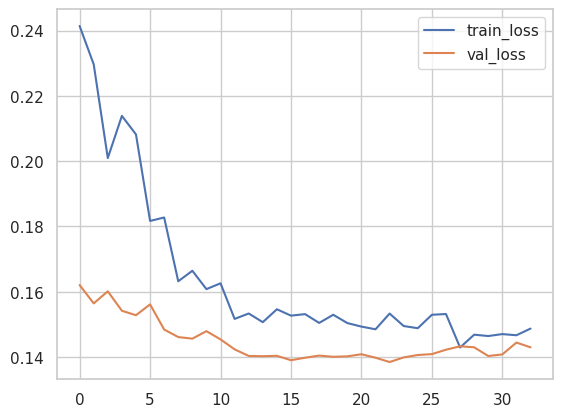

In [ ]:
# 15/8/23 - Lets go with this.
num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
batch_norm = True if best_hyperparameters['activation_fn'] == 'relu' else False
dropout = [best_hyperparameters['dropout']]

best_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

best_model = DeepHitSingle(best_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

batch_size = best_hyperparameters['batch_size']
best_model.optimizer.set_lr(best_hyperparameters['lr'])

# Train on the entire training set
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = best_model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
_ = log.plot()

# Evaluate on the test set
surv = best_model.predict_surv_df(x_test)
ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
c_index_test = ev_test.concordance_td('antolini')

print(f'Concordance index on test set: {c_index_test}')

# Calculate the integrated Brier score
ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))

print(f'Integrated Brier Score on test set: {ibs}')

In [ ]:
from sklearn.utils import resample

# Number of bootstrap iterations
n_bootstrap_iterations = 50

# Arrays to store bootstrap C-indices and IBS scores
bootstrap_c_indices_deephit = np.zeros(n_bootstrap_iterations)
bootstrap_ibs_scores_deep_hit = np.zeros(n_bootstrap_iterations)


for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample of indices
    bootstrap_indices = resample(np.arange(len(x_train)), replace=True)

    # Use these indices to create bootstrap samples
    bootstrap_train_x = x_train[bootstrap_indices]
    bootstrap_train_y_times = y_train[0][bootstrap_indices]
    bootstrap_train_y_events = y_train[1][bootstrap_indices]

    # 
    # Fit the model using the resampled training data with the best hyperparameters
    num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
    batch_norm = best_hyperparameters['batch_norm']
    dropout = best_hyperparameters['dropout']

    bootstrap_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    bootstrap_model = DeepHitSingle(bootstrap_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

    batch_size = best_hyperparameters['batch_size']
    bootstrap_model.optimizer.set_lr(best_hyperparameters['lr'])

    epochs = 100
    callbacks = [tt.callbacks.EarlyStopping(patience = best_hyperparameters['patience'])]
    log = bootstrap_model.fit(bootstrap_train_x, (bootstrap_train_y_times, bootstrap_train_y_events), batch_size, epochs, callbacks, val_data=val)

    # Evaluate on the test set
    surv = bootstrap_model.predict_surv_df(x_test)
    ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    c_index_test = ev_test.concordance_td('antolini')
    bootstrap_c_indices_deephit[i] = c_index_test

    # Calculate the integrated Brier score
    ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))
    bootstrap_ibs_scores_deep_hit[i] = ibs

# Compute the lower and upper percentiles for C-index
lower_percentile_c_index = np.percentile(bootstrap_c_indices_deephit, 2.5)
upper_percentile_c_index = np.percentile(bootstrap_c_indices_deephit, 97.5)

# Compute the lower and upper percentiles for IBS
lower_percentile_ibs = np.percentile(bootstrap_ibs_scores_deep_hit, 2.5)
upper_percentile_ibs = np.percentile(bootstrap_ibs_scores_deep_hit, 97.5)

print('Bootstrap 95% confidence interval for the C-index: ({:.2f}, {:.2f})'.format(lower_percentile_c_index, upper_percentile_c_index))
print('Bootstrap 95% confidence interval for the IBS: ({:.2f}, {:.2f})'.format(lower_percentile_ibs, upper_percentile_ibs))


0:	[0s / 0s],		train_loss: 0.2467,	val_loss: 0.1479
1:	[0s / 0s],		train_loss: 0.2121,	val_loss: 0.1447
2:	[0s / 0s],		train_loss: 0.1806,	val_loss: 0.1419
3:	[0s / 0s],		train_loss: 0.1708,	val_loss: 0.1410
4:	[0s / 1s],		train_loss: 0.1735,	val_loss: 0.1400
5:	[0s / 1s],		train_loss: 0.1663,	val_loss: 0.1422
6:	[0s / 1s],		train_loss: 0.1629,	val_loss: 0.1405
7:	[0s / 1s],		train_loss: 0.1635,	val_loss: 0.1408
8:	[0s / 1s],		train_loss: 0.1651,	val_loss: 0.1401
9:	[0s / 2s],		train_loss: 0.1627,	val_loss: 0.1407
10:	[0s / 2s],		train_loss: 0.1641,	val_loss: 0.1401
11:	[0s / 2s],		train_loss: 0.1653,	val_loss: 0.1408
12:	[0s / 2s],		train_loss: 0.1653,	val_loss: 0.1412
13:	[0s / 2s],		train_loss: 0.1679,	val_loss: 0.1410
14:	[0s / 2s],		train_loss: 0.1610,	val_loss: 0.1404
15:	[0s / 3s],		train_loss: 0.1650,	val_loss: 0.1409
16:	[0s / 3s],		train_loss: 0.1648,	val_loss: 0.1410
17:	[0s / 3s],		train_loss: 0.1629,	val_loss: 0.1409
18:	[0s / 3s],		train_loss: 0.1618,	val_loss: 0.1423
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2461,	val_loss: 0.1604
1:	[0s / 0s],		train_loss: 0.2071,	val_loss: 0.1459
2:	[0s / 0s],		train_loss: 0.1790,	val_loss: 0.1415
3:	[0s / 0s],		train_loss: 0.1599,	val_loss: 0.1405
4:	[0s / 0s],		train_loss: 0.1559,	val_loss: 0.1409
5:	[0s / 0s],		train_loss: 0.1560,	val_loss: 0.1406
6:	[0s / 0s],		train_loss: 0.1560,	val_loss: 0.1399
7:	[0s / 1s],		train_loss: 0.1521,	val_loss: 0.1405
8:	[0s / 1s],		train_loss: 0.1565,	val_loss: 0.1399
9:	[0s / 1s],		train_loss: 0.1531,	val_loss: 0.1410
10:	[0s / 1s],		train_loss: 0.1519,	val_loss: 0.1403
11:	[0s / 1s],		train_loss: 0.1517,	val_loss: 0.1404
12:	[0s / 1s],		train_loss: 0.1530,	val_loss: 0.1396
13:	[0s / 2s],		train_loss: 0.1487,	val_loss: 0.1411
14:	[0s / 2s],		train_loss: 0.1522,	val_loss: 0.1411
15:	[0s / 2s],		train_loss: 0.1509,	val_loss: 0.1401
16:	[0s / 2s],		train_loss: 0.1531,	val_loss: 0.1400
17:	[0s / 2s],		train_loss: 0.1581,	val_loss: 0.1410
18:	[0s / 2s],		train_loss: 0.1543,	val_loss: 0.1393
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2590,	val_loss: 0.1491
1:	[0s / 0s],		train_loss: 0.2067,	val_loss: 0.1453
2:	[0s / 0s],		train_loss: 0.1807,	val_loss: 0.1413
3:	[0s / 0s],		train_loss: 0.1703,	val_loss: 0.1412
4:	[0s / 1s],		train_loss: 0.1653,	val_loss: 0.1401
5:	[0s / 1s],		train_loss: 0.1614,	val_loss: 0.1408
6:	[0s / 1s],		train_loss: 0.1646,	val_loss: 0.1408
7:	[0s / 1s],		train_loss: 0.1627,	val_loss: 0.1412
8:	[0s / 1s],		train_loss: 0.1618,	val_loss: 0.1405
9:	[0s / 2s],		train_loss: 0.1660,	val_loss: 0.1408
10:	[0s / 2s],		train_loss: 0.1626,	val_loss: 0.1409
11:	[0s / 2s],		train_loss: 0.1611,	val_loss: 0.1401
12:	[0s / 2s],		train_loss: 0.1628,	val_loss: 0.1398
13:	[0s / 3s],		train_loss: 0.1621,	val_loss: 0.1411
14:	[0s / 3s],		train_loss: 0.1678,	val_loss: 0.1403
15:	[0s / 3s],		train_loss: 0.1646,	val_loss: 0.1409
16:	[0s / 4s],		train_loss: 0.1636,	val_loss: 0.1415
17:	[0s / 4s],		train_loss: 0.1618,	val_loss: 0.1395
18:	[0s / 4s],		train_loss: 0.1674,	val_loss: 0.1411
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2395,	val_loss: 0.1532
1:	[0s / 0s],		train_loss: 0.2051,	val_loss: 0.1464
2:	[0s / 0s],		train_loss: 0.1793,	val_loss: 0.1448
3:	[0s / 0s],		train_loss: 0.1681,	val_loss: 0.1417
4:	[0s / 0s],		train_loss: 0.1621,	val_loss: 0.1417
5:	[0s / 0s],		train_loss: 0.1664,	val_loss: 0.1403
6:	[0s / 0s],		train_loss: 0.1654,	val_loss: 0.1411
7:	[0s / 0s],		train_loss: 0.1613,	val_loss: 0.1413
8:	[0s / 0s],		train_loss: 0.1634,	val_loss: 0.1413
9:	[0s / 1s],		train_loss: 0.1583,	val_loss: 0.1415
10:	[0s / 1s],		train_loss: 0.1576,	val_loss: 0.1403
11:	[0s / 1s],		train_loss: 0.1568,	val_loss: 0.1418
12:	[0s / 1s],		train_loss: 0.1634,	val_loss: 0.1413
13:	[0s / 1s],		train_loss: 0.1554,	val_loss: 0.1425
14:	[0s / 1s],		train_loss: 0.1601,	val_loss: 0.1408
15:	[0s / 1s],		train_loss: 0.1618,	val_loss: 0.1406
16:	[0s / 1s],		train_loss: 0.1601,	val_loss: 0.1422
17:	[0s / 1s],		train_loss: 0.1621,	val_loss: 0.1401
18:	[0s / 2s],		train_loss: 0.1627,	val_loss: 0.1419
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2668,	val_loss: 0.1613
1:	[0s / 0s],		train_loss: 0.2123,	val_loss: 0.1542
2:	[0s / 0s],		train_loss: 0.1823,	val_loss: 0.1414
3:	[0s / 0s],		train_loss: 0.1701,	val_loss: 0.1434
4:	[0s / 0s],		train_loss: 0.1651,	val_loss: 0.1414
5:	[0s / 0s],		train_loss: 0.1640,	val_loss: 0.1433
6:	[0s / 0s],		train_loss: 0.1651,	val_loss: 0.1412
7:	[0s / 0s],		train_loss: 0.1631,	val_loss: 0.1419
8:	[0s / 0s],		train_loss: 0.1620,	val_loss: 0.1421
9:	[0s / 1s],		train_loss: 0.1699,	val_loss: 0.1425
10:	[0s / 1s],		train_loss: 0.1623,	val_loss: 0.1426
11:	[0s / 1s],		train_loss: 0.1699,	val_loss: 0.1411
12:	[0s / 1s],		train_loss: 0.1644,	val_loss: 0.1414
13:	[0s / 1s],		train_loss: 0.1617,	val_loss: 0.1412
14:	[0s / 1s],		train_loss: 0.1604,	val_loss: 0.1415
15:	[0s / 1s],		train_loss: 0.1643,	val_loss: 0.1413
16:	[0s / 1s],		train_loss: 0.1646,	val_loss: 0.1438
17:	[0s / 1s],		train_loss: 0.1663,	val_loss: 0.1407
18:	[0s / 2s],		train_loss: 0.1616,	val_loss: 0.1443
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2380,	val_loss: 0.1617
1:	[0s / 0s],		train_loss: 0.2120,	val_loss: 0.1418
2:	[0s / 0s],		train_loss: 0.1706,	val_loss: 0.1414
3:	[0s / 0s],		train_loss: 0.1558,	val_loss: 0.1427
4:	[0s / 0s],		train_loss: 0.1534,	val_loss: 0.1421
5:	[0s / 0s],		train_loss: 0.1510,	val_loss: 0.1425
6:	[0s / 0s],		train_loss: 0.1510,	val_loss: 0.1412
7:	[0s / 0s],		train_loss: 0.1519,	val_loss: 0.1416
8:	[0s / 0s],		train_loss: 0.1480,	val_loss: 0.1409
9:	[0s / 1s],		train_loss: 0.1486,	val_loss: 0.1424
10:	[0s / 1s],		train_loss: 0.1497,	val_loss: 0.1413
11:	[0s / 1s],		train_loss: 0.1504,	val_loss: 0.1416
12:	[0s / 1s],		train_loss: 0.1450,	val_loss: 0.1440
13:	[0s / 1s],		train_loss: 0.1480,	val_loss: 0.1430
14:	[0s / 1s],		train_loss: 0.1498,	val_loss: 0.1411
15:	[0s / 1s],		train_loss: 0.1471,	val_loss: 0.1420
16:	[0s / 1s],		train_loss: 0.1481,	val_loss: 0.1428
17:	[0s / 1s],		train_loss: 0.1471,	val_loss: 0.1413
18:	[0s / 2s],		train_loss: 0.1454,	val_loss: 0.1425
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2268,	val_loss: 0.1496
2:	[0s / 0s],		train_loss: 0.1947,	val_loss: 0.1404
3:	[0s / 0s],		train_loss: 0.1861,	val_loss: 0.1414
4:	[0s / 0s],		train_loss: 0.1775,	val_loss: 0.1400
5:	[0s / 0s],		train_loss: 0.1784,	val_loss: 0.1402
6:	[0s / 0s],		train_loss: 0.1784,	val_loss: 0.1397
7:	[0s / 0s],		train_loss: 0.1723,	val_loss: 0.1402
8:	[0s / 1s],		train_loss: 0.1720,	val_loss: 0.1395
9:	[0s / 1s],		train_loss: 0.1740,	val_loss: 0.1401
10:	[0s / 1s],		train_loss: 0.1755,	val_loss: 0.1398
11:	[0s / 1s],		train_loss: 0.1766,	val_loss: 0.1402
12:	[0s / 1s],		train_loss: 0.1721,	val_loss: 0.1406
13:	[0s / 1s],		train_loss: 0.1758,	val_loss: 0.1399
14:	[0s / 1s],		train_loss: 0.1718,	val_loss: 0.1413
15:	[0s / 1s],		train_loss: 0.1755,	val_loss: 0.1401
16:	[0s / 1s],		train_loss: 0.1748,	val_loss: 0.1396
17:	[0s / 1s],		train_loss: 0.1780,	val_loss: 0.1403
18:	[0s / 2s],		train_loss: 0.1755,	val_loss: 0.1406
19:	[0s / 2s],		train_loss: 0.1739,	val_loss: 0.1397
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2100,	val_loss: 0.1452
2:	[0s / 0s],		train_loss: 0.1846,	val_loss: 0.1414
3:	[0s / 0s],		train_loss: 0.1632,	val_loss: 0.1410
4:	[0s / 0s],		train_loss: 0.1610,	val_loss: 0.1412
5:	[0s / 0s],		train_loss: 0.1582,	val_loss: 0.1400
6:	[0s / 1s],		train_loss: 0.1575,	val_loss: 0.1410
7:	[0s / 1s],		train_loss: 0.1574,	val_loss: 0.1408
8:	[0s / 1s],		train_loss: 0.1563,	val_loss: 0.1411
9:	[0s / 1s],		train_loss: 0.1565,	val_loss: 0.1412
10:	[0s / 1s],		train_loss: 0.1573,	val_loss: 0.1412
11:	[0s / 1s],		train_loss: 0.1549,	val_loss: 0.1405
12:	[0s / 1s],		train_loss: 0.1563,	val_loss: 0.1400
13:	[0s / 2s],		train_loss: 0.1578,	val_loss: 0.1406
14:	[0s / 2s],		train_loss: 0.1566,	val_loss: 0.1398
15:	[0s / 2s],		train_loss: 0.1584,	val_loss: 0.1404
16:	[0s / 2s],		train_loss: 0.1593,	val_loss: 0.1414
17:	[0s / 2s],		train_loss: 0.1582,	val_loss: 0.1402
18:	[0s / 2s],		train_loss: 0.1607,	val_loss: 0.1415
19:	[0s / 3s],		train_loss: 0.1569,	val_loss: 0.1406
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2037,	val_loss: 0.1549
2:	[0s / 0s],		train_loss: 0.1694,	val_loss: 0.1439
3:	[0s / 0s],		train_loss: 0.1636,	val_loss: 0.1429
4:	[0s / 0s],		train_loss: 0.1561,	val_loss: 0.1409
5:	[0s / 0s],		train_loss: 0.1532,	val_loss: 0.1405
6:	[0s / 0s],		train_loss: 0.1526,	val_loss: 0.1409
7:	[0s / 0s],		train_loss: 0.1554,	val_loss: 0.1412
8:	[0s / 1s],		train_loss: 0.1507,	val_loss: 0.1404
9:	[0s / 1s],		train_loss: 0.1563,	val_loss: 0.1402
10:	[0s / 1s],		train_loss: 0.1547,	val_loss: 0.1403
11:	[0s / 1s],		train_loss: 0.1509,	val_loss: 0.1398
12:	[0s / 1s],		train_loss: 0.1518,	val_loss: 0.1406
13:	[0s / 1s],		train_loss: 0.1509,	val_loss: 0.1402
14:	[0s / 1s],		train_loss: 0.1538,	val_loss: 0.1403
15:	[0s / 1s],		train_loss: 0.1510,	val_loss: 0.1416
16:	[0s / 1s],		train_loss: 0.1595,	val_loss: 0.1408
17:	[0s / 2s],		train_loss: 0.1573,	val_loss: 0.1404
18:	[0s / 2s],		train_loss: 0.1560,	val_loss: 0.1412
19:	[0s / 2s],		train_loss: 0.1573,	val_loss: 0.1400
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2086,	val_loss: 0.1450
2:	[0s / 0s],		train_loss: 0.1675,	val_loss: 0.1422
3:	[0s / 0s],		train_loss: 0.1602,	val_loss: 0.1420
4:	[0s / 0s],		train_loss: 0.1535,	val_loss: 0.1410
5:	[0s / 0s],		train_loss: 0.1546,	val_loss: 0.1407
6:	[0s / 0s],		train_loss: 0.1587,	val_loss: 0.1406
7:	[0s / 0s],		train_loss: 0.1518,	val_loss: 0.1406
8:	[0s / 0s],		train_loss: 0.1547,	val_loss: 0.1412
9:	[0s / 1s],		train_loss: 0.1525,	val_loss: 0.1405
10:	[0s / 1s],		train_loss: 0.1565,	val_loss: 0.1402
11:	[0s / 1s],		train_loss: 0.1521,	val_loss: 0.1409
12:	[0s / 1s],		train_loss: 0.1545,	val_loss: 0.1404
13:	[0s / 1s],		train_loss: 0.1531,	val_loss: 0.1409
14:	[0s / 1s],		train_loss: 0.1537,	val_loss: 0.1416
15:	[0s / 1s],		train_loss: 0.1499,	val_loss: 0.1404
16:	[0s / 1s],		train_loss: 0.1499,	val_loss: 0.1406
17:	[0s / 1s],		train_loss: 0.1513,	val_loss: 0.1400
18:	[0s / 2s],		train_loss: 0.1519,	val_loss: 0.1409
19:	[0s / 2s],		train_loss: 0.1561,	val_loss: 0.1402
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2373,	val_loss: 0.1582
1:	[0s / 0s],		train_loss: 0.2143,	val_loss: 0.1450
2:	[0s / 0s],		train_loss: 0.1739,	val_loss: 0.1425
3:	[0s / 0s],		train_loss: 0.1571,	val_loss: 0.1422
4:	[0s / 0s],		train_loss: 0.1540,	val_loss: 0.1420
5:	[0s / 0s],		train_loss: 0.1526,	val_loss: 0.1427
6:	[0s / 0s],		train_loss: 0.1545,	val_loss: 0.1419
7:	[0s / 0s],		train_loss: 0.1520,	val_loss: 0.1435
8:	[0s / 0s],		train_loss: 0.1505,	val_loss: 0.1434
9:	[0s / 1s],		train_loss: 0.1492,	val_loss: 0.1413
10:	[0s / 1s],		train_loss: 0.1525,	val_loss: 0.1415
11:	[0s / 1s],		train_loss: 0.1512,	val_loss: 0.1422
12:	[0s / 1s],		train_loss: 0.1488,	val_loss: 0.1419
13:	[0s / 1s],		train_loss: 0.1522,	val_loss: 0.1419
14:	[0s / 1s],		train_loss: 0.1509,	val_loss: 0.1416
15:	[0s / 1s],		train_loss: 0.1491,	val_loss: 0.1431
16:	[0s / 2s],		train_loss: 0.1477,	val_loss: 0.1421
17:	[0s / 2s],		train_loss: 0.1509,	val_loss: 0.1405
18:	[0s / 2s],		train_loss: 0.1523,	val_loss: 0.1427
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.1953,	val_loss: 0.1406
2:	[0s / 0s],		train_loss: 0.1699,	val_loss: 0.1413
3:	[0s / 0s],		train_loss: 0.1566,	val_loss: 0.1408
4:	[0s / 0s],		train_loss: 0.1572,	val_loss: 0.1405
5:	[0s / 0s],		train_loss: 0.1500,	val_loss: 0.1399
6:	[0s / 0s],		train_loss: 0.1507,	val_loss: 0.1402
7:	[0s / 0s],		train_loss: 0.1526,	val_loss: 0.1395
8:	[0s / 0s],		train_loss: 0.1514,	val_loss: 0.1420
9:	[0s / 1s],		train_loss: 0.1527,	val_loss: 0.1412
10:	[0s / 1s],		train_loss: 0.1516,	val_loss: 0.1399
11:	[0s / 1s],		train_loss: 0.1540,	val_loss: 0.1402
12:	[0s / 1s],		train_loss: 0.1510,	val_loss: 0.1407
13:	[0s / 1s],		train_loss: 0.1532,	val_loss: 0.1398
14:	[0s / 1s],		train_loss: 0.1528,	val_loss: 0.1403
15:	[0s / 1s],		train_loss: 0.1508,	val_loss: 0.1410
16:	[0s / 1s],		train_loss: 0.1539,	val_loss: 0.1395
17:	[0s / 1s],		train_loss: 0.1485,	val_loss: 0.1416
18:	[0s / 2s],		train_loss: 0.1536,	val_loss: 0.1405
19:	[0s / 2s],		train_loss: 0.1547,	val_loss: 0.1412
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2160,	val_loss: 0.1435
2:	[0s / 0s],		train_loss: 0.1779,	val_loss: 0.1416
3:	[0s / 0s],		train_loss: 0.1673,	val_loss: 0.1421
4:	[0s / 0s],		train_loss: 0.1704,	val_loss: 0.1456
5:	[0s / 0s],		train_loss: 0.1635,	val_loss: 0.1429
6:	[0s / 1s],		train_loss: 0.1610,	val_loss: 0.1400
7:	[0s / 1s],		train_loss: 0.1629,	val_loss: 0.1413
8:	[0s / 1s],		train_loss: 0.1609,	val_loss: 0.1400
9:	[0s / 1s],		train_loss: 0.1618,	val_loss: 0.1405
10:	[0s / 1s],		train_loss: 0.1630,	val_loss: 0.1408
11:	[0s / 1s],		train_loss: 0.1613,	val_loss: 0.1421
12:	[0s / 2s],		train_loss: 0.1606,	val_loss: 0.1430
13:	[0s / 2s],		train_loss: 0.1617,	val_loss: 0.1413
14:	[0s / 2s],		train_loss: 0.1645,	val_loss: 0.1396
15:	[0s / 2s],		train_loss: 0.1613,	val_loss: 0.1403
16:	[0s / 2s],		train_loss: 0.1650,	val_loss: 0.1415
17:	[0s / 2s],		train_loss: 0.1608,	val_loss: 0.1415
18:	[0s / 2s],		train_loss: 0.1640,	val_loss: 0.1411
19:	[0s / 2s],		train_loss: 0.1602,	val_loss: 0.1402
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.1929,	val_loss: 0.1472
2:	[0s / 0s],		train_loss: 0.1614,	val_loss: 0.1405
3:	[0s / 0s],		train_loss: 0.1521,	val_loss: 0.1407
4:	[0s / 0s],		train_loss: 0.1474,	val_loss: 0.1404
5:	[0s / 0s],		train_loss: 0.1447,	val_loss: 0.1398
6:	[0s / 0s],		train_loss: 0.1441,	val_loss: 0.1406
7:	[0s / 0s],		train_loss: 0.1456,	val_loss: 0.1405
8:	[0s / 1s],		train_loss: 0.1480,	val_loss: 0.1414
9:	[0s / 1s],		train_loss: 0.1451,	val_loss: 0.1399
10:	[0s / 1s],		train_loss: 0.1469,	val_loss: 0.1398
11:	[0s / 1s],		train_loss: 0.1451,	val_loss: 0.1398
12:	[0s / 1s],		train_loss: 0.1452,	val_loss: 0.1406
13:	[0s / 1s],		train_loss: 0.1410,	val_loss: 0.1411
14:	[0s / 1s],		train_loss: 0.1428,	val_loss: 0.1410
15:	[0s / 2s],		train_loss: 0.1437,	val_loss: 0.1402
16:	[0s / 2s],		train_loss: 0.1433,	val_loss: 0.1396
17:	[0s / 2s],		train_loss: 0.1418,	val_loss: 0.1405
18:	[0s / 2s],		train_loss: 0.1462,	val_loss: 0.1392
19:	[0s / 2s],		train_loss: 0.1459,	val_loss: 0.1414
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2472,	val_loss: 0.1438
1:	[0s / 0s],		train_loss: 0.2223,	val_loss: 0.1477
2:	[0s / 0s],		train_loss: 0.1824,	val_loss: 0.1424
3:	[0s / 0s],		train_loss: 0.1711,	val_loss: 0.1408
4:	[0s / 0s],		train_loss: 0.1673,	val_loss: 0.1413
5:	[0s / 0s],		train_loss: 0.1614,	val_loss: 0.1420
6:	[0s / 0s],		train_loss: 0.1647,	val_loss: 0.1406
7:	[0s / 0s],		train_loss: 0.1619,	val_loss: 0.1409
8:	[0s / 0s],		train_loss: 0.1649,	val_loss: 0.1402
9:	[0s / 1s],		train_loss: 0.1625,	val_loss: 0.1409
10:	[0s / 1s],		train_loss: 0.1645,	val_loss: 0.1403
11:	[0s / 1s],		train_loss: 0.1641,	val_loss: 0.1417
12:	[0s / 1s],		train_loss: 0.1640,	val_loss: 0.1404
13:	[0s / 1s],		train_loss: 0.1638,	val_loss: 0.1423
14:	[0s / 1s],		train_loss: 0.1626,	val_loss: 0.1397
15:	[0s / 1s],		train_loss: 0.1648,	val_loss: 0.1410
16:	[0s / 1s],		train_loss: 0.1627,	val_loss: 0.1406
17:	[0s / 1s],		train_loss: 0.1606,	val_loss: 0.1405
18:	[0s / 2s],		train_loss: 0.1629,	val_loss: 0.1407
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2455,	val_loss: 0.1620
1:	[0s / 0s],		train_loss: 0.2213,	val_loss: 0.1478
2:	[0s / 0s],		train_loss: 0.1796,	val_loss: 0.1426
3:	[0s / 0s],		train_loss: 0.1680,	val_loss: 0.1422
4:	[0s / 0s],		train_loss: 0.1656,	val_loss: 0.1404
5:	[0s / 0s],		train_loss: 0.1615,	val_loss: 0.1412
6:	[0s / 0s],		train_loss: 0.1627,	val_loss: 0.1416
7:	[0s / 0s],		train_loss: 0.1612,	val_loss: 0.1407
8:	[0s / 0s],		train_loss: 0.1602,	val_loss: 0.1404
9:	[0s / 1s],		train_loss: 0.1628,	val_loss: 0.1409
10:	[0s / 1s],		train_loss: 0.1637,	val_loss: 0.1425
11:	[0s / 1s],		train_loss: 0.1589,	val_loss: 0.1399
12:	[0s / 1s],		train_loss: 0.1605,	val_loss: 0.1417
13:	[0s / 1s],		train_loss: 0.1614,	val_loss: 0.1414
14:	[0s / 1s],		train_loss: 0.1617,	val_loss: 0.1424
15:	[0s / 1s],		train_loss: 0.1609,	val_loss: 0.1431
16:	[0s / 1s],		train_loss: 0.1618,	val_loss: 0.1399
17:	[0s / 1s],		train_loss: 0.1638,	val_loss: 0.1426
18:	[0s / 2s],		train_loss: 0.1660,	val_loss: 0.1400
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2192,	val_loss: 0.1424
2:	[0s / 0s],		train_loss: 0.1828,	val_loss: 0.1424
3:	[0s / 0s],		train_loss: 0.1726,	val_loss: 0.1414
4:	[0s / 0s],		train_loss: 0.1643,	val_loss: 0.1413
5:	[0s / 0s],		train_loss: 0.1702,	val_loss: 0.1419
6:	[0s / 0s],		train_loss: 0.1680,	val_loss: 0.1406
7:	[0s / 0s],		train_loss: 0.1675,	val_loss: 0.1403
8:	[0s / 0s],		train_loss: 0.1696,	val_loss: 0.1411
9:	[0s / 1s],		train_loss: 0.1669,	val_loss: 0.1409
10:	[0s / 1s],		train_loss: 0.1632,	val_loss: 0.1408
11:	[0s / 1s],		train_loss: 0.1625,	val_loss: 0.1418
12:	[0s / 1s],		train_loss: 0.1675,	val_loss: 0.1427
13:	[0s / 1s],		train_loss: 0.1650,	val_loss: 0.1414
14:	[0s / 1s],		train_loss: 0.1665,	val_loss: 0.1406
15:	[0s / 1s],		train_loss: 0.1700,	val_loss: 0.1406
16:	[0s / 1s],		train_loss: 0.1643,	val_loss: 0.1411
17:	[0s / 1s],		train_loss: 0.1688,	val_loss: 0.1415
18:	[0s / 2s],		train_loss: 0.1665,	val_loss: 0.1406
19:	[0s / 2s],		train_loss: 0.1638,	val_loss: 0.1406
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2237,	val_loss: 0.1453
2:	[0s / 0s],		train_loss: 0.1824,	val_loss: 0.1415
3:	[0s / 0s],		train_loss: 0.1737,	val_loss: 0.1414
4:	[0s / 0s],		train_loss: 0.1679,	val_loss: 0.1412
5:	[0s / 0s],		train_loss: 0.1622,	val_loss: 0.1417
6:	[0s / 1s],		train_loss: 0.1611,	val_loss: 0.1416
7:	[0s / 1s],		train_loss: 0.1658,	val_loss: 0.1403
8:	[0s / 1s],		train_loss: 0.1646,	val_loss: 0.1403
9:	[0s / 1s],		train_loss: 0.1613,	val_loss: 0.1420
10:	[0s / 1s],		train_loss: 0.1659,	val_loss: 0.1410
11:	[0s / 1s],		train_loss: 0.1609,	val_loss: 0.1398
12:	[0s / 1s],		train_loss: 0.1604,	val_loss: 0.1424
13:	[0s / 2s],		train_loss: 0.1665,	val_loss: 0.1403
14:	[0s / 2s],		train_loss: 0.1636,	val_loss: 0.1398
15:	[0s / 2s],		train_loss: 0.1643,	val_loss: 0.1417
16:	[0s / 2s],		train_loss: 0.1637,	val_loss: 0.1400
17:	[0s / 2s],		train_loss: 0.1636,	val_loss: 0.1412
18:	[0s / 2s],		train_loss: 0.1650,	val_loss: 0.1407
19:	[0s / 2s],		train_loss: 0.1644,	val_loss: 0.1412
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2360,	val_loss: 0.1585
1:	[0s / 0s],		train_loss: 0.2136,	val_loss: 0.1445
2:	[0s / 0s],		train_loss: 0.1667,	val_loss: 0.1424
3:	[0s / 0s],		train_loss: 0.1582,	val_loss: 0.1411
4:	[0s / 0s],		train_loss: 0.1587,	val_loss: 0.1415
5:	[0s / 0s],		train_loss: 0.1575,	val_loss: 0.1408
6:	[0s / 0s],		train_loss: 0.1548,	val_loss: 0.1415
7:	[0s / 0s],		train_loss: 0.1557,	val_loss: 0.1415
8:	[0s / 0s],		train_loss: 0.1566,	val_loss: 0.1404
9:	[0s / 1s],		train_loss: 0.1531,	val_loss: 0.1414
10:	[0s / 1s],		train_loss: 0.1562,	val_loss: 0.1409
11:	[0s / 1s],		train_loss: 0.1538,	val_loss: 0.1407
12:	[0s / 1s],		train_loss: 0.1607,	val_loss: 0.1417
13:	[0s / 1s],		train_loss: 0.1602,	val_loss: 0.1400
14:	[0s / 1s],		train_loss: 0.1574,	val_loss: 0.1418
15:	[0s / 1s],		train_loss: 0.1559,	val_loss: 0.1407
16:	[0s / 1s],		train_loss: 0.1500,	val_loss: 0.1404
17:	[0s / 1s],		train_loss: 0.1503,	val_loss: 0.1410
18:	[0s / 2s],		train_loss: 0.1554,	val_loss: 0.1415
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2330,	val_loss: 0.1637
1:	[0s / 0s],		train_loss: 0.2079,	val_loss: 0.1412
2:	[0s / 0s],		train_loss: 0.1719,	val_loss: 0.1416
3:	[0s / 0s],		train_loss: 0.1596,	val_loss: 0.1406
4:	[0s / 0s],		train_loss: 0.1580,	val_loss: 0.1408
5:	[0s / 0s],		train_loss: 0.1523,	val_loss: 0.1433
6:	[0s / 0s],		train_loss: 0.1574,	val_loss: 0.1411
7:	[0s / 0s],		train_loss: 0.1515,	val_loss: 0.1412
8:	[0s / 0s],		train_loss: 0.1540,	val_loss: 0.1407
9:	[0s / 1s],		train_loss: 0.1512,	val_loss: 0.1411
10:	[0s / 1s],		train_loss: 0.1525,	val_loss: 0.1403
11:	[0s / 1s],		train_loss: 0.1561,	val_loss: 0.1397
12:	[0s / 1s],		train_loss: 0.1524,	val_loss: 0.1405
13:	[0s / 1s],		train_loss: 0.1493,	val_loss: 0.1395
14:	[0s / 1s],		train_loss: 0.1522,	val_loss: 0.1403
15:	[0s / 1s],		train_loss: 0.1519,	val_loss: 0.1393
16:	[0s / 1s],		train_loss: 0.1524,	val_loss: 0.1403
17:	[0s / 1s],		train_loss: 0.1567,	val_loss: 0.1401
18:	[0s / 1s],		train_loss: 0.1523,	val_loss: 0.1401
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2083,	val_loss: 0.1469
2:	[0s / 0s],		train_loss: 0.1751,	val_loss: 0.1423
3:	[0s / 0s],		train_loss: 0.1569,	val_loss: 0.1412
4:	[0s / 0s],		train_loss: 0.1614,	val_loss: 0.1408
5:	[0s / 0s],		train_loss: 0.1552,	val_loss: 0.1400
6:	[0s / 0s],		train_loss: 0.1530,	val_loss: 0.1414
7:	[0s / 0s],		train_loss: 0.1531,	val_loss: 0.1409
8:	[0s / 0s],		train_loss: 0.1548,	val_loss: 0.1411
9:	[0s / 1s],		train_loss: 0.1538,	val_loss: 0.1418
10:	[0s / 1s],		train_loss: 0.1489,	val_loss: 0.1408
11:	[0s / 1s],		train_loss: 0.1521,	val_loss: 0.1406
12:	[0s / 1s],		train_loss: 0.1509,	val_loss: 0.1400
13:	[0s / 1s],		train_loss: 0.1512,	val_loss: 0.1417
14:	[0s / 1s],		train_loss: 0.1538,	val_loss: 0.1399
15:	[0s / 1s],		train_loss: 0.1547,	val_loss: 0.1415
16:	[0s / 1s],		train_loss: 0.1540,	val_loss: 0.1407
17:	[0s / 1s],		train_loss: 0.1519,	val_loss: 0.1421
18:	[0s / 1s],		train_loss: 0.1520,	val_loss: 0.1406
19:	[0s / 2s],		train_loss: 0.1551,	val_loss: 0.1404
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.1845,	val_loss: 0.1515
2:	[0s / 0s],		train_loss: 0.1561,	val_loss: 0.1461
3:	[0s / 0s],		train_loss: 0.1515,	val_loss: 0.1406
4:	[0s / 0s],		train_loss: 0.1469,	val_loss: 0.1399
5:	[0s / 0s],		train_loss: 0.1435,	val_loss: 0.1401
6:	[0s / 1s],		train_loss: 0.1392,	val_loss: 0.1405
7:	[0s / 1s],		train_loss: 0.1435,	val_loss: 0.1400
8:	[0s / 1s],		train_loss: 0.1398,	val_loss: 0.1418
9:	[0s / 1s],		train_loss: 0.1417,	val_loss: 0.1401
10:	[0s / 1s],		train_loss: 0.1407,	val_loss: 0.1411
11:	[0s / 1s],		train_loss: 0.1431,	val_loss: 0.1402
12:	[0s / 1s],		train_loss: 0.1433,	val_loss: 0.1409
13:	[0s / 1s],		train_loss: 0.1426,	val_loss: 0.1413
14:	[0s / 2s],		train_loss: 0.1466,	val_loss: 0.1413
15:	[0s / 2s],		train_loss: 0.1415,	val_loss: 0.1413
16:	[0s / 2s],		train_loss: 0.1465,	val_loss: 0.1401
17:	[0s / 2s],		train_loss: 0.1436,	val_loss: 0.1407
18:	[0s / 2s],		train_loss: 0.1398,	val_loss: 0.1407
19:	[0s / 2s],		train_loss: 0.1432,	val_loss: 0.1412
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2534,	val_loss: 0.1510
1:	[0s / 0s],		train_loss: 0.2084,	val_loss: 0.1450
2:	[0s / 0s],		train_loss: 0.1802,	val_loss: 0.1405
3:	[0s / 0s],		train_loss: 0.1634,	val_loss: 0.1420
4:	[0s / 0s],		train_loss: 0.1670,	val_loss: 0.1409
5:	[0s / 0s],		train_loss: 0.1637,	val_loss: 0.1402
6:	[0s / 0s],		train_loss: 0.1612,	val_loss: 0.1410
7:	[0s / 1s],		train_loss: 0.1613,	val_loss: 0.1424
8:	[0s / 1s],		train_loss: 0.1619,	val_loss: 0.1401
9:	[0s / 1s],		train_loss: 0.1611,	val_loss: 0.1409
10:	[0s / 1s],		train_loss: 0.1617,	val_loss: 0.1402
11:	[0s / 1s],		train_loss: 0.1590,	val_loss: 0.1411
12:	[0s / 1s],		train_loss: 0.1626,	val_loss: 0.1399
13:	[0s / 1s],		train_loss: 0.1613,	val_loss: 0.1406
14:	[0s / 2s],		train_loss: 0.1611,	val_loss: 0.1408
15:	[0s / 2s],		train_loss: 0.1588,	val_loss: 0.1410
16:	[0s / 2s],		train_loss: 0.1634,	val_loss: 0.1397
17:	[0s / 2s],		train_loss: 0.1598,	val_loss: 0.1401
18:	[0s / 2s],		train_loss: 0.1614,	val_loss: 0.1409
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2331,	val_loss: 0.1535
1:	[0s / 0s],		train_loss: 0.1857,	val_loss: 0.1430
2:	[0s / 0s],		train_loss: 0.1598,	val_loss: 0.1428
3:	[0s / 0s],		train_loss: 0.1513,	val_loss: 0.1414
4:	[0s / 0s],		train_loss: 0.1442,	val_loss: 0.1402
5:	[0s / 0s],		train_loss: 0.1415,	val_loss: 0.1421
6:	[0s / 0s],		train_loss: 0.1440,	val_loss: 0.1404
7:	[0s / 0s],		train_loss: 0.1414,	val_loss: 0.1411
8:	[0s / 0s],		train_loss: 0.1406,	val_loss: 0.1401
9:	[0s / 1s],		train_loss: 0.1425,	val_loss: 0.1403
10:	[0s / 1s],		train_loss: 0.1411,	val_loss: 0.1400
11:	[0s / 1s],		train_loss: 0.1419,	val_loss: 0.1411
12:	[0s / 1s],		train_loss: 0.1418,	val_loss: 0.1402
13:	[0s / 1s],		train_loss: 0.1432,	val_loss: 0.1405
14:	[0s / 1s],		train_loss: 0.1418,	val_loss: 0.1417
15:	[0s / 1s],		train_loss: 0.1441,	val_loss: 0.1405
16:	[0s / 1s],		train_loss: 0.1463,	val_loss: 0.1400
17:	[0s / 1s],		train_loss: 0.1473,	val_loss: 0.1428
18:	[0s / 2s],		train_loss: 0.1435,	val_loss: 0.1428
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2314,	val_loss: 0.1597
1:	[0s / 0s],		train_loss: 0.1911,	val_loss: 0.1458
2:	[0s / 0s],		train_loss: 0.1653,	val_loss: 0.1408
3:	[0s / 0s],		train_loss: 0.1489,	val_loss: 0.1422
4:	[0s / 0s],		train_loss: 0.1425,	val_loss: 0.1423
5:	[0s / 0s],		train_loss: 0.1414,	val_loss: 0.1404
6:	[0s / 0s],		train_loss: 0.1386,	val_loss: 0.1420
7:	[0s / 0s],		train_loss: 0.1424,	val_loss: 0.1405
8:	[0s / 0s],		train_loss: 0.1460,	val_loss: 0.1412
9:	[0s / 1s],		train_loss: 0.1440,	val_loss: 0.1408
10:	[0s / 1s],		train_loss: 0.1447,	val_loss: 0.1402
11:	[0s / 1s],		train_loss: 0.1422,	val_loss: 0.1406
12:	[0s / 1s],		train_loss: 0.1403,	val_loss: 0.1420
13:	[0s / 1s],		train_loss: 0.1401,	val_loss: 0.1408
14:	[0s / 1s],		train_loss: 0.1433,	val_loss: 0.1423
15:	[0s / 1s],		train_loss: 0.1426,	val_loss: 0.1420
16:	[0s / 1s],		train_loss: 0.1394,	val_loss: 0.1421
17:	[0s / 1s],		train_loss: 0.1402,	val_loss: 0.1430
18:	[0s / 1s],		train_loss: 0.1414,	val_loss: 0.1412
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2430,	val_loss: 0.1465
2:	[0s / 0s],		train_loss: 0.1972,	val_loss: 0.1417
3:	[0s / 0s],		train_loss: 0.1769,	val_loss: 0.1426
4:	[0s / 0s],		train_loss: 0.1757,	val_loss: 0.1430
5:	[0s / 0s],		train_loss: 0.1701,	val_loss: 0.1414
6:	[0s / 0s],		train_loss: 0.1712,	val_loss: 0.1418
7:	[0s / 0s],		train_loss: 0.1684,	val_loss: 0.1422
8:	[0s / 0s],		train_loss: 0.1700,	val_loss: 0.1432
9:	[0s / 1s],		train_loss: 0.1719,	val_loss: 0.1417
10:	[0s / 1s],		train_loss: 0.1670,	val_loss: 0.1421
11:	[0s / 1s],		train_loss: 0.1673,	val_loss: 0.1410
12:	[0s / 1s],		train_loss: 0.1779,	val_loss: 0.1419
13:	[0s / 1s],		train_loss: 0.1714,	val_loss: 0.1421
14:	[0s / 1s],		train_loss: 0.1714,	val_loss: 0.1416
15:	[0s / 1s],		train_loss: 0.1695,	val_loss: 0.1421
16:	[0s / 1s],		train_loss: 0.1676,	val_loss: 0.1415
17:	[0s / 1s],		train_loss: 0.1696,	val_loss: 0.1428
18:	[0s / 2s],		train_loss: 0.1701,	val_loss: 0.1410
19:	[0s / 2s],		train_loss: 0.1708,	val_loss: 0.1425
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2081,	val_loss: 0.1397
2:	[0s / 0s],		train_loss: 0.1726,	val_loss: 0.1422
3:	[0s / 0s],		train_loss: 0.1606,	val_loss: 0.1408
4:	[0s / 0s],		train_loss: 0.1616,	val_loss: 0.1404
5:	[0s / 0s],		train_loss: 0.1601,	val_loss: 0.1409
6:	[0s / 1s],		train_loss: 0.1573,	val_loss: 0.1406
7:	[0s / 1s],		train_loss: 0.1539,	val_loss: 0.1412
8:	[0s / 1s],		train_loss: 0.1559,	val_loss: 0.1416
9:	[0s / 1s],		train_loss: 0.1599,	val_loss: 0.1405
10:	[0s / 1s],		train_loss: 0.1565,	val_loss: 0.1404
11:	[0s / 1s],		train_loss: 0.1553,	val_loss: 0.1397
12:	[0s / 1s],		train_loss: 0.1584,	val_loss: 0.1404
13:	[0s / 2s],		train_loss: 0.1587,	val_loss: 0.1409
14:	[0s / 2s],		train_loss: 0.1597,	val_loss: 0.1418
15:	[0s / 2s],		train_loss: 0.1546,	val_loss: 0.1398
16:	[0s / 2s],		train_loss: 0.1632,	val_loss: 0.1394
17:	[0s / 2s],		train_loss: 0.1574,	val_loss: 0.1404
18:	[0s / 2s],		train_loss: 0.1583,	val_loss: 0.1402
19:	[0s / 2s],		train_loss: 0.1594,	val_loss: 0.1403
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2279,	val_loss: 0.1455
2:	[0s / 0s],		train_loss: 0.1765,	val_loss: 0.1422
3:	[0s / 0s],		train_loss: 0.1730,	val_loss: 0.1423
4:	[0s / 0s],		train_loss: 0.1630,	val_loss: 0.1421
5:	[0s / 0s],		train_loss: 0.1648,	val_loss: 0.1411
6:	[0s / 0s],		train_loss: 0.1648,	val_loss: 0.1413
7:	[0s / 0s],		train_loss: 0.1590,	val_loss: 0.1428
8:	[0s / 0s],		train_loss: 0.1638,	val_loss: 0.1413
9:	[0s / 1s],		train_loss: 0.1666,	val_loss: 0.1421
10:	[0s / 1s],		train_loss: 0.1629,	val_loss: 0.1415
11:	[0s / 1s],		train_loss: 0.1641,	val_loss: 0.1409
12:	[0s / 1s],		train_loss: 0.1677,	val_loss: 0.1410
13:	[0s / 1s],		train_loss: 0.1679,	val_loss: 0.1418
14:	[0s / 1s],		train_loss: 0.1650,	val_loss: 0.1429
15:	[0s / 1s],		train_loss: 0.1640,	val_loss: 0.1417
16:	[0s / 2s],		train_loss: 0.1624,	val_loss: 0.1423
17:	[0s / 2s],		train_loss: 0.1630,	val_loss: 0.1423
18:	[0s / 2s],		train_loss: 0.1640,	val_loss: 0.1415
19:	[0s / 2s],		train_loss: 0.1645,	val_loss: 0.1426
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2293,	val_loss: 0.1554
1:	[0s / 0s],		train_loss: 0.2028,	val_loss: 0.1428
2:	[0s / 0s],		train_loss: 0.1630,	val_loss: 0.1421
3:	[0s / 0s],		train_loss: 0.1561,	val_loss: 0.1403
4:	[0s / 0s],		train_loss: 0.1479,	val_loss: 0.1417
5:	[0s / 0s],		train_loss: 0.1496,	val_loss: 0.1405
6:	[0s / 0s],		train_loss: 0.1486,	val_loss: 0.1400
7:	[0s / 0s],		train_loss: 0.1483,	val_loss: 0.1406
8:	[0s / 0s],		train_loss: 0.1530,	val_loss: 0.1404
9:	[0s / 1s],		train_loss: 0.1434,	val_loss: 0.1421
10:	[0s / 1s],		train_loss: 0.1449,	val_loss: 0.1427
11:	[0s / 1s],		train_loss: 0.1456,	val_loss: 0.1407
12:	[0s / 1s],		train_loss: 0.1470,	val_loss: 0.1395
13:	[0s / 1s],		train_loss: 0.1461,	val_loss: 0.1411
14:	[0s / 1s],		train_loss: 0.1473,	val_loss: 0.1398
15:	[0s / 1s],		train_loss: 0.1497,	val_loss: 0.1408
16:	[0s / 1s],		train_loss: 0.1456,	val_loss: 0.1412
17:	[0s / 1s],		train_loss: 0.1452,	val_loss: 0.1399
18:	[0s / 1s],		train_loss: 0.1471,	val_loss: 0.1402
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2474,	val_loss: 0.1589
1:	[0s / 0s],		train_loss: 0.2268,	val_loss: 0.1458
2:	[0s / 0s],		train_loss: 0.1736,	val_loss: 0.1413
3:	[0s / 0s],		train_loss: 0.1648,	val_loss: 0.1401
4:	[0s / 0s],		train_loss: 0.1674,	val_loss: 0.1403
5:	[0s / 0s],		train_loss: 0.1616,	val_loss: 0.1408
6:	[0s / 0s],		train_loss: 0.1584,	val_loss: 0.1404
7:	[0s / 0s],		train_loss: 0.1623,	val_loss: 0.1411
8:	[0s / 0s],		train_loss: 0.1646,	val_loss: 0.1399
9:	[0s / 1s],		train_loss: 0.1589,	val_loss: 0.1404
10:	[0s / 1s],		train_loss: 0.1615,	val_loss: 0.1400
11:	[0s / 1s],		train_loss: 0.1603,	val_loss: 0.1404
12:	[0s / 1s],		train_loss: 0.1595,	val_loss: 0.1404
13:	[0s / 1s],		train_loss: 0.1625,	val_loss: 0.1396
14:	[0s / 1s],		train_loss: 0.1613,	val_loss: 0.1403
15:	[0s / 1s],		train_loss: 0.1563,	val_loss: 0.1401
16:	[0s / 1s],		train_loss: 0.1625,	val_loss: 0.1393
17:	[0s / 1s],		train_loss: 0.1582,	val_loss: 0.1392
18:	[0s / 2s],		train_loss: 0.1638,	val_loss: 0.1393
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2355,	val_loss: 0.1587
1:	[0s / 0s],		train_loss: 0.1964,	val_loss: 0.1411
2:	[0s / 0s],		train_loss: 0.1717,	val_loss: 0.1458
3:	[0s / 0s],		train_loss: 0.1577,	val_loss: 0.1418
4:	[0s / 0s],		train_loss: 0.1550,	val_loss: 0.1416
5:	[0s / 0s],		train_loss: 0.1529,	val_loss: 0.1427
6:	[0s / 1s],		train_loss: 0.1536,	val_loss: 0.1412
7:	[0s / 1s],		train_loss: 0.1549,	val_loss: 0.1412
8:	[0s / 1s],		train_loss: 0.1552,	val_loss: 0.1416
9:	[0s / 1s],		train_loss: 0.1541,	val_loss: 0.1420
10:	[0s / 1s],		train_loss: 0.1528,	val_loss: 0.1407
11:	[0s / 1s],		train_loss: 0.1510,	val_loss: 0.1419
12:	[0s / 1s],		train_loss: 0.1503,	val_loss: 0.1406
13:	[0s / 2s],		train_loss: 0.1544,	val_loss: 0.1413
14:	[0s / 2s],		train_loss: 0.1494,	val_loss: 0.1408
15:	[0s / 2s],		train_loss: 0.1512,	val_loss: 0.1402
16:	[0s / 2s],		train_loss: 0.1521,	val_loss: 0.1417
17:	[0s / 2s],		train_loss: 0.1538,	val_loss: 0.1403
18:	[0s / 2s],		train_loss: 0.1532,	val_loss: 0.1424
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2189,	val_loss: 0.1677
1:	[0s / 0s],		train_loss: 0.2007,	val_loss: 0.1443
2:	[0s / 0s],		train_loss: 0.1595,	val_loss: 0.1422
3:	[0s / 0s],		train_loss: 0.1507,	val_loss: 0.1424
4:	[0s / 0s],		train_loss: 0.1403,	val_loss: 0.1421
5:	[0s / 0s],		train_loss: 0.1432,	val_loss: 0.1410
6:	[0s / 1s],		train_loss: 0.1455,	val_loss: 0.1414
7:	[0s / 1s],		train_loss: 0.1455,	val_loss: 0.1411
8:	[0s / 1s],		train_loss: 0.1401,	val_loss: 0.1405
9:	[0s / 1s],		train_loss: 0.1393,	val_loss: 0.1417
10:	[0s / 1s],		train_loss: 0.1437,	val_loss: 0.1414
11:	[0s / 1s],		train_loss: 0.1435,	val_loss: 0.1407
12:	[0s / 1s],		train_loss: 0.1401,	val_loss: 0.1415
13:	[0s / 2s],		train_loss: 0.1423,	val_loss: 0.1404
14:	[0s / 2s],		train_loss: 0.1423,	val_loss: 0.1426
15:	[0s / 2s],		train_loss: 0.1406,	val_loss: 0.1410
16:	[0s / 2s],		train_loss: 0.1428,	val_loss: 0.1413
17:	[0s / 2s],		train_loss: 0.1418,	val_loss: 0.1405
18:	[0s / 2s],		train_loss: 0.1439,	val_loss: 0.1404
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2181,	val_loss: 0.1428
2:	[0s / 0s],		train_loss: 0.1717,	val_loss: 0.1429
3:	[0s / 0s],		train_loss: 0.1680,	val_loss: 0.1416
4:	[0s / 0s],		train_loss: 0.1662,	val_loss: 0.1412
5:	[0s / 0s],		train_loss: 0.1596,	val_loss: 0.1407
6:	[0s / 0s],		train_loss: 0.1643,	val_loss: 0.1412
7:	[0s / 0s],		train_loss: 0.1625,	val_loss: 0.1407
8:	[0s / 0s],		train_loss: 0.1629,	val_loss: 0.1415
9:	[0s / 1s],		train_loss: 0.1640,	val_loss: 0.1407
10:	[0s / 1s],		train_loss: 0.1581,	val_loss: 0.1424
11:	[0s / 1s],		train_loss: 0.1594,	val_loss: 0.1411
12:	[0s / 1s],		train_loss: 0.1590,	val_loss: 0.1413
13:	[0s / 1s],		train_loss: 0.1601,	val_loss: 0.1413
14:	[0s / 1s],		train_loss: 0.1622,	val_loss: 0.1418
15:	[0s / 1s],		train_loss: 0.1628,	val_loss: 0.1408
16:	[0s / 1s],		train_loss: 0.1572,	val_loss: 0.1414
17:	[0s / 1s],		train_loss: 0.1615,	val_loss: 0.1413
18:	[0s / 2s],		train_loss: 0.1612,	val_loss: 0.1412
19:	[0s / 2s],		train_loss: 0.1620,	val_loss: 0.1436
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2625,	val_loss: 0.1708
1:	[0s / 0s],		train_loss: 0.2229,	val_loss: 0.1424
2:	[0s / 0s],		train_loss: 0.1813,	val_loss: 0.1413
3:	[0s / 0s],		train_loss: 0.1742,	val_loss: 0.1408
4:	[0s / 0s],		train_loss: 0.1692,	val_loss: 0.1401
5:	[0s / 0s],		train_loss: 0.1678,	val_loss: 0.1413
6:	[0s / 0s],		train_loss: 0.1660,	val_loss: 0.1408
7:	[0s / 0s],		train_loss: 0.1644,	val_loss: 0.1401
8:	[0s / 0s],		train_loss: 0.1643,	val_loss: 0.1406
9:	[0s / 1s],		train_loss: 0.1723,	val_loss: 0.1402
10:	[0s / 1s],		train_loss: 0.1647,	val_loss: 0.1404
11:	[0s / 1s],		train_loss: 0.1645,	val_loss: 0.1397
12:	[0s / 1s],		train_loss: 0.1687,	val_loss: 0.1401
13:	[0s / 1s],		train_loss: 0.1657,	val_loss: 0.1401
14:	[0s / 1s],		train_loss: 0.1650,	val_loss: 0.1401
15:	[0s / 1s],		train_loss: 0.1686,	val_loss: 0.1402
16:	[0s / 1s],		train_loss: 0.1665,	val_loss: 0.1396
17:	[0s / 1s],		train_loss: 0.1640,	val_loss: 0.1417
18:	[0s / 2s],		train_loss: 0.1652,	val_loss: 0.1397
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2118,	val_loss: 0.1469
2:	[0s / 0s],		train_loss: 0.1805,	val_loss: 0.1412
3:	[0s / 0s],		train_loss: 0.1640,	val_loss: 0.1400
4:	[0s / 0s],		train_loss: 0.1608,	val_loss: 0.1404
5:	[0s / 0s],		train_loss: 0.1614,	val_loss: 0.1404
6:	[0s / 0s],		train_loss: 0.1612,	val_loss: 0.1404
7:	[0s / 0s],		train_loss: 0.1622,	val_loss: 0.1403
8:	[0s / 0s],		train_loss: 0.1644,	val_loss: 0.1398
9:	[0s / 1s],		train_loss: 0.1624,	val_loss: 0.1403
10:	[0s / 1s],		train_loss: 0.1614,	val_loss: 0.1403
11:	[0s / 1s],		train_loss: 0.1615,	val_loss: 0.1391
12:	[0s / 1s],		train_loss: 0.1609,	val_loss: 0.1394
13:	[0s / 1s],		train_loss: 0.1611,	val_loss: 0.1395
14:	[0s / 1s],		train_loss: 0.1656,	val_loss: 0.1402
15:	[0s / 1s],		train_loss: 0.1568,	val_loss: 0.1401
16:	[0s / 1s],		train_loss: 0.1680,	val_loss: 0.1400
17:	[0s / 1s],		train_loss: 0.1634,	val_loss: 0.1400
18:	[0s / 1s],		train_loss: 0.1656,	val_loss: 0.1415
19:	[0s / 2s],		train_loss: 0.1637,	val_loss: 0.1399
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2339,	val_loss: 0.1491
1:	[0s / 0s],		train_loss: 0.1891,	val_loss: 0.1419
2:	[0s / 0s],		train_loss: 0.1639,	val_loss: 0.1424
3:	[0s / 0s],		train_loss: 0.1523,	val_loss: 0.1402
4:	[0s / 0s],		train_loss: 0.1496,	val_loss: 0.1405
5:	[0s / 0s],		train_loss: 0.1463,	val_loss: 0.1403
6:	[0s / 0s],		train_loss: 0.1456,	val_loss: 0.1395
7:	[0s / 1s],		train_loss: 0.1422,	val_loss: 0.1419
8:	[0s / 1s],		train_loss: 0.1442,	val_loss: 0.1402
9:	[0s / 1s],		train_loss: 0.1437,	val_loss: 0.1403
10:	[0s / 1s],		train_loss: 0.1469,	val_loss: 0.1407
11:	[0s / 1s],		train_loss: 0.1432,	val_loss: 0.1409
12:	[0s / 1s],		train_loss: 0.1461,	val_loss: 0.1405
13:	[0s / 1s],		train_loss: 0.1415,	val_loss: 0.1403
14:	[0s / 2s],		train_loss: 0.1436,	val_loss: 0.1414
15:	[0s / 2s],		train_loss: 0.1409,	val_loss: 0.1407
16:	[0s / 2s],		train_loss: 0.1429,	val_loss: 0.1415
17:	[0s / 2s],		train_loss: 0.1420,	val_loss: 0.1413
18:	[0s / 2s],		train_loss: 0.1451,	val_loss: 0.1402
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2144,	val_loss: 0.1576
1:	[0s / 0s],		train_loss: 0.1757,	val_loss: 0.1436
2:	[0s / 0s],		train_loss: 0.1542,	val_loss: 0.1410
3:	[0s / 0s],		train_loss: 0.1442,	val_loss: 0.1424
4:	[0s / 0s],		train_loss: 0.1410,	val_loss: 0.1419
5:	[0s / 0s],		train_loss: 0.1393,	val_loss: 0.1413
6:	[0s / 0s],		train_loss: 0.1364,	val_loss: 0.1422
7:	[0s / 0s],		train_loss: 0.1346,	val_loss: 0.1420
8:	[0s / 0s],		train_loss: 0.1382,	val_loss: 0.1420
9:	[0s / 1s],		train_loss: 0.1374,	val_loss: 0.1420
10:	[0s / 1s],		train_loss: 0.1369,	val_loss: 0.1407
11:	[0s / 1s],		train_loss: 0.1388,	val_loss: 0.1419
12:	[0s / 1s],		train_loss: 0.1383,	val_loss: 0.1405
13:	[0s / 1s],		train_loss: 0.1401,	val_loss: 0.1419
14:	[0s / 1s],		train_loss: 0.1445,	val_loss: 0.1404
15:	[0s / 1s],		train_loss: 0.1386,	val_loss: 0.1411
16:	[0s / 1s],		train_loss: 0.1406,	val_loss: 0.1416
17:	[0s / 1s],		train_loss: 0.1415,	val_loss: 0.1404
18:	[0s / 2s],		train_loss: 0.1391,	val_loss: 0.1411
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2080,	val_loss: 0.1442
2:	[0s / 0s],		train_loss: 0.1634,	val_loss: 0.1396
3:	[0s / 0s],		train_loss: 0.1538,	val_loss: 0.1408
4:	[0s / 0s],		train_loss: 0.1471,	val_loss: 0.1410
5:	[0s / 0s],		train_loss: 0.1470,	val_loss: 0.1417
6:	[0s / 0s],		train_loss: 0.1432,	val_loss: 0.1405
7:	[0s / 0s],		train_loss: 0.1450,	val_loss: 0.1402
8:	[0s / 0s],		train_loss: 0.1461,	val_loss: 0.1403
9:	[0s / 1s],		train_loss: 0.1457,	val_loss: 0.1399
10:	[0s / 1s],		train_loss: 0.1434,	val_loss: 0.1398
11:	[0s / 1s],		train_loss: 0.1463,	val_loss: 0.1398
12:	[0s / 1s],		train_loss: 0.1479,	val_loss: 0.1400
13:	[0s / 1s],		train_loss: 0.1455,	val_loss: 0.1394
14:	[0s / 1s],		train_loss: 0.1427,	val_loss: 0.1413
15:	[0s / 1s],		train_loss: 0.1451,	val_loss: 0.1431
16:	[0s / 1s],		train_loss: 0.1467,	val_loss: 0.1423
17:	[0s / 1s],		train_loss: 0.1479,	val_loss: 0.1397
18:	[0s / 1s],		train_loss: 0.1412,	val_loss: 0.1426
19:	[0s / 2s],		train_loss: 0.1517,	val_loss: 0.1400
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.1985,	val_loss: 0.1465
2:	[0s / 0s],		train_loss: 0.1702,	val_loss: 0.1411
3:	[0s / 0s],		train_loss: 0.1623,	val_loss: 0.1402
4:	[0s / 0s],		train_loss: 0.1532,	val_loss: 0.1416
5:	[0s / 0s],		train_loss: 0.1581,	val_loss: 0.1398
6:	[0s / 0s],		train_loss: 0.1551,	val_loss: 0.1408
7:	[0s / 0s],		train_loss: 0.1576,	val_loss: 0.1395
8:	[0s / 0s],		train_loss: 0.1558,	val_loss: 0.1411
9:	[0s / 1s],		train_loss: 0.1587,	val_loss: 0.1406
10:	[0s / 1s],		train_loss: 0.1562,	val_loss: 0.1407
11:	[0s / 1s],		train_loss: 0.1532,	val_loss: 0.1398
12:	[0s / 1s],		train_loss: 0.1552,	val_loss: 0.1410
13:	[0s / 1s],		train_loss: 0.1572,	val_loss: 0.1405
14:	[0s / 1s],		train_loss: 0.1556,	val_loss: 0.1409
15:	[0s / 1s],		train_loss: 0.1542,	val_loss: 0.1396
16:	[0s / 1s],		train_loss: 0.1569,	val_loss: 0.1399
17:	[0s / 1s],		train_loss: 0.1565,	val_loss: 0.1398
18:	[0s / 2s],		train_loss: 0.1543,	val_loss: 0.1407
19:	[0s / 2s],		train_loss: 0.1582,	val_loss: 0.1398
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2134,	val_loss: 0.1467
2:	[0s / 0s],		train_loss: 0.1781,	val_loss: 0.1406
3:	[0s / 0s],		train_loss: 0.1663,	val_loss: 0.1419
4:	[0s / 0s],		train_loss: 0.1634,	val_loss: 0.1409
5:	[0s / 0s],		train_loss: 0.1580,	val_loss: 0.1446
6:	[0s / 0s],		train_loss: 0.1653,	val_loss: 0.1417
7:	[0s / 1s],		train_loss: 0.1610,	val_loss: 0.1412
8:	[0s / 1s],		train_loss: 0.1621,	val_loss: 0.1400
9:	[0s / 1s],		train_loss: 0.1622,	val_loss: 0.1402
10:	[0s / 1s],		train_loss: 0.1625,	val_loss: 0.1422
11:	[0s / 1s],		train_loss: 0.1609,	val_loss: 0.1421
12:	[0s / 1s],		train_loss: 0.1618,	val_loss: 0.1404
13:	[0s / 1s],		train_loss: 0.1573,	val_loss: 0.1410
14:	[0s / 2s],		train_loss: 0.1628,	val_loss: 0.1411
15:	[0s / 2s],		train_loss: 0.1604,	val_loss: 0.1417
16:	[0s / 2s],		train_loss: 0.1599,	val_loss: 0.1410
17:	[0s / 2s],		train_loss: 0.1619,	val_loss: 0.1410
18:	[0s / 2s],		train_loss: 0.1604,	val_loss: 0.1418
19:	[0s / 2s],		train_loss: 0.1616,	val_loss: 0.1404
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2320,	val_loss: 0.1617
1:	[0s / 0s],		train_loss: 0.1899,	val_loss: 0.1463
2:	[0s / 0s],		train_loss: 0.1669,	val_loss: 0.1421
3:	[0s / 0s],		train_loss: 0.1573,	val_loss: 0.1413
4:	[0s / 0s],		train_loss: 0.1549,	val_loss: 0.1414
5:	[0s / 0s],		train_loss: 0.1514,	val_loss: 0.1420
6:	[0s / 0s],		train_loss: 0.1550,	val_loss: 0.1405
7:	[0s / 0s],		train_loss: 0.1500,	val_loss: 0.1408
8:	[0s / 0s],		train_loss: 0.1516,	val_loss: 0.1422
9:	[0s / 1s],		train_loss: 0.1508,	val_loss: 0.1424
10:	[0s / 1s],		train_loss: 0.1524,	val_loss: 0.1417
11:	[0s / 1s],		train_loss: 0.1474,	val_loss: 0.1410
12:	[0s / 1s],		train_loss: 0.1502,	val_loss: 0.1407
13:	[0s / 1s],		train_loss: 0.1513,	val_loss: 0.1408
14:	[0s / 1s],		train_loss: 0.1529,	val_loss: 0.1421
15:	[0s / 1s],		train_loss: 0.1493,	val_loss: 0.1397
16:	[0s / 1s],		train_loss: 0.1477,	val_loss: 0.1413
17:	[0s / 1s],		train_loss: 0.1499,	val_loss: 0.1414
18:	[0s / 2s],		train_loss: 0.1517,	val_loss: 0.1416
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2322,	val_loss: 0.1628
1:	[0s / 0s],		train_loss: 0.2110,	val_loss: 0.1470
2:	[0s / 0s],		train_loss: 0.1701,	val_loss: 0.1420
3:	[0s / 0s],		train_loss: 0.1622,	val_loss: 0.1409
4:	[0s / 0s],		train_loss: 0.1590,	val_loss: 0.1406
5:	[0s / 0s],		train_loss: 0.1584,	val_loss: 0.1406
6:	[0s / 0s],		train_loss: 0.1527,	val_loss: 0.1416
7:	[0s / 0s],		train_loss: 0.1581,	val_loss: 0.1401
8:	[0s / 1s],		train_loss: 0.1562,	val_loss: 0.1408
9:	[0s / 1s],		train_loss: 0.1535,	val_loss: 0.1402
10:	[0s / 1s],		train_loss: 0.1558,	val_loss: 0.1410
11:	[0s / 1s],		train_loss: 0.1567,	val_loss: 0.1398
12:	[0s / 1s],		train_loss: 0.1593,	val_loss: 0.1417
13:	[0s / 1s],		train_loss: 0.1557,	val_loss: 0.1399
14:	[0s / 1s],		train_loss: 0.1544,	val_loss: 0.1390
15:	[0s / 1s],		train_loss: 0.1507,	val_loss: 0.1406
16:	[0s / 1s],		train_loss: 0.1541,	val_loss: 0.1404
17:	[0s / 2s],		train_loss: 0.1538,	val_loss: 0.1402
18:	[0s / 2s],		train_loss: 0.1557,	val_loss: 0.1404
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2575,	val_loss: 0.1625
1:	[0s / 0s],		train_loss: 0.2246,	val_loss: 0.1419
2:	[0s / 0s],		train_loss: 0.1922,	val_loss: 0.1426
3:	[0s / 0s],		train_loss: 0.1819,	val_loss: 0.1413
4:	[0s / 0s],		train_loss: 0.1778,	val_loss: 0.1418
5:	[0s / 0s],		train_loss: 0.1706,	val_loss: 0.1427
6:	[0s / 0s],		train_loss: 0.1727,	val_loss: 0.1420
7:	[0s / 0s],		train_loss: 0.1704,	val_loss: 0.1406
8:	[0s / 0s],		train_loss: 0.1756,	val_loss: 0.1433
9:	[0s / 1s],		train_loss: 0.1717,	val_loss: 0.1420
10:	[0s / 1s],		train_loss: 0.1715,	val_loss: 0.1408
11:	[0s / 1s],		train_loss: 0.1725,	val_loss: 0.1415
12:	[0s / 1s],		train_loss: 0.1708,	val_loss: 0.1405
13:	[0s / 1s],		train_loss: 0.1710,	val_loss: 0.1418
14:	[0s / 1s],		train_loss: 0.1712,	val_loss: 0.1417
15:	[0s / 1s],		train_loss: 0.1757,	val_loss: 0.1406
16:	[0s / 1s],		train_loss: 0.1724,	val_loss: 0.1411
17:	[0s / 1s],		train_loss: 0.1715,	val_loss: 0.1419
18:	[0s / 2s],		train_loss: 0.1737,	val_loss: 0.1406
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2024,	val_loss: 0.1399
2:	[0s / 0s],		train_loss: 0.1756,	val_loss: 0.1412
3:	[0s / 0s],		train_loss: 0.1573,	val_loss: 0.1419
4:	[0s / 0s],		train_loss: 0.1590,	val_loss: 0.1419
5:	[0s / 0s],		train_loss: 0.1558,	val_loss: 0.1426
6:	[0s / 1s],		train_loss: 0.1556,	val_loss: 0.1424
7:	[0s / 1s],		train_loss: 0.1487,	val_loss: 0.1426
8:	[0s / 1s],		train_loss: 0.1504,	val_loss: 0.1417
9:	[0s / 1s],		train_loss: 0.1507,	val_loss: 0.1411
10:	[0s / 1s],		train_loss: 0.1510,	val_loss: 0.1405
11:	[0s / 1s],		train_loss: 0.1551,	val_loss: 0.1424
12:	[0s / 1s],		train_loss: 0.1524,	val_loss: 0.1407
13:	[0s / 2s],		train_loss: 0.1511,	val_loss: 0.1439
14:	[0s / 2s],		train_loss: 0.1495,	val_loss: 0.1413
15:	[0s / 2s],		train_loss: 0.1526,	val_loss: 0.1410
16:	[0s / 2s],		train_loss: 0.1522,	val_loss: 0.1435
17:	[0s / 2s],		train_loss: 0.1556,	val_loss: 0.1431
18:	[0s / 2s],		train_loss: 0.1507,	val_loss: 0.1418
19:	[0s / 2s],		train_loss: 0.1533,	val_loss: 0.1403
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2325,	val_loss: 0.1628
1:	[0s / 0s],		train_loss: 0.2120,	val_loss: 0.1444
2:	[0s / 0s],		train_loss: 0.1615,	val_loss: 0.1445
3:	[0s / 0s],		train_loss: 0.1542,	val_loss: 0.1408
4:	[0s / 0s],		train_loss: 0.1524,	val_loss: 0.1422
5:	[0s / 0s],		train_loss: 0.1478,	val_loss: 0.1421
6:	[0s / 0s],		train_loss: 0.1483,	val_loss: 0.1401
7:	[0s / 0s],		train_loss: 0.1497,	val_loss: 0.1413
8:	[0s / 0s],		train_loss: 0.1501,	val_loss: 0.1409
9:	[0s / 1s],		train_loss: 0.1507,	val_loss: 0.1407
10:	[0s / 1s],		train_loss: 0.1480,	val_loss: 0.1421
11:	[0s / 1s],		train_loss: 0.1497,	val_loss: 0.1408
12:	[0s / 1s],		train_loss: 0.1483,	val_loss: 0.1412
13:	[0s / 1s],		train_loss: 0.1482,	val_loss: 0.1407
14:	[0s / 1s],		train_loss: 0.1503,	val_loss: 0.1420
15:	[0s / 1s],		train_loss: 0.1506,	val_loss: 0.1414
16:	[0s / 1s],		train_loss: 0.1495,	val_loss: 0.1410
17:	[0s / 2s],		train_loss: 0.1474,	val_loss: 0.1405
18:	[0s / 2s],		train_loss: 0.1474,	val_loss: 0.1409
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2602,	val_loss: 0.1517
1:	[0s / 0s],		train_loss: 0.2148,	val_loss: 0.1461
2:	[0s / 0s],		train_loss: 0.1796,	val_loss: 0.1415
3:	[0s / 0s],		train_loss: 0.1701,	val_loss: 0.1418
4:	[0s / 0s],		train_loss: 0.1733,	val_loss: 0.1401
5:	[0s / 0s],		train_loss: 0.1666,	val_loss: 0.1404
6:	[0s / 0s],		train_loss: 0.1642,	val_loss: 0.1404
7:	[0s / 0s],		train_loss: 0.1650,	val_loss: 0.1411
8:	[0s / 0s],		train_loss: 0.1646,	val_loss: 0.1414
9:	[0s / 1s],		train_loss: 0.1666,	val_loss: 0.1405
10:	[0s / 1s],		train_loss: 0.1634,	val_loss: 0.1406
11:	[0s / 1s],		train_loss: 0.1682,	val_loss: 0.1410
12:	[0s / 1s],		train_loss: 0.1606,	val_loss: 0.1416
13:	[0s / 1s],		train_loss: 0.1687,	val_loss: 0.1411
14:	[0s / 1s],		train_loss: 0.1715,	val_loss: 0.1414
15:	[0s / 1s],		train_loss: 0.1693,	val_loss: 0.1411
16:	[0s / 1s],		train_loss: 0.1656,	val_loss: 0.1395
17:	[0s / 1s],		train_loss: 0.1645,	val_loss: 0.1413
18:	[0s / 2s],		train_loss: 0.1669,	val_loss: 0.1404
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2238,	val_loss: 0.1433
2:	[0s / 0s],		train_loss: 0.1677,	val_loss: 0.1436
3:	[0s / 0s],		train_loss: 0.1580,	val_loss: 0.1413
4:	[0s / 0s],		train_loss: 0.1581,	val_loss: 0.1408
5:	[0s / 0s],		train_loss: 0.1530,	val_loss: 0.1408
6:	[0s / 0s],		train_loss: 0.1552,	val_loss: 0.1410
7:	[0s / 0s],		train_loss: 0.1489,	val_loss: 0.1403
8:	[0s / 0s],		train_loss: 0.1502,	val_loss: 0.1411
9:	[0s / 1s],		train_loss: 0.1516,	val_loss: 0.1413
10:	[0s / 1s],		train_loss: 0.1555,	val_loss: 0.1417
11:	[0s / 1s],		train_loss: 0.1482,	val_loss: 0.1423
12:	[0s / 1s],		train_loss: 0.1515,	val_loss: 0.1408
13:	[0s / 1s],		train_loss: 0.1542,	val_loss: 0.1401
14:	[0s / 1s],		train_loss: 0.1591,	val_loss: 0.1415
15:	[0s / 1s],		train_loss: 0.1511,	val_loss: 0.1411
16:	[0s / 1s],		train_loss: 0.1495,	val_loss: 0.1406
17:	[0s / 1s],		train_loss: 0.1547,	val_loss: 0.1418
18:	[0s / 1s],		train_loss: 0.1486,	val_loss: 0.1425
19:	[0s / 2s],		train_loss: 0.1530,	val_loss: 0.1400
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2118,	val_loss: 0.1441
2:	[0s / 0s],		train_loss: 0.1794,	val_loss: 0.1442
3:	[0s / 0s],		train_loss: 0.1653,	val_loss: 0.1419
4:	[0s / 0s],		train_loss: 0.1631,	val_loss: 0.1407
5:	[0s / 0s],		train_loss: 0.1649,	val_loss: 0.1410
6:	[0s / 1s],		train_loss: 0.1633,	val_loss: 0.1407
7:	[0s / 1s],		train_loss: 0.1617,	val_loss: 0.1406
8:	[0s / 1s],		train_loss: 0.1579,	val_loss: 0.1414
9:	[0s / 1s],		train_loss: 0.1589,	val_loss: 0.1415
10:	[0s / 1s],		train_loss: 0.1609,	val_loss: 0.1413
11:	[0s / 1s],		train_loss: 0.1619,	val_loss: 0.1416
12:	[0s / 1s],		train_loss: 0.1626,	val_loss: 0.1414
13:	[0s / 2s],		train_loss: 0.1626,	val_loss: 0.1402
14:	[0s / 2s],		train_loss: 0.1559,	val_loss: 0.1431
15:	[0s / 2s],		train_loss: 0.1608,	val_loss: 0.1411
16:	[0s / 2s],		train_loss: 0.1608,	val_loss: 0.1417
17:	[0s / 2s],		train_loss: 0.1645,	val_loss: 0.1403
18:	[0s / 2s],		train_loss: 0.1603,	val_loss: 0.1407
19:	[0s / 3s],		train_loss: 0.1573,	val_loss: 0.1413
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2521,	val_loss: 0.1497
1:	[0s / 0s],		train_loss: 0.2159,	val_loss: 0.1432
2:	[0s / 0s],		train_loss: 0.1742,	val_loss: 0.1435
3:	[0s / 0s],		train_loss: 0.1632,	val_loss: 0.1413
4:	[0s / 0s],		train_loss: 0.1645,	val_loss: 0.1408
5:	[0s / 0s],		train_loss: 0.1599,	val_loss: 0.1414
6:	[0s / 0s],		train_loss: 0.1592,	val_loss: 0.1412
7:	[0s / 0s],		train_loss: 0.1620,	val_loss: 0.1416
8:	[0s / 0s],		train_loss: 0.1526,	val_loss: 0.1408
9:	[0s / 1s],		train_loss: 0.1569,	val_loss: 0.1406
10:	[0s / 1s],		train_loss: 0.1537,	val_loss: 0.1422
11:	[0s / 1s],		train_loss: 0.1578,	val_loss: 0.1404
12:	[0s / 1s],		train_loss: 0.1634,	val_loss: 0.1423
13:	[0s / 1s],		train_loss: 0.1572,	val_loss: 0.1418
14:	[0s / 1s],		train_loss: 0.1586,	val_loss: 0.1398
15:	[0s / 1s],		train_loss: 0.1588,	val_loss: 0.1413
16:	[0s / 1s],		train_loss: 0.1658,	val_loss: 0.1406
17:	[0s / 2s],		train_loss: 0.1602,	val_loss: 0.1408
18:	[0s / 2s],		train_loss: 0.1608,	val_loss: 0.1409
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2191,	val_loss: 0.1535
1:	[0s / 0s],		train_loss: 0.1840,	val_loss: 0.1554
2:	[0s / 0s],		train_loss: 0.1583,	val_loss: 0.1437
3:	[0s / 0s],		train_loss: 0.1431,	val_loss: 0.1444
4:	[0s / 0s],		train_loss: 0.1370,	val_loss: 0.1407
5:	[0s / 0s],		train_loss: 0.1325,	val_loss: 0.1418
6:	[0s / 0s],		train_loss: 0.1354,	val_loss: 0.1411
7:	[0s / 0s],		train_loss: 0.1331,	val_loss: 0.1420
8:	[0s / 0s],		train_loss: 0.1337,	val_loss: 0.1407
9:	[0s / 1s],		train_loss: 0.1349,	val_loss: 0.1397
10:	[0s / 1s],		train_loss: 0.1341,	val_loss: 0.1412
11:	[0s / 1s],		train_loss: 0.1365,	val_loss: 0.1422
12:	[0s / 1s],		train_loss: 0.1340,	val_loss: 0.1442
13:	[0s / 1s],		train_loss: 0.1329,	val_loss: 0.1424
14:	[0s / 1s],		train_loss: 0.1353,	val_loss: 0.1408
15:	[0s / 1s],		train_loss: 0.1364,	val_loss: 0.1417
16:	[0s / 1s],		train_loss: 0.1324,	val_loss: 0.1433
17:	[0s / 1s],		train_loss: 0.1324,	val_loss: 0.1455
18:	[0s / 2s],		train_loss: 0.1372,	val_loss: 0.1402
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


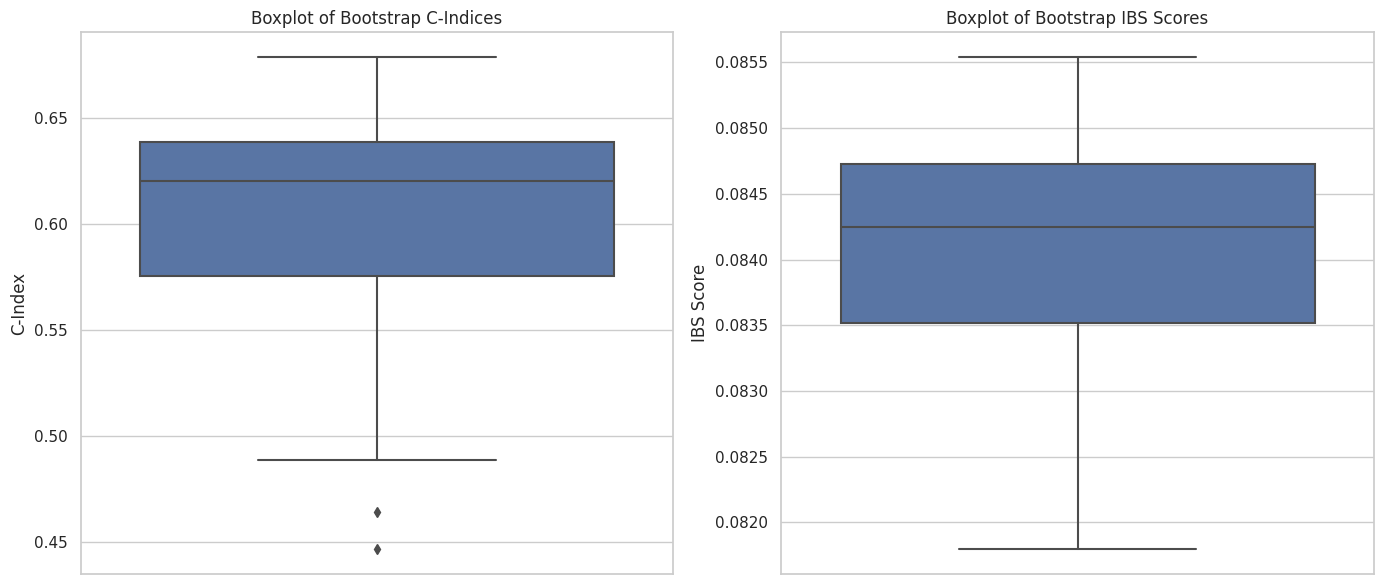

In [ ]:
# 15/8/23 - Lets go with this. Boostrapped estimates. THIS IS THE ONE TATS CURRENTLY SAVED 17/8/23
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(14, 6))

# Subplot for C-index
plt.subplot(1, 2, 1)
sns.boxplot(y=bootstrap_c_indices_deephit)
plt.title("Boxplot of Bootstrap C-Indices")
plt.ylabel("C-Index")

# Subplot for IBS
plt.subplot(1, 2, 2)
sns.boxplot(y=bootstrap_ibs_scores_deep_hit)
plt.title("Boxplot of Bootstrap IBS Scores")
plt.ylabel("IBS Score")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# 15/8/23 - Lets go with this.
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_c_indices_deephit.npy', bootstrap_c_indices_deephit)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_ibs_scores_deep_hit.npy', bootstrap_ibs_scores_deep_hit)


0:	[0s / 0s],		train_loss: 0.5481,	val_loss: 0.5000
1:	[0s / 0s],		train_loss: 0.5148,	val_loss: 0.4731
2:	[0s / 0s],		train_loss: 0.4913,	val_loss: 0.4492
3:	[0s / 0s],		train_loss: 0.4657,	val_loss: 0.4278
4:	[0s / 0s],		train_loss: 0.4447,	val_loss: 0.4085
5:	[0s / 0s],		train_loss: 0.4215,	val_loss: 0.3910
6:	[0s / 1s],		train_loss: 0.4073,	val_loss: 0.3754
7:	[0s / 1s],		train_loss: 0.3902,	val_loss: 0.3618
8:	[0s / 1s],		train_loss: 0.3797,	val_loss: 0.3499
9:	[0s / 1s],		train_loss: 0.3636,	val_loss: 0.3397
10:	[0s / 1s],		train_loss: 0.3564,	val_loss: 0.3307
11:	[0s / 1s],		train_loss: 0.3507,	val_loss: 0.3233
12:	[0s / 1s],		train_loss: 0.3440,	val_loss: 0.3173
13:	[0s / 2s],		train_loss: 0.3275,	val_loss: 0.3122
14:	[0s / 2s],		train_loss: 0.3227,	val_loss: 0.3079
15:	[0s / 2s],		train_loss: 0.3281,	val_loss: 0.3043
16:	[0s / 2s],		train_loss: 0.3206,	val_loss: 0.3012
17:	[0s / 2s],		train_loss: 0.3187,	val_loss: 0.2988
18:	[0s / 2s],		train_loss: 0.3130,	val_loss: 0.2969
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Concordance index on test set: 0.6085536503646142


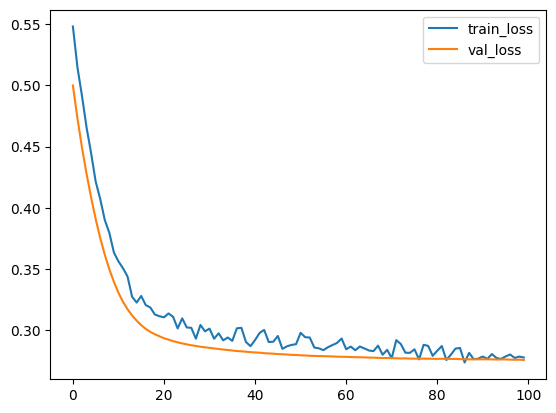

In [ ]:
num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
batch_norm = True if best_hyperparameters['activation_fn'] == 'relu' else False
dropout = [best_hyperparameters['dropout']]

best_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

best_model = DeepHitSingle(best_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

batch_size = best_hyperparameters['batch_size']
best_model.optimizer.set_lr(best_hyperparameters['lr'])

# Train on the entire training set
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = best_model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
_ = log.plot()

# Evaluate on the test set
surv = best_model.predict_surv_df(x_test)
ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
c_index_test = ev_test.concordance_td('antolini')

print(f'Concordance index on test set: {c_index_test}')

# Calculate the integrated Brier score
ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))

print(f'Integrated Brier Score on test set: {ibs}')

In [ ]:
### This is good. This is without tuning early stopping, dropout or epochs. OR n_iterations, presumably
print(best_hyperparameters)


{'batch_size': 32, 'layers': 5, 'nodes': 50, 'activation_fn': 'elu', 'alpha': 0.1, 'sigma': 0.1, 'lr': 0.01}


0:	[0s / 0s],		train_loss: 0.7319,	val_loss: 0.5296
1:	[0s / 0s],		train_loss: 0.5435,	val_loss: 0.4984
2:	[0s / 0s],		train_loss: 0.5187,	val_loss: 0.4898
3:	[0s / 1s],		train_loss: 0.5116,	val_loss: 0.4852
4:	[0s / 1s],		train_loss: 0.5077,	val_loss: 0.4818
5:	[0s / 1s],		train_loss: 0.4968,	val_loss: 0.4802
6:	[0s / 1s],		train_loss: 0.4960,	val_loss: 0.4790
7:	[0s / 2s],		train_loss: 0.4852,	val_loss: 0.4799
8:	[0s / 2s],		train_loss: 0.4853,	val_loss: 0.4778
9:	[0s / 2s],		train_loss: 0.4761,	val_loss: 0.4794
10:	[0s / 3s],		train_loss: 0.4731,	val_loss: 0.4770
11:	[0s / 3s],		train_loss: 0.4663,	val_loss: 0.4780
12:	[0s / 3s],		train_loss: 0.4723,	val_loss: 0.4773
13:	[0s / 4s],		train_loss: 0.4642,	val_loss: 0.4805
14:	[0s / 4s],		train_loss: 0.4600,	val_loss: 0.4762
15:	[0s / 4s],		train_loss: 0.4591,	val_loss: 0.4789
16:	[0s / 5s],		train_loss: 0.4519,	val_loss: 0.4768
17:	[0s / 5s],		train_loss: 0.4538,	val_loss: 0.4791
18:	[0s / 5s],		train_loss: 0.4540,	val_loss: 0.4772
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Integrated Brier Score on test set: 0.0830719720523155


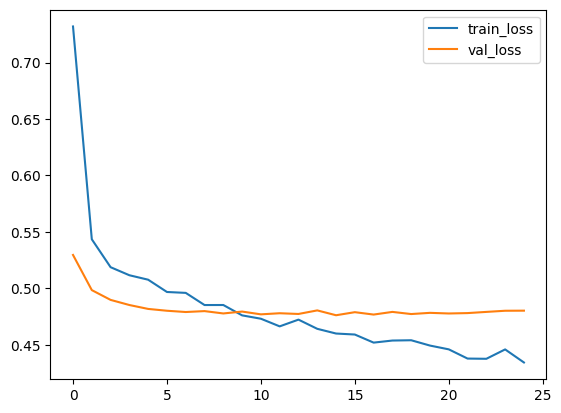

In [ ]:
###This is good. This is without tuning early stopping, dropout or epochs
# Use the best hyperparameters to create a new model
num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
batch_norm = True if best_hyperparameters['activation_fn'] == 'relu' else False
dropout = 0.4

best_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

best_model = DeepHitSingle(best_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

batch_size = best_hyperparameters['batch_size']
best_model.optimizer.set_lr(best_hyperparameters['lr'])

# Train on the entire training set
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = best_model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
_ = log.plot()

# Evaluate on the test set
surv = best_model.predict_surv_df(x_test)
ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
c_index_test = ev_test.concordance_td('antolini')

print(f'Concordance index on test set: {c_index_test}')

# Calculate the integrated Brier score
ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))

print(f'Integrated Brier Score on test set: {ibs}')


In [ ]:
best_hyperparameters = {'batch_size': 32, 'layers': 1, 'nodes': 100, 'activation_fn': 'elu', 'alpha': 1.0, 'sigma': 0.1, 'lr': 0.001, 'dropout': 0.4, 'patience': 10}

In [ ]:
## Boostrapped estimates 15/8/23


from lifelines.utils import concordance_index
def get_random_hyperparameters():
    SET_BATCH_SIZE = [32, 64, 128, 256]
    SET_BATCH_NORM = [True, False]
    SET_LAYERS = [1,2,3,5]
    SET_NODES = [50, 100, 200, 300]
    SET_ALPHA = [0.1, 0.5, 1.0]
    SET_SIGMA = [0.1, 0.5, 1.0]
    SET_LR = [1e-4, 1e-3, 1e-2]
    SET_DROPOUT = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    SET_PATIENCE = [5, 10, 20, 30, 40, 50]

    return {
        'batch_size': SET_BATCH_SIZE[np.random.randint(len(SET_BATCH_SIZE))],
        'batch_norm': SET_BATCH_NORM[np.random.randint(len(SET_BATCH_NORM))],
        'layers': SET_LAYERS[np.random.randint(len(SET_LAYERS))],
        'nodes': SET_NODES[np.random.randint(len(SET_NODES))],
        'alpha': SET_ALPHA[np.random.randint(len(SET_ALPHA))],
        'sigma': SET_SIGMA[np.random.randint(len(SET_SIGMA))],
        'lr': SET_LR[np.random.randint(len(SET_LR))],
        'dropout': SET_DROPOUT[np.random.randint(len(SET_DROPOUT))],
        'patience': SET_PATIENCE[np.random.randint(len(SET_PATIENCE))],
    }


# Main loop
max_valid = 0.0
best_model = None
best_hyperparameters = None

for r_itr in range(RS_ITERATION):
    print(f'Random search... itr: {r_itr}')
    hyperparameters = get_random_hyperparameters()
    print(hyperparameters)

    # Use chosen hyperparameters
    num_nodes = [hyperparameters['nodes']] * hyperparameters['layers']
    batch_norm = hyperparameters['batch_norm']
    dropout = hyperparameters['dropout']

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    model = DeepHitSingle(net, tt.optim.Adam, alpha=hyperparameters['alpha'], sigma=hyperparameters['sigma'], duration_index=labtrans.cuts)

    batch_size = hyperparameters['batch_size']
    model.optimizer.set_lr(hyperparameters['lr'])

    epochs = 100
    callbacks = [tt.callbacks.EarlyStopping(patience=hyperparameters['patience'])]
    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

    # Validate the model
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
    c_index = ev.concordance_td('antolini')

    # If this model is better, save it
    if c_index > max_valid:
        max_valid = c_index
        best_model = model
        best_hyperparameters = hyperparameters

    print(f'Current best c-index: {max_valid}')

print(f'Best hyperparameters: {best_hyperparameters}')



Random search... itr: 0
{'batch_size': 32, 'batch_norm': True, 'layers': 2, 'nodes': 200, 'alpha': 1.0, 'sigma': 1.0, 'lr': 0.01, 'dropout': 0.2, 'patience': 30}
0:	[0s / 0s],		train_loss: 0.7214,	val_loss: 0.6440
1:	[0s / 1s],		train_loss: 0.5786,	val_loss: 0.5553
2:	[0s / 2s],		train_loss: 0.5196,	val_loss: 0.5399
3:	[0s / 3s],		train_loss: 0.4894,	val_loss: 0.5359
4:	[0s / 3s],		train_loss: 0.4622,	val_loss: 0.5584
5:	[0s / 3s],		train_loss: 0.4486,	val_loss: 0.6016
6:	[0s / 4s],		train_loss: 0.4490,	val_loss: 0.5686
7:	[0s / 4s],		train_loss: 0.4259,	val_loss: 0.5587
8:	[0s / 4s],		train_loss: 0.4136,	val_loss: 0.5975
9:	[0s / 5s],		train_loss: 0.4111,	val_loss: 0.5988
10:	[0s / 5s],		train_loss: 0.4010,	val_loss: 0.5950
11:	[0s / 6s],		train_loss: 0.3864,	val_loss: 0.6049
12:	[0s / 6s],		train_loss: 0.3651,	val_loss: 0.6068
13:	[0s / 7s],		train_loss: 0.3722,	val_loss: 0.6276
14:	[0s / 7s],		train_loss: 0.3751,	val_loss: 0.6436
15:	[0s / 7s],		train_loss: 0.3506,	val_loss: 0.6499


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 1.0295,	val_loss: 0.9426
4:	[0s / 0s],		train_loss: 1.0311,	val_loss: 0.9428
5:	[0s / 0s],		train_loss: 1.0073,	val_loss: 0.9413
6:	[0s / 0s],		train_loss: 1.0255,	val_loss: 0.9394
7:	[0s / 0s],		train_loss: 1.0139,	val_loss: 0.9376
8:	[0s / 0s],		train_loss: 1.0196,	val_loss: 0.9370
9:	[0s / 0s],		train_loss: 0.9988,	val_loss: 0.9342
10:	[0s / 0s],		train_loss: 1.0019,	val_loss: 0.9317
11:	[0s / 0s],		train_loss: 0.9996,	val_loss: 0.9292
12:	[0s / 0s],		train_loss: 1.0103,	val_loss: 0.9258
13:	[0s / 0s],		train_loss: 0.9960,	val_loss: 0.9241
14:	[0s / 0s],		train_loss: 0.9910,	val_loss: 0.9212
15:	[0s / 0s],		train_loss: 0.9802,	val_loss: 0.9211
16:	[0s / 1s],		train_loss: 0.9787,	val_loss: 0.9195
17:	[0s / 1s],		train_loss: 0.9709,	val_loss: 0.9177
18:	[0s / 1s],		train_loss: 0.9845,	val_loss: 0.9135
19:	[0s / 1s],		train_loss: 0.9691,	val_loss: 0.9108
20:	[0s / 1s],		train_loss: 0.9780,	val_loss: 0.9092
Current best c-index: 0.5514495712535729
Random searc

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.2989,	val_loss: 0.2868
3:	[0s / 0s],		train_loss: 0.2890,	val_loss: 0.2846
4:	[0s / 0s],		train_loss: 0.2843,	val_loss: 0.2835
5:	[0s / 0s],		train_loss: 0.2750,	val_loss: 0.2831
6:	[0s / 0s],		train_loss: 0.2742,	val_loss: 0.2821
7:	[0s / 0s],		train_loss: 0.2725,	val_loss: 0.2819
8:	[0s / 0s],		train_loss: 0.2662,	val_loss: 0.2812
9:	[0s / 0s],		train_loss: 0.2602,	val_loss: 0.2846
10:	[0s / 0s],		train_loss: 0.2559,	val_loss: 0.2833
11:	[0s / 0s],		train_loss: 0.2583,	val_loss: 0.2809
12:	[0s / 0s],		train_loss: 0.2558,	val_loss: 0.2854
13:	[0s / 0s],		train_loss: 0.2555,	val_loss: 0.2888
14:	[0s / 0s],		train_loss: 0.2429,	val_loss: 0.2848
15:	[0s / 0s],		train_loss: 0.2481,	val_loss: 0.2841
16:	[0s / 0s],		train_loss: 0.2439,	val_loss: 0.2872
17:	[0s / 0s],		train_loss: 0.2360,	val_loss: 0.2927
18:	[0s / 0s],		train_loss: 0.2323,	val_loss: 0.2937
19:	[0s / 1s],		train_loss: 0.2305,	val_loss: 0.2961
20:	[0s / 1s],		train_loss: 0.2373,	val_loss: 0.3024
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2242,	val_loss: 0.1540
1:	[0s / 0s],		train_loss: 0.1712,	val_loss: 0.1526
2:	[0s / 0s],		train_loss: 0.1683,	val_loss: 0.1535
3:	[0s / 0s],		train_loss: 0.1484,	val_loss: 0.1508
4:	[0s / 0s],		train_loss: 0.1487,	val_loss: 0.1478
5:	[0s / 1s],		train_loss: 0.1445,	val_loss: 0.1480
6:	[0s / 1s],		train_loss: 0.1398,	val_loss: 0.1465
7:	[0s / 1s],		train_loss: 0.1335,	val_loss: 0.1451
8:	[0s / 1s],		train_loss: 0.1365,	val_loss: 0.1495
9:	[0s / 1s],		train_loss: 0.1230,	val_loss: 0.1503
10:	[0s / 2s],		train_loss: 0.1259,	val_loss: 0.1480
11:	[0s / 2s],		train_loss: 0.1231,	val_loss: 0.1456
12:	[0s / 2s],		train_loss: 0.1155,	val_loss: 0.1501
13:	[0s / 2s],		train_loss: 0.1158,	val_loss: 0.1456
14:	[0s / 3s],		train_loss: 0.1114,	val_loss: 0.1454
15:	[0s / 3s],		train_loss: 0.1099,	val_loss: 0.1451
16:	[0s / 3s],		train_loss: 0.1057,	val_loss: 0.1474
17:	[0s / 3s],		train_loss: 0.1013,	val_loss: 0.1486
18:	[0s / 4s],		train_loss: 0.0986,	val_loss: 0.1509
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6443,	val_loss: 0.5275
1:	[0s / 0s],		train_loss: 0.5385,	val_loss: 0.5304
2:	[0s / 0s],		train_loss: 0.5017,	val_loss: 0.5365
3:	[0s / 0s],		train_loss: 0.4619,	val_loss: 0.5326
4:	[0s / 0s],		train_loss: 0.4557,	val_loss: 0.5538
5:	[0s / 1s],		train_loss: 0.4337,	val_loss: 0.5867
6:	[0s / 1s],		train_loss: 0.4175,	val_loss: 0.6091
7:	[0s / 1s],		train_loss: 0.4022,	val_loss: 0.5910
8:	[0s / 1s],		train_loss: 0.3769,	val_loss: 0.6113
9:	[0s / 1s],		train_loss: 0.3663,	val_loss: 0.6598
10:	[0s / 2s],		train_loss: 0.3595,	val_loss: 0.6466
11:	[0s / 2s],		train_loss: 0.3406,	val_loss: 0.6677
12:	[0s / 2s],		train_loss: 0.3440,	val_loss: 0.7082
13:	[0s / 2s],		train_loss: 0.3248,	val_loss: 0.7629
14:	[0s / 3s],		train_loss: 0.3319,	val_loss: 0.7041
15:	[0s / 3s],		train_loss: 0.3048,	val_loss: 0.7509
16:	[0s / 3s],		train_loss: 0.3071,	val_loss: 0.7505
17:	[0s / 4s],		train_loss: 0.3096,	val_loss: 0.7637
18:	[0s / 4s],		train_loss: 0.3022,	val_loss: 0.7552
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.5624,	val_loss: 0.5120
3:	[0s / 0s],		train_loss: 0.5589,	val_loss: 0.5116
4:	[0s / 0s],		train_loss: 0.5606,	val_loss: 0.5100
5:	[0s / 0s],		train_loss: 0.5538,	val_loss: 0.5088
6:	[0s / 0s],		train_loss: 0.5494,	val_loss: 0.5060
7:	[0s / 0s],		train_loss: 0.5458,	val_loss: 0.5031
8:	[0s / 0s],		train_loss: 0.5507,	val_loss: 0.5015
9:	[0s / 0s],		train_loss: 0.5479,	val_loss: 0.5001
10:	[0s / 0s],		train_loss: 0.5479,	val_loss: 0.4975
11:	[0s / 0s],		train_loss: 0.5417,	val_loss: 0.4953
12:	[0s / 0s],		train_loss: 0.5353,	val_loss: 0.4939
13:	[0s / 1s],		train_loss: 0.5395,	val_loss: 0.4918
14:	[0s / 1s],		train_loss: 0.5463,	val_loss: 0.4907
15:	[0s / 1s],		train_loss: 0.5342,	val_loss: 0.4889
16:	[0s / 1s],		train_loss: 0.5320,	val_loss: 0.4864
17:	[0s / 1s],		train_loss: 0.5430,	val_loss: 0.4845
18:	[0s / 1s],		train_loss: 0.5298,	val_loss: 0.4830
19:	[0s / 1s],		train_loss: 0.5298,	val_loss: 0.4803
20:	[0s / 1s],		train_loss: 0.5348,	val_loss: 0.4778
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 1.0200,	val_loss: 0.9227
1:	[0s / 0s],		train_loss: 0.9855,	val_loss: 0.8762
2:	[0s / 0s],		train_loss: 0.9427,	val_loss: 0.8326
3:	[0s / 0s],		train_loss: 0.9031,	val_loss: 0.7964
4:	[0s / 0s],		train_loss: 0.8738,	val_loss: 0.7634
5:	[0s / 0s],		train_loss: 0.8405,	val_loss: 0.7322
6:	[0s / 0s],		train_loss: 0.8126,	val_loss: 0.7014
7:	[0s / 0s],		train_loss: 0.7680,	val_loss: 0.6715
8:	[0s / 0s],		train_loss: 0.7267,	val_loss: 0.6494
9:	[0s / 0s],		train_loss: 0.7218,	val_loss: 0.6281
10:	[0s / 1s],		train_loss: 0.6882,	val_loss: 0.6158
11:	[0s / 1s],		train_loss: 0.6734,	val_loss: 0.6053
12:	[0s / 1s],		train_loss: 0.6533,	val_loss: 0.5985
13:	[0s / 1s],		train_loss: 0.6205,	val_loss: 0.5935
14:	[0s / 1s],		train_loss: 0.6226,	val_loss: 0.5880
15:	[0s / 1s],		train_loss: 0.6316,	val_loss: 0.5825
16:	[0s / 1s],		train_loss: 0.6011,	val_loss: 0.5767
17:	[0s / 1s],		train_loss: 0.5803,	val_loss: 0.5742
18:	[0s / 1s],		train_loss: 0.5882,	val_loss: 0.5703
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.5562,	val_loss: 0.5122
1:	[0s / 0s],		train_loss: 0.5449,	val_loss: 0.5023
2:	[0s / 0s],		train_loss: 0.5259,	val_loss: 0.4955
3:	[0s / 1s],		train_loss: 0.5164,	val_loss: 0.4858
4:	[0s / 1s],		train_loss: 0.5073,	val_loss: 0.4743
5:	[0s / 1s],		train_loss: 0.4925,	val_loss: 0.4601
6:	[0s / 2s],		train_loss: 0.4793,	val_loss: 0.4489
7:	[0s / 2s],		train_loss: 0.4564,	val_loss: 0.4391
8:	[0s / 2s],		train_loss: 0.4440,	val_loss: 0.4298
9:	[0s / 2s],		train_loss: 0.4318,	val_loss: 0.4154
10:	[0s / 3s],		train_loss: 0.4152,	val_loss: 0.4054
11:	[0s / 3s],		train_loss: 0.4026,	val_loss: 0.3951
12:	[0s / 3s],		train_loss: 0.3927,	val_loss: 0.3849
13:	[0s / 3s],		train_loss: 0.3838,	val_loss: 0.3769
14:	[0s / 4s],		train_loss: 0.3835,	val_loss: 0.3754
15:	[0s / 4s],		train_loss: 0.3629,	val_loss: 0.3665
16:	[0s / 4s],		train_loss: 0.3621,	val_loss: 0.3605
17:	[0s / 5s],		train_loss: 0.3496,	val_loss: 0.3580
18:	[0s / 5s],		train_loss: 0.3513,	val_loss: 0.3496
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.1105,	val_loss: 0.1226
3:	[0s / 0s],		train_loss: 0.1059,	val_loss: 0.1220
4:	[0s / 0s],		train_loss: 0.0990,	val_loss: 0.1236
5:	[0s / 0s],		train_loss: 0.0947,	val_loss: 0.1229
6:	[0s / 0s],		train_loss: 0.0909,	val_loss: 0.1334
Current best c-index: 0.6129542670477746
Random search... itr: 9
{'batch_size': 256, 'batch_norm': True, 'layers': 5, 'nodes': 200, 'alpha': 1.0, 'sigma': 1.0, 'lr': 0.001, 'dropout': 0.3, 'patience': 20}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 1.0319,	val_loss: 0.9024
1:	[0s / 0s],		train_loss: 0.9759,	val_loss: 0.8574
2:	[0s / 0s],		train_loss: 0.9319,	val_loss: 0.7902
3:	[0s / 0s],		train_loss: 0.8642,	val_loss: 0.6900
4:	[0s / 0s],		train_loss: 0.7741,	val_loss: 0.6105
5:	[0s / 0s],		train_loss: 0.7061,	val_loss: 0.5976
6:	[0s / 1s],		train_loss: 0.6534,	val_loss: 0.6031
7:	[0s / 1s],		train_loss: 0.6039,	val_loss: 0.5983
8:	[0s / 1s],		train_loss: 0.5750,	val_loss: 0.5929
9:	[0s / 1s],		train_loss: 0.5634,	val_loss: 0.5708
10:	[0s / 1s],		train_loss: 0.5417,	val_loss: 0.5637
11:	[0s / 1s],		train_loss: 0.5304,	val_loss: 0.5566
12:	[0s / 1s],		train_loss: 0.5308,	val_loss: 0.5536
13:	[0s / 2s],		train_loss: 0.5243,	val_loss: 0.5457
14:	[0s / 2s],		train_loss: 0.5075,	val_loss: 0.5421
15:	[0s / 2s],		train_loss: 0.4999,	val_loss: 0.5393
16:	[0s / 2s],		train_loss: 0.5119,	val_loss: 0.5393
17:	[0s / 2s],		train_loss: 0.4881,	val_loss: 0.5364
18:	[0s / 2s],		train_loss: 0.4973,	val_loss: 0.5350
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.6129542670477746
Random search... itr: 10
{'batch_size': 32, 'batch_norm': False, 'layers': 1, 'nodes': 100, 'alpha': 0.1, 'sigma': 0.5, 'lr': 0.001, 'dropout': 0.0, 'patience': 40}
0:	[0s / 0s],		train_loss: 0.1459,	val_loss: 0.1220
1:	[0s / 0s],		train_loss: 0.1249,	val_loss: 0.1163
2:	[0s / 0s],		train_loss: 0.1186,	val_loss: 0.1142
3:	[0s / 1s],		train_loss: 0.1151,	val_loss: 0.1140
4:	[0s / 1s],		train_loss: 0.1128,	val_loss: 0.1135
5:	[0s / 1s],		train_loss: 0.1111,	val_loss: 0.1138
6:	[0s / 1s],		train_loss: 0.1080,	val_loss: 0.1139
7:	[0s / 2s],		train_loss: 0.1084,	val_loss: 0.1139
8:	[0s / 2s],		train_loss: 0.1057,	val_loss: 0.1140
9:	[0s / 2s],		train_loss: 0.1061,	val_loss: 0.1144
10:	[0s / 3s],		train_loss: 0.1037,	val_loss: 0.1146
11:	[0s / 3s],		train_loss: 0.1045,	val_loss: 0.1152
12:	[0s / 3s],		train_loss: 0.1024,	val_loss: 0.1157
13:	[0s / 3s],		train_loss: 0.1017,	val_loss: 0.1159
14:	[0s / 3s],		train_loss: 0.1008,	val_loss: 0.1157
15:	[0s /

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1727,	val_loss: 0.1571
1:	[0s / 0s],		train_loss: 0.1706,	val_loss: 0.1556
2:	[0s / 0s],		train_loss: 0.1692,	val_loss: 0.1545
3:	[0s / 0s],		train_loss: 0.1711,	val_loss: 0.1540
4:	[0s / 0s],		train_loss: 0.1687,	val_loss: 0.1533
5:	[0s / 0s],		train_loss: 0.1658,	val_loss: 0.1527
6:	[0s / 1s],		train_loss: 0.1680,	val_loss: 0.1519
7:	[0s / 1s],		train_loss: 0.1658,	val_loss: 0.1511
8:	[0s / 1s],		train_loss: 0.1637,	val_loss: 0.1506
9:	[0s / 1s],		train_loss: 0.1655,	val_loss: 0.1499
10:	[0s / 1s],		train_loss: 0.1661,	val_loss: 0.1493
11:	[0s / 1s],		train_loss: 0.1635,	val_loss: 0.1486
12:	[0s / 1s],		train_loss: 0.1632,	val_loss: 0.1481
13:	[0s / 1s],		train_loss: 0.1608,	val_loss: 0.1472
14:	[0s / 2s],		train_loss: 0.1596,	val_loss: 0.1466
15:	[0s / 2s],		train_loss: 0.1598,	val_loss: 0.1458
16:	[0s / 2s],		train_loss: 0.1593,	val_loss: 0.1448
17:	[0s / 2s],		train_loss: 0.1577,	val_loss: 0.1440
18:	[0s / 2s],		train_loss: 0.1561,	val_loss: 0.1434
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.4470,	val_loss: 0.3396
1:	[0s / 0s],		train_loss: 0.3777,	val_loss: 0.3144
2:	[0s / 1s],		train_loss: 0.3462,	val_loss: 0.3058
3:	[0s / 1s],		train_loss: 0.3531,	val_loss: 0.3012
4:	[0s / 1s],		train_loss: 0.3283,	val_loss: 0.2999
5:	[0s / 2s],		train_loss: 0.3351,	val_loss: 0.2960
6:	[0s / 2s],		train_loss: 0.3286,	val_loss: 0.2939
7:	[0s / 3s],		train_loss: 0.3254,	val_loss: 0.2943
8:	[0s / 4s],		train_loss: 0.3228,	val_loss: 0.2914
9:	[0s / 4s],		train_loss: 0.3247,	val_loss: 0.2899
10:	[0s / 5s],		train_loss: 0.3210,	val_loss: 0.2898
11:	[0s / 5s],		train_loss: 0.3121,	val_loss: 0.2896
12:	[0s / 6s],		train_loss: 0.3113,	val_loss: 0.2917
13:	[0s / 7s],		train_loss: 0.3036,	val_loss: 0.2902
14:	[0s / 7s],		train_loss: 0.3032,	val_loss: 0.2885
15:	[0s / 7s],		train_loss: 0.3145,	val_loss: 0.2889
16:	[0s / 8s],		train_loss: 0.3053,	val_loss: 0.2902
17:	[0s / 8s],		train_loss: 0.3044,	val_loss: 0.2893
18:	[0s / 9s],		train_loss: 0.3040,	val_loss: 0.2898
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 0.1669,	val_loss: 0.1574
4:	[0s / 0s],		train_loss: 0.1677,	val_loss: 0.1567
5:	[0s / 0s],		train_loss: 0.1661,	val_loss: 0.1561
6:	[0s / 0s],		train_loss: 0.1663,	val_loss: 0.1555
7:	[0s / 0s],		train_loss: 0.1649,	val_loss: 0.1550
8:	[0s / 0s],		train_loss: 0.1645,	val_loss: 0.1545
9:	[0s / 0s],		train_loss: 0.1645,	val_loss: 0.1540
10:	[0s / 0s],		train_loss: 0.1623,	val_loss: 0.1533
11:	[0s / 0s],		train_loss: 0.1641,	val_loss: 0.1529
12:	[0s / 0s],		train_loss: 0.1615,	val_loss: 0.1525
13:	[0s / 0s],		train_loss: 0.1599,	val_loss: 0.1520
14:	[0s / 0s],		train_loss: 0.1620,	val_loss: 0.1515
15:	[0s / 0s],		train_loss: 0.1602,	val_loss: 0.1510
16:	[0s / 0s],		train_loss: 0.1595,	val_loss: 0.1504
17:	[0s / 0s],		train_loss: 0.1583,	val_loss: 0.1501
18:	[0s / 1s],		train_loss: 0.1588,	val_loss: 0.1497
19:	[0s / 1s],		train_loss: 0.1578,	val_loss: 0.1493
20:	[0s / 1s],		train_loss: 0.1577,	val_loss: 0.1487
21:	[0s / 1s],		train_loss: 0.1572,	val_loss: 0.1482


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6015,	val_loss: 0.5145
1:	[0s / 0s],		train_loss: 0.6155,	val_loss: 0.5098
2:	[0s / 0s],		train_loss: 0.5906,	val_loss: 0.5055
3:	[0s / 0s],		train_loss: 0.5731,	val_loss: 0.5003
4:	[0s / 0s],		train_loss: 0.5787,	val_loss: 0.4976
5:	[0s / 0s],		train_loss: 0.5665,	val_loss: 0.4961
6:	[0s / 1s],		train_loss: 0.5668,	val_loss: 0.4941
7:	[0s / 1s],		train_loss: 0.5574,	val_loss: 0.4905
8:	[0s / 1s],		train_loss: 0.5526,	val_loss: 0.4877
9:	[0s / 1s],		train_loss: 0.5528,	val_loss: 0.4835
10:	[0s / 1s],		train_loss: 0.5425,	val_loss: 0.4834
11:	[0s / 2s],		train_loss: 0.5355,	val_loss: 0.4808
12:	[0s / 2s],		train_loss: 0.5453,	val_loss: 0.4795
13:	[0s / 2s],		train_loss: 0.5263,	val_loss: 0.4778
14:	[0s / 2s],		train_loss: 0.5246,	val_loss: 0.4766
15:	[0s / 2s],		train_loss: 0.5314,	val_loss: 0.4737
16:	[0s / 2s],		train_loss: 0.5216,	val_loss: 0.4715
17:	[0s / 2s],		train_loss: 0.5209,	val_loss: 0.4687
18:	[0s / 3s],		train_loss: 0.5322,	val_loss: 0.4672
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.6190,	val_loss: 0.5502
2:	[0s / 0s],		train_loss: 0.5919,	val_loss: 0.5397
3:	[0s / 0s],		train_loss: 0.5634,	val_loss: 0.5230
4:	[0s / 0s],		train_loss: 0.5381,	val_loss: 0.5153
5:	[0s / 0s],		train_loss: 0.5249,	val_loss: 0.5098
6:	[0s / 0s],		train_loss: 0.5068,	val_loss: 0.5068
7:	[0s / 0s],		train_loss: 0.5013,	val_loss: 0.5072
8:	[0s / 0s],		train_loss: 0.4929,	val_loss: 0.5058
9:	[0s / 1s],		train_loss: 0.4858,	val_loss: 0.5043
10:	[0s / 1s],		train_loss: 0.4767,	val_loss: 0.5040
11:	[0s / 1s],		train_loss: 0.4778,	val_loss: 0.5057
12:	[0s / 1s],		train_loss: 0.4641,	val_loss: 0.5057
13:	[0s / 1s],		train_loss: 0.4701,	val_loss: 0.5048
14:	[0s / 1s],		train_loss: 0.4684,	val_loss: 0.5053
15:	[0s / 1s],		train_loss: 0.4582,	val_loss: 0.5023
16:	[0s / 1s],		train_loss: 0.4560,	val_loss: 0.5030
17:	[0s / 2s],		train_loss: 0.4545,	val_loss: 0.5050
18:	[0s / 2s],		train_loss: 0.4492,	val_loss: 0.5048
19:	[0s / 2s],		train_loss: 0.4541,	val_loss: 0.5027
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.6309718252347897
Random search... itr: 16
{'batch_size': 256, 'batch_norm': True, 'layers': 1, 'nodes': 50, 'alpha': 0.5, 'sigma': 0.5, 'lr': 0.001, 'dropout': 0.2, 'patience': 30}
0:	[0s / 0s],		train_loss: 0.5370,	val_loss: 0.4935
1:	[0s / 0s],		train_loss: 0.5210,	val_loss: 0.4800
2:	[0s / 0s],		train_loss: 0.5028,	val_loss: 0.4670
3:	[0s / 0s],		train_loss: 0.4872,	val_loss: 0.4547
4:	[0s / 0s],		train_loss: 0.4725,	val_loss: 0.4424
5:	[0s / 0s],		train_loss: 0.4632,	val_loss: 0.4314
6:	[0s / 0s],		train_loss: 0.4507,	val_loss: 0.4205
7:	[0s / 0s],		train_loss: 0.4422,	val_loss: 0.4102
8:	[0s / 1s],		train_loss: 0.4310,	val_loss: 0.4002
9:	[0s / 1s],		train_loss: 0.4194,	val_loss: 0.3907
10:	[0s / 1s],		train_loss: 0.4068,	val_loss: 0.3817
11:	[0s / 1s],		train_loss: 0.3974,	val_loss: 0.3736
12:	[0s / 1s],		train_loss: 0.3926,	val_loss: 0.3664
13:	[0s / 1s],		train_loss: 0.3838,	val_loss: 0.3595
14:	[0s / 1s],		train_loss: 0.3736,	val_loss: 0.3528
15:	[0s / 

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.5239,	val_loss: 0.4737
1:	[0s / 1s],		train_loss: 0.4912,	val_loss: 0.4366
2:	[0s / 1s],		train_loss: 0.4504,	val_loss: 0.3960
3:	[0s / 2s],		train_loss: 0.4079,	val_loss: 0.3654
4:	[0s / 3s],		train_loss: 0.3706,	val_loss: 0.3451
5:	[0s / 3s],		train_loss: 0.3458,	val_loss: 0.3321
6:	[0s / 4s],		train_loss: 0.3341,	val_loss: 0.3208
7:	[0s / 4s],		train_loss: 0.3219,	val_loss: 0.3151
8:	[0s / 5s],		train_loss: 0.3178,	val_loss: 0.3129
9:	[0s / 5s],		train_loss: 0.3058,	val_loss: 0.3103
10:	[0s / 6s],		train_loss: 0.3047,	val_loss: 0.3111
11:	[0s / 6s],		train_loss: 0.2894,	val_loss: 0.3091
12:	[0s / 6s],		train_loss: 0.2859,	val_loss: 0.3083
13:	[0s / 7s],		train_loss: 0.2817,	val_loss: 0.3064
14:	[0s / 7s],		train_loss: 0.2756,	val_loss: 0.3063
15:	[0s / 8s],		train_loss: 0.2745,	val_loss: 0.3073
16:	[0s / 8s],		train_loss: 0.2725,	val_loss: 0.3065
17:	[0s / 9s],		train_loss: 0.2620,	val_loss: 0.3062
18:	[0s / 9s],		train_loss: 0.2633,	val_loss: 0.3073
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.5478,	val_loss: 0.4133
1:	[0s / 0s],		train_loss: 0.4349,	val_loss: 0.3509
2:	[0s / 0s],		train_loss: 0.3794,	val_loss: 0.3158
3:	[0s / 0s],		train_loss: 0.3508,	val_loss: 0.3025
4:	[0s / 0s],		train_loss: 0.3415,	val_loss: 0.2959
5:	[0s / 1s],		train_loss: 0.3293,	val_loss: 0.2905
6:	[0s / 1s],		train_loss: 0.3259,	val_loss: 0.2876
7:	[0s / 1s],		train_loss: 0.3264,	val_loss: 0.2862
8:	[0s / 1s],		train_loss: 0.3163,	val_loss: 0.2849
9:	[0s / 1s],		train_loss: 0.3114,	val_loss: 0.2840
10:	[0s / 2s],		train_loss: 0.3036,	val_loss: 0.2830
11:	[0s / 2s],		train_loss: 0.3095,	val_loss: 0.2826
12:	[0s / 2s],		train_loss: 0.3013,	val_loss: 0.2827
13:	[0s / 2s],		train_loss: 0.2989,	val_loss: 0.2833
14:	[0s / 2s],		train_loss: 0.2960,	val_loss: 0.2830
15:	[0s / 3s],		train_loss: 0.2926,	val_loss: 0.2833
16:	[0s / 3s],		train_loss: 0.2819,	val_loss: 0.2841
17:	[0s / 3s],		train_loss: 0.2844,	val_loss: 0.2836
18:	[0s / 3s],		train_loss: 0.2874,	val_loss: 0.2831
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6651,	val_loss: 0.5339
1:	[0s / 0s],		train_loss: 0.5714,	val_loss: 0.5487
2:	[0s / 0s],		train_loss: 0.5692,	val_loss: 0.5383
3:	[0s / 0s],		train_loss: 0.5243,	val_loss: 0.5097
4:	[0s / 1s],		train_loss: 0.5285,	val_loss: 0.5368
5:	[0s / 1s],		train_loss: 0.4937,	val_loss: 0.5288
6:	[0s / 1s],		train_loss: 0.5070,	val_loss: 0.5184
7:	[0s / 1s],		train_loss: 0.5043,	val_loss: 0.5179
8:	[0s / 2s],		train_loss: 0.4823,	val_loss: 0.5211
9:	[0s / 2s],		train_loss: 0.4913,	val_loss: 0.5122
10:	[0s / 2s],		train_loss: 0.4942,	val_loss: 0.5180
11:	[0s / 2s],		train_loss: 0.4785,	val_loss: 0.5394
12:	[0s / 3s],		train_loss: 0.4771,	val_loss: 0.5212
13:	[0s / 3s],		train_loss: 0.4874,	val_loss: 0.5221
14:	[0s / 3s],		train_loss: 0.4726,	val_loss: 0.5215
15:	[0s / 3s],		train_loss: 0.4542,	val_loss: 0.5247
16:	[0s / 3s],		train_loss: 0.4587,	val_loss: 0.5074
17:	[0s / 4s],		train_loss: 0.4550,	val_loss: 0.5261
18:	[0s / 4s],		train_loss: 0.4364,	val_loss: 0.5176
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.8008,	val_loss: 0.7428
2:	[0s / 0s],		train_loss: 0.6578,	val_loss: 0.6558
3:	[0s / 0s],		train_loss: 0.5611,	val_loss: 0.6420
4:	[0s / 0s],		train_loss: 0.5256,	val_loss: 0.6160
5:	[0s / 0s],		train_loss: 0.4956,	val_loss: 0.5995
6:	[0s / 0s],		train_loss: 0.4867,	val_loss: 0.5923
7:	[0s / 1s],		train_loss: 0.4570,	val_loss: 0.5872
8:	[0s / 1s],		train_loss: 0.4535,	val_loss: 0.5785
9:	[0s / 1s],		train_loss: 0.4398,	val_loss: 0.5787
10:	[0s / 1s],		train_loss: 0.4253,	val_loss: 0.5775
11:	[0s / 1s],		train_loss: 0.4056,	val_loss: 0.5775
12:	[0s / 1s],		train_loss: 0.3947,	val_loss: 0.5866
13:	[0s / 1s],		train_loss: 0.3987,	val_loss: 0.5888
14:	[0s / 2s],		train_loss: 0.3777,	val_loss: 0.5906
15:	[0s / 2s],		train_loss: 0.3681,	val_loss: 0.5902
16:	[0s / 2s],		train_loss: 0.3626,	val_loss: 0.5990
17:	[0s / 2s],		train_loss: 0.3493,	val_loss: 0.6155
18:	[0s / 2s],		train_loss: 0.3397,	val_loss: 0.6211
19:	[0s / 2s],		train_loss: 0.3234,	val_loss: 0.6156
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.4504,	val_loss: 0.3720
2:	[0s / 0s],		train_loss: 0.3508,	val_loss: 0.3126
3:	[0s / 0s],		train_loss: 0.3411,	val_loss: 0.2944
4:	[0s / 0s],		train_loss: 0.3343,	val_loss: 0.2873
5:	[0s / 0s],		train_loss: 0.3034,	val_loss: 0.3014
6:	[0s / 0s],		train_loss: 0.3133,	val_loss: 0.2830
7:	[0s / 0s],		train_loss: 0.3066,	val_loss: 0.2809
8:	[0s / 0s],		train_loss: 0.2913,	val_loss: 0.2781
9:	[0s / 0s],		train_loss: 0.2868,	val_loss: 0.2790
10:	[0s / 0s],		train_loss: 0.2787,	val_loss: 0.2763
11:	[0s / 1s],		train_loss: 0.2808,	val_loss: 0.2781
12:	[0s / 1s],		train_loss: 0.2773,	val_loss: 0.2816
13:	[0s / 1s],		train_loss: 0.2695,	val_loss: 0.2827
14:	[0s / 1s],		train_loss: 0.2781,	val_loss: 0.2823
15:	[0s / 1s],		train_loss: 0.3090,	val_loss: 0.2951
16:	[0s / 1s],		train_loss: 0.3116,	val_loss: 0.3011
17:	[0s / 1s],		train_loss: 0.3685,	val_loss: 0.2827
18:	[0s / 1s],		train_loss: 0.3037,	val_loss: 0.2970
19:	[0s / 1s],		train_loss: 0.2939,	val_loss: 0.2843
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.9607,	val_loss: 0.8677
1:	[0s / 0s],		train_loss: 0.8024,	val_loss: 0.7677
2:	[0s / 0s],		train_loss: 0.6883,	val_loss: 0.6857
3:	[0s / 0s],		train_loss: 0.6118,	val_loss: 0.6562
4:	[0s / 0s],		train_loss: 0.5598,	val_loss: 0.6376
5:	[0s / 0s],		train_loss: 0.5155,	val_loss: 0.6235
6:	[0s / 0s],		train_loss: 0.4880,	val_loss: 0.6119
7:	[0s / 0s],		train_loss: 0.4621,	val_loss: 0.6045
8:	[0s / 0s],		train_loss: 0.4399,	val_loss: 0.6065
9:	[0s / 0s],		train_loss: 0.4232,	val_loss: 0.6013
10:	[0s / 1s],		train_loss: 0.4084,	val_loss: 0.6072
11:	[0s / 1s],		train_loss: 0.3891,	val_loss: 0.6077
12:	[0s / 1s],		train_loss: 0.3807,	val_loss: 0.6086
13:	[0s / 1s],		train_loss: 0.3679,	val_loss: 0.6081
14:	[0s / 1s],		train_loss: 0.3541,	val_loss: 0.6132
Current best c-index: 0.6309718252347897
Random search... itr: 23
{'batch_size': 128, 'batch_norm': True, 'layers': 5, 'nodes': 200, 'alpha': 0.5, 'sigma': 0.1, 'lr': 0.0001, 'dropout': 0.4, 'patience': 40}


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6652,	val_loss: 0.5086
1:	[0s / 0s],		train_loss: 0.6574,	val_loss: 0.5048
2:	[0s / 0s],		train_loss: 0.6373,	val_loss: 0.5048
3:	[0s / 0s],		train_loss: 0.6329,	val_loss: 0.5004
4:	[0s / 0s],		train_loss: 0.6498,	val_loss: 0.5014
5:	[0s / 1s],		train_loss: 0.6368,	val_loss: 0.4972
6:	[0s / 1s],		train_loss: 0.6080,	val_loss: 0.4963
7:	[0s / 1s],		train_loss: 0.6193,	val_loss: 0.4916
8:	[0s / 1s],		train_loss: 0.6110,	val_loss: 0.4918
9:	[0s / 1s],		train_loss: 0.6222,	val_loss: 0.4910
10:	[0s / 2s],		train_loss: 0.5822,	val_loss: 0.4899
11:	[0s / 2s],		train_loss: 0.5916,	val_loss: 0.4853
12:	[0s / 2s],		train_loss: 0.6148,	val_loss: 0.4814
13:	[0s / 2s],		train_loss: 0.6058,	val_loss: 0.4812
14:	[0s / 2s],		train_loss: 0.6006,	val_loss: 0.4763
15:	[0s / 3s],		train_loss: 0.5889,	val_loss: 0.4779
16:	[0s / 3s],		train_loss: 0.5775,	val_loss: 0.4734
17:	[0s / 3s],		train_loss: 0.5858,	val_loss: 0.4733
18:	[0s / 3s],		train_loss: 0.5596,	val_loss: 0.4710
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.6309718252347897
Random search... itr: 24
{'batch_size': 128, 'batch_norm': False, 'layers': 1, 'nodes': 200, 'alpha': 0.1, 'sigma': 0.5, 'lr': 0.001, 'dropout': 0.2, 'patience': 10}
0:	[0s / 0s],		train_loss: 0.1486,	val_loss: 0.1233
1:	[0s / 0s],		train_loss: 0.1277,	val_loss: 0.1175
2:	[0s / 0s],		train_loss: 0.1245,	val_loss: 0.1153
3:	[0s / 0s],		train_loss: 0.1195,	val_loss: 0.1143
4:	[0s / 0s],		train_loss: 0.1193,	val_loss: 0.1142
5:	[0s / 0s],		train_loss: 0.1134,	val_loss: 0.1149
6:	[0s / 0s],		train_loss: 0.1135,	val_loss: 0.1145
7:	[0s / 0s],		train_loss: 0.1121,	val_loss: 0.1145
8:	[0s / 0s],		train_loss: 0.1094,	val_loss: 0.1148
9:	[0s / 0s],		train_loss: 0.1093,	val_loss: 0.1147
10:	[0s / 0s],		train_loss: 0.1118,	val_loss: 0.1152
11:	[0s / 0s],		train_loss: 0.1086,	val_loss: 0.1150
12:	[0s / 0s],		train_loss: 0.1092,	val_loss: 0.1148
13:	[0s / 1s],		train_loss: 0.1060,	val_loss: 0.1147
14:	[0s / 1s],		train_loss: 0.1061,	val_loss: 0.1150
Current 

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 1.3970,	val_loss: 0.8929
2:	[0s / 0s],		train_loss: 1.2909,	val_loss: 0.8734
3:	[0s / 0s],		train_loss: 1.2296,	val_loss: 0.8581
4:	[0s / 0s],		train_loss: 1.2295,	val_loss: 0.8448
5:	[0s / 0s],		train_loss: 1.1343,	val_loss: 0.8350
6:	[0s / 0s],		train_loss: 1.0990,	val_loss: 0.8264
7:	[0s / 0s],		train_loss: 1.1250,	val_loss: 0.8192
8:	[0s / 0s],		train_loss: 1.0214,	val_loss: 0.8121
9:	[0s / 0s],		train_loss: 1.0005,	val_loss: 0.8060
10:	[0s / 1s],		train_loss: 1.0075,	val_loss: 0.8009
11:	[0s / 1s],		train_loss: 1.0023,	val_loss: 0.7965
12:	[0s / 1s],		train_loss: 0.9287,	val_loss: 0.7927
13:	[0s / 1s],		train_loss: 0.9356,	val_loss: 0.7897
14:	[0s / 1s],		train_loss: 0.9341,	val_loss: 0.7878
15:	[0s / 1s],		train_loss: 0.8754,	val_loss: 0.7860
16:	[0s / 1s],		train_loss: 0.9076,	val_loss: 0.7842
17:	[0s / 1s],		train_loss: 0.8885,	val_loss: 0.7836
18:	[0s / 1s],		train_loss: 0.8817,	val_loss: 0.7819
19:	[0s / 1s],		train_loss: 0.8471,	val_loss: 0.7798
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6108,	val_loss: 0.5509
1:	[0s / 0s],		train_loss: 0.5932,	val_loss: 0.5377
2:	[0s / 0s],		train_loss: 0.5747,	val_loss: 0.5249
3:	[0s / 0s],		train_loss: 0.5633,	val_loss: 0.5126
4:	[0s / 0s],		train_loss: 0.5489,	val_loss: 0.5011
5:	[0s / 0s],		train_loss: 0.5432,	val_loss: 0.4903
6:	[0s / 0s],		train_loss: 0.5217,	val_loss: 0.4800
7:	[0s / 0s],		train_loss: 0.5164,	val_loss: 0.4703
8:	[0s / 0s],		train_loss: 0.5030,	val_loss: 0.4612
9:	[0s / 0s],		train_loss: 0.4932,	val_loss: 0.4526
10:	[0s / 0s],		train_loss: 0.4805,	val_loss: 0.4445
11:	[0s / 0s],		train_loss: 0.4806,	val_loss: 0.4369
12:	[0s / 0s],		train_loss: 0.4739,	val_loss: 0.4297
13:	[0s / 0s],		train_loss: 0.4604,	val_loss: 0.4227
14:	[0s / 0s],		train_loss: 0.4543,	val_loss: 0.4163
15:	[0s / 0s],		train_loss: 0.4433,	val_loss: 0.4102
16:	[0s / 0s],		train_loss: 0.4468,	val_loss: 0.4044
17:	[0s / 0s],		train_loss: 0.4383,	val_loss: 0.3990
18:	[0s / 0s],		train_loss: 0.4306,	val_loss: 0.3938
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2566,	val_loss: 0.1629
1:	[0s / 0s],		train_loss: 0.2535,	val_loss: 0.1597
2:	[0s / 0s],		train_loss: 0.2303,	val_loss: 0.1591
3:	[0s / 1s],		train_loss: 0.2111,	val_loss: 0.1580
4:	[0s / 1s],		train_loss: 0.2081,	val_loss: 0.1576
5:	[0s / 1s],		train_loss: 0.2034,	val_loss: 0.1556
6:	[0s / 1s],		train_loss: 0.2096,	val_loss: 0.1561
7:	[0s / 2s],		train_loss: 0.2034,	val_loss: 0.1564
8:	[0s / 2s],		train_loss: 0.2044,	val_loss: 0.1556
9:	[0s / 2s],		train_loss: 0.1964,	val_loss: 0.1554
10:	[0s / 2s],		train_loss: 0.1912,	val_loss: 0.1557
11:	[0s / 2s],		train_loss: 0.1834,	val_loss: 0.1557
12:	[0s / 3s],		train_loss: 0.1896,	val_loss: 0.1543
13:	[0s / 3s],		train_loss: 0.1824,	val_loss: 0.1531
14:	[0s / 3s],		train_loss: 0.1877,	val_loss: 0.1540
15:	[0s / 4s],		train_loss: 0.1807,	val_loss: 0.1529
16:	[0s / 4s],		train_loss: 0.1829,	val_loss: 0.1527
17:	[0s / 4s],		train_loss: 0.1812,	val_loss: 0.1513
18:	[0s / 4s],		train_loss: 0.1719,	val_loss: 0.1509
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


4:	[0s / 0s],		train_loss: 0.5109,	val_loss: 0.4834
5:	[0s / 0s],		train_loss: 0.4939,	val_loss: 0.4840
6:	[0s / 0s],		train_loss: 0.5025,	val_loss: 0.4844
7:	[0s / 0s],		train_loss: 0.4801,	val_loss: 0.4875
8:	[0s / 0s],		train_loss: 0.4894,	val_loss: 0.4880
9:	[0s / 0s],		train_loss: 0.4880,	val_loss: 0.4865
10:	[0s / 0s],		train_loss: 0.4780,	val_loss: 0.4897
11:	[0s / 0s],		train_loss: 0.4710,	val_loss: 0.4847
12:	[0s / 0s],		train_loss: 0.4694,	val_loss: 0.4865
13:	[0s / 0s],		train_loss: 0.4731,	val_loss: 0.4883
14:	[0s / 0s],		train_loss: 0.4720,	val_loss: 0.4885
15:	[0s / 0s],		train_loss: 0.4596,	val_loss: 0.4810
16:	[0s / 0s],		train_loss: 0.4655,	val_loss: 0.4834
17:	[0s / 0s],		train_loss: 0.4619,	val_loss: 0.4847
18:	[0s / 0s],		train_loss: 0.4556,	val_loss: 0.4888
19:	[0s / 0s],		train_loss: 0.4540,	val_loss: 0.4889
20:	[0s / 1s],		train_loss: 0.4429,	val_loss: 0.4934
21:	[0s / 1s],		train_loss: 0.4468,	val_loss: 0.4943
22:	[0s / 1s],		train_loss: 0.4465,	val_loss: 0.5004

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.5536,	val_loss: 0.5090
1:	[0s / 0s],		train_loss: 0.5539,	val_loss: 0.4962
2:	[0s / 1s],		train_loss: 0.5440,	val_loss: 0.4812
3:	[0s / 1s],		train_loss: 0.5358,	val_loss: 0.4702
4:	[0s / 2s],		train_loss: 0.5331,	val_loss: 0.4620
5:	[0s / 2s],		train_loss: 0.5201,	val_loss: 0.4472
6:	[0s / 2s],		train_loss: 0.5122,	val_loss: 0.4341
7:	[0s / 3s],		train_loss: 0.5009,	val_loss: 0.4194
8:	[0s / 3s],		train_loss: 0.4949,	val_loss: 0.4021
9:	[0s / 4s],		train_loss: 0.4894,	val_loss: 0.3818
10:	[0s / 4s],		train_loss: 0.4770,	val_loss: 0.3598
11:	[0s / 4s],		train_loss: 0.4742,	val_loss: 0.3427
12:	[0s / 5s],		train_loss: 0.4534,	val_loss: 0.3256
13:	[0s / 5s],		train_loss: 0.4402,	val_loss: 0.3123
14:	[0s / 6s],		train_loss: 0.4372,	val_loss: 0.3081
15:	[0s / 6s],		train_loss: 0.4175,	val_loss: 0.3056
16:	[0s / 6s],		train_loss: 0.4057,	val_loss: 0.3047
17:	[0s / 7s],		train_loss: 0.4044,	val_loss: 0.3063
18:	[0s / 8s],		train_loss: 0.3885,	val_loss: 0.3085
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.7893,	val_loss: 0.7725
3:	[0s / 0s],		train_loss: 0.7158,	val_loss: 0.7263
4:	[0s / 0s],		train_loss: 0.6683,	val_loss: 0.7037
5:	[0s / 0s],		train_loss: 0.6428,	val_loss: 0.6874
6:	[0s / 0s],		train_loss: 0.6115,	val_loss: 0.6755
7:	[0s / 0s],		train_loss: 0.5873,	val_loss: 0.6594
8:	[0s / 0s],		train_loss: 0.5718,	val_loss: 0.6435
9:	[0s / 0s],		train_loss: 0.5551,	val_loss: 0.6289
10:	[0s / 0s],		train_loss: 0.5362,	val_loss: 0.6177
11:	[0s / 0s],		train_loss: 0.5195,	val_loss: 0.6064
12:	[0s / 0s],		train_loss: 0.5154,	val_loss: 0.5986
13:	[0s / 0s],		train_loss: 0.4967,	val_loss: 0.5925
14:	[0s / 0s],		train_loss: 0.4937,	val_loss: 0.5867
15:	[0s / 0s],		train_loss: 0.4732,	val_loss: 0.5804
16:	[0s / 1s],		train_loss: 0.4685,	val_loss: 0.5761
17:	[0s / 1s],		train_loss: 0.4578,	val_loss: 0.5710
18:	[0s / 1s],		train_loss: 0.4564,	val_loss: 0.5684
19:	[0s / 1s],		train_loss: 0.4453,	val_loss: 0.5685
20:	[0s / 1s],		train_loss: 0.4422,	val_loss: 0.5676
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.4780,	val_loss: 0.4508
2:	[0s / 0s],		train_loss: 0.4675,	val_loss: 0.4414
3:	[0s / 0s],		train_loss: 0.4616,	val_loss: 0.4326
4:	[0s / 0s],		train_loss: 0.4488,	val_loss: 0.4244
5:	[0s / 0s],		train_loss: 0.4430,	val_loss: 0.4167
6:	[0s / 0s],		train_loss: 0.4372,	val_loss: 0.4095
7:	[0s / 0s],		train_loss: 0.4263,	val_loss: 0.4029
8:	[0s / 0s],		train_loss: 0.4209,	val_loss: 0.3966
9:	[0s / 0s],		train_loss: 0.4135,	val_loss: 0.3906
10:	[0s / 0s],		train_loss: 0.4052,	val_loss: 0.3851
11:	[0s / 1s],		train_loss: 0.3997,	val_loss: 0.3798
12:	[0s / 1s],		train_loss: 0.3957,	val_loss: 0.3750
13:	[0s / 1s],		train_loss: 0.3927,	val_loss: 0.3703
14:	[0s / 1s],		train_loss: 0.3844,	val_loss: 0.3660
15:	[0s / 1s],		train_loss: 0.3812,	val_loss: 0.3619
16:	[0s / 1s],		train_loss: 0.3789,	val_loss: 0.3581
17:	[0s / 1s],		train_loss: 0.3708,	val_loss: 0.3546
18:	[0s / 1s],		train_loss: 0.3733,	val_loss: 0.3512
19:	[0s / 1s],		train_loss: 0.3661,	val_loss: 0.3480
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.6309718252347897
Random search... itr: 32
{'batch_size': 128, 'batch_norm': True, 'layers': 5, 'nodes': 200, 'alpha': 0.1, 'sigma': 0.1, 'lr': 0.0001, 'dropout': 0.5, 'patience': 30}
0:	[0s / 0s],		train_loss: 0.4725,	val_loss: 0.1587
1:	[0s / 0s],		train_loss: 0.3409,	val_loss: 0.1596
2:	[0s / 0s],		train_loss: 0.3562,	val_loss: 0.1590
3:	[0s / 0s],		train_loss: 0.3944,	val_loss: 0.1595
4:	[0s / 0s],		train_loss: 0.3618,	val_loss: 0.1601
5:	[0s / 1s],		train_loss: 0.4052,	val_loss: 0.1603
6:	[0s / 1s],		train_loss: 0.3474,	val_loss: 0.1603
7:	[0s / 1s],		train_loss: 0.3489,	val_loss: 0.1606
8:	[0s / 1s],		train_loss: 0.3785,	val_loss: 0.1607
9:	[0s / 1s],		train_loss: 0.3045,	val_loss: 0.1600
10:	[0s / 2s],		train_loss: 0.3023,	val_loss: 0.1599
11:	[0s / 2s],		train_loss: 0.3575,	val_loss: 0.1594
12:	[0s / 2s],		train_loss: 0.2942,	val_loss: 0.1589
13:	[0s / 2s],		train_loss: 0.3411,	val_loss: 0.1594
14:	[0s / 2s],		train_loss: 0.3588,	val_loss: 0.1592
15:	[0s 

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.6640,	val_loss: 0.7790
2:	[0s / 0s],		train_loss: 0.5784,	val_loss: 0.6406
3:	[0s / 0s],		train_loss: 0.5480,	val_loss: 0.5980
4:	[0s / 0s],		train_loss: 0.5111,	val_loss: 0.5891
5:	[0s / 0s],		train_loss: 0.5122,	val_loss: 0.5502
6:	[0s / 0s],		train_loss: 0.4874,	val_loss: 0.5370
7:	[0s / 1s],		train_loss: 0.4787,	val_loss: 0.5408
8:	[0s / 1s],		train_loss: 0.4700,	val_loss: 0.5432
9:	[0s / 1s],		train_loss: 0.4600,	val_loss: 0.5051
10:	[0s / 1s],		train_loss: 0.4505,	val_loss: 0.5259
11:	[0s / 1s],		train_loss: 0.4657,	val_loss: 0.5404
12:	[0s / 1s],		train_loss: 0.4322,	val_loss: 0.5524
13:	[0s / 2s],		train_loss: 0.4462,	val_loss: 0.5667
14:	[0s / 2s],		train_loss: 0.4358,	val_loss: 0.5505


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.6309718252347897
Random search... itr: 34
{'batch_size': 32, 'batch_norm': True, 'layers': 3, 'nodes': 100, 'alpha': 0.1, 'sigma': 0.5, 'lr': 0.0001, 'dropout': 0.0, 'patience': 50}
0:	[0s / 0s],		train_loss: 0.1653,	val_loss: 0.1561
1:	[0s / 0s],		train_loss: 0.1631,	val_loss: 0.1550
2:	[0s / 1s],		train_loss: 0.1613,	val_loss: 0.1530
3:	[0s / 1s],		train_loss: 0.1577,	val_loss: 0.1522
4:	[0s / 2s],		train_loss: 0.1534,	val_loss: 0.1500
5:	[0s / 2s],		train_loss: 0.1518,	val_loss: 0.1485
6:	[0s / 3s],		train_loss: 0.1476,	val_loss: 0.1476
7:	[0s / 3s],		train_loss: 0.1442,	val_loss: 0.1454
8:	[0s / 3s],		train_loss: 0.1426,	val_loss: 0.1442
9:	[0s / 4s],		train_loss: 0.1401,	val_loss: 0.1425
10:	[0s / 4s],		train_loss: 0.1380,	val_loss: 0.1392
11:	[0s / 4s],		train_loss: 0.1350,	val_loss: 0.1370
12:	[0s / 5s],		train_loss: 0.1311,	val_loss: 0.1370
13:	[0s / 5s],		train_loss: 0.1297,	val_loss: 0.1355
14:	[0s / 5s],		train_loss: 0.1261,	val_loss: 0.1333
15:	[0s /

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.2007,	val_loss: 0.1606
2:	[0s / 0s],		train_loss: 0.1528,	val_loss: 0.1322
3:	[0s / 0s],		train_loss: 0.1321,	val_loss: 0.1225
4:	[0s / 0s],		train_loss: 0.1183,	val_loss: 0.1180
5:	[0s / 0s],		train_loss: 0.1095,	val_loss: 0.1154
6:	[0s / 0s],		train_loss: 0.1137,	val_loss: 0.1149
7:	[0s / 1s],		train_loss: 0.1065,	val_loss: 0.1145
8:	[0s / 1s],		train_loss: 0.1065,	val_loss: 0.1138
9:	[0s / 1s],		train_loss: 0.1141,	val_loss: 0.1252
10:	[0s / 1s],		train_loss: 0.1196,	val_loss: 0.1175
11:	[0s / 1s],		train_loss: 0.1099,	val_loss: 0.1155
12:	[0s / 1s],		train_loss: 0.1078,	val_loss: 0.1186
13:	[0s / 2s],		train_loss: 0.1035,	val_loss: 0.1159
14:	[0s / 2s],		train_loss: 0.1049,	val_loss: 0.1159
15:	[0s / 2s],		train_loss: 0.1020,	val_loss: 0.1165
16:	[0s / 2s],		train_loss: 0.0980,	val_loss: 0.1197
17:	[0s / 2s],		train_loss: 0.1200,	val_loss: 0.1251
18:	[0s / 2s],		train_loss: 0.1258,	val_loss: 0.1240
19:	[0s / 3s],		train_loss: 0.1229,	val_loss: 0.1294
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 1.0033,	val_loss: 0.9169
1:	[0s / 0s],		train_loss: 0.9678,	val_loss: 0.8750
2:	[0s / 1s],		train_loss: 0.9136,	val_loss: 0.8443
3:	[0s / 1s],		train_loss: 0.8632,	val_loss: 0.7839
4:	[0s / 1s],		train_loss: 0.7946,	val_loss: 0.7299
5:	[0s / 2s],		train_loss: 0.7320,	val_loss: 0.6846
6:	[0s / 2s],		train_loss: 0.6845,	val_loss: 0.6390
7:	[0s / 2s],		train_loss: 0.6527,	val_loss: 0.6261
8:	[0s / 2s],		train_loss: 0.6247,	val_loss: 0.6094
9:	[0s / 3s],		train_loss: 0.6102,	val_loss: 0.5975
10:	[0s / 3s],		train_loss: 0.5827,	val_loss: 0.5849
11:	[0s / 3s],		train_loss: 0.5945,	val_loss: 0.5794
12:	[0s / 4s],		train_loss: 0.5743,	val_loss: 0.5754
13:	[0s / 4s],		train_loss: 0.5697,	val_loss: 0.5738
14:	[0s / 4s],		train_loss: 0.5695,	val_loss: 0.5657
15:	[0s / 5s],		train_loss: 0.5426,	val_loss: 0.5607
16:	[0s / 5s],		train_loss: 0.5472,	val_loss: 0.5596
17:	[0s / 5s],		train_loss: 0.5437,	val_loss: 0.5565
18:	[0s / 5s],		train_loss: 0.5304,	val_loss: 0.5608
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.3383,	val_loss: 0.3058
2:	[0s / 0s],		train_loss: 0.3246,	val_loss: 0.3095
3:	[0s / 0s],		train_loss: 0.3259,	val_loss: 0.3015
4:	[0s / 0s],		train_loss: 0.3086,	val_loss: 0.3038
5:	[0s / 0s],		train_loss: 0.3118,	val_loss: 0.2877
6:	[0s / 1s],		train_loss: 0.3090,	val_loss: 0.2928
7:	[0s / 1s],		train_loss: 0.3100,	val_loss: 0.2976
8:	[0s / 1s],		train_loss: 0.3126,	val_loss: 0.2977
9:	[0s / 1s],		train_loss: 0.3047,	val_loss: 0.2913
10:	[0s / 1s],		train_loss: 0.3053,	val_loss: 0.2897
11:	[0s / 1s],		train_loss: 0.3041,	val_loss: 0.2963
12:	[0s / 2s],		train_loss: 0.3047,	val_loss: 0.3001
13:	[0s / 2s],		train_loss: 0.2911,	val_loss: 0.3093
14:	[0s / 2s],		train_loss: 0.2855,	val_loss: 0.2971
15:	[0s / 2s],		train_loss: 0.2870,	val_loss: 0.2938
16:	[0s / 2s],		train_loss: 0.2838,	val_loss: 0.2959
17:	[0s / 2s],		train_loss: 0.2863,	val_loss: 0.2959
18:	[0s / 3s],		train_loss: 0.2773,	val_loss: 0.2904
19:	[0s / 3s],		train_loss: 0.2797,	val_loss: 0.2977
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.7666,	val_loss: 0.6737
1:	[0s / 0s],		train_loss: 0.5935,	val_loss: 0.6118
2:	[0s / 0s],		train_loss: 0.5263,	val_loss: 0.5652
3:	[0s / 0s],		train_loss: 0.5031,	val_loss: 0.5010
4:	[0s / 0s],		train_loss: 0.4638,	val_loss: 0.5226
5:	[0s / 0s],		train_loss: 0.4450,	val_loss: 0.5281
6:	[0s / 0s],		train_loss: 0.4352,	val_loss: 0.5508
7:	[0s / 1s],		train_loss: 0.4461,	val_loss: 0.5396
8:	[0s / 1s],		train_loss: 0.4134,	val_loss: 0.5321
9:	[0s / 1s],		train_loss: 0.4179,	val_loss: 0.5561
10:	[0s / 1s],		train_loss: 0.3967,	val_loss: 0.5356
11:	[0s / 1s],		train_loss: 0.3913,	val_loss: 0.5655
12:	[0s / 1s],		train_loss: 0.3746,	val_loss: 0.6071
13:	[0s / 1s],		train_loss: 0.3793,	val_loss: 0.5849
14:	[0s / 1s],		train_loss: 0.3872,	val_loss: 0.5816
15:	[0s / 2s],		train_loss: 0.3577,	val_loss: 0.5751
16:	[0s / 2s],		train_loss: 0.3670,	val_loss: 0.5953
17:	[0s / 2s],		train_loss: 0.3625,	val_loss: 0.6043
18:	[0s / 2s],		train_loss: 0.3552,	val_loss: 0.6128
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.6309718252347897
Random search... itr: 39
{'batch_size': 32, 'batch_norm': False, 'layers': 3, 'nodes': 100, 'alpha': 0.1, 'sigma': 0.5, 'lr': 0.0001, 'dropout': 0.1, 'patience': 40}
0:	[0s / 0s],		train_loss: 0.1705,	val_loss: 0.1481
1:	[0s / 0s],		train_loss: 0.1491,	val_loss: 0.1342
2:	[0s / 1s],		train_loss: 0.1379,	val_loss: 0.1273
3:	[0s / 1s],		train_loss: 0.1327,	val_loss: 0.1238
4:	[0s / 1s],		train_loss: 0.1284,	val_loss: 0.1218
5:	[0s / 2s],		train_loss: 0.1273,	val_loss: 0.1203
6:	[0s / 2s],		train_loss: 0.1230,	val_loss: 0.1191
7:	[0s / 2s],		train_loss: 0.1240,	val_loss: 0.1182
8:	[0s / 3s],		train_loss: 0.1211,	val_loss: 0.1175
9:	[0s / 3s],		train_loss: 0.1211,	val_loss: 0.1171
10:	[0s / 4s],		train_loss: 0.1201,	val_loss: 0.1167
11:	[0s / 4s],		train_loss: 0.1194,	val_loss: 0.1163
12:	[0s / 4s],		train_loss: 0.1183,	val_loss: 0.1161
13:	[0s / 4s],		train_loss: 0.1187,	val_loss: 0.1159
14:	[0s / 5s],		train_loss: 0.1169,	val_loss: 0.1159
15:	[0s 

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.4900,	val_loss: 0.3905
1:	[0s / 0s],		train_loss: 0.3371,	val_loss: 0.2982
2:	[0s / 0s],		train_loss: 0.3353,	val_loss: 0.3069
3:	[0s / 0s],		train_loss: 0.3044,	val_loss: 0.3508
4:	[0s / 1s],		train_loss: 0.2888,	val_loss: 0.2986
5:	[0s / 1s],		train_loss: 0.2761,	val_loss: 0.2880
6:	[0s / 1s],		train_loss: 0.2995,	val_loss: 0.3284
7:	[0s / 2s],		train_loss: 0.4717,	val_loss: 0.3685
8:	[0s / 2s],		train_loss: 0.3923,	val_loss: 0.3114
9:	[0s / 2s],		train_loss: 0.3292,	val_loss: 0.2952
10:	[0s / 3s],		train_loss: 0.3038,	val_loss: 0.2929
11:	[0s / 3s],		train_loss: 0.2807,	val_loss: 0.2905
12:	[0s / 3s],		train_loss: 0.2692,	val_loss: 0.2995
13:	[0s / 4s],		train_loss: 0.2656,	val_loss: 0.3011
14:	[0s / 4s],		train_loss: 0.2537,	val_loss: 0.2954
15:	[0s / 4s],		train_loss: 0.2600,	val_loss: 0.2902
16:	[0s / 5s],		train_loss: 0.2521,	val_loss: 0.2954
17:	[0s / 5s],		train_loss: 0.2461,	val_loss: 0.3067
18:	[0s / 5s],		train_loss: 0.2494,	val_loss: 0.2958
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Current best c-index: 0.6309718252347897
Random search... itr: 41
{'batch_size': 64, 'batch_norm': False, 'layers': 2, 'nodes': 200, 'alpha': 0.5, 'sigma': 0.5, 'lr': 0.001, 'dropout': 0.2, 'patience': 30}
0:	[0s / 0s],		train_loss: 0.3538,	val_loss: 0.2895
1:	[0s / 0s],		train_loss: 0.2951,	val_loss: 0.2949
2:	[0s / 0s],		train_loss: 0.2761,	val_loss: 0.2851
3:	[0s / 0s],		train_loss: 0.2712,	val_loss: 0.2846
4:	[0s / 0s],		train_loss: 0.2647,	val_loss: 0.2861
5:	[0s / 0s],		train_loss: 0.2610,	val_loss: 0.2904
6:	[0s / 1s],		train_loss: 0.2552,	val_loss: 0.2874
7:	[0s / 1s],		train_loss: 0.2544,	val_loss: 0.2889
8:	[0s / 1s],		train_loss: 0.2530,	val_loss: 0.2940
9:	[0s / 1s],		train_loss: 0.2503,	val_loss: 0.2907
10:	[0s / 1s],		train_loss: 0.2479,	val_loss: 0.2926
11:	[0s / 1s],		train_loss: 0.2357,	val_loss: 0.2957
12:	[0s / 1s],		train_loss: 0.2373,	val_loss: 0.2938
13:	[0s / 2s],		train_loss: 0.2304,	val_loss: 0.2931
14:	[0s / 2s],		train_loss: 0.2311,	val_loss: 0.3010
15:	[0s /

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2485,	val_loss: 0.1574
1:	[0s / 0s],		train_loss: 0.2279,	val_loss: 0.1587
2:	[0s / 0s],		train_loss: 0.2356,	val_loss: 0.1602
3:	[0s / 1s],		train_loss: 0.2329,	val_loss: 0.1596
4:	[0s / 1s],		train_loss: 0.2150,	val_loss: 0.1595
5:	[0s / 1s],		train_loss: 0.2271,	val_loss: 0.1589
6:	[0s / 2s],		train_loss: 0.2100,	val_loss: 0.1599
7:	[0s / 2s],		train_loss: 0.1948,	val_loss: 0.1598
8:	[0s / 3s],		train_loss: 0.1975,	val_loss: 0.1591
9:	[0s / 3s],		train_loss: 0.2047,	val_loss: 0.1593
10:	[0s / 3s],		train_loss: 0.2029,	val_loss: 0.1598
11:	[0s / 4s],		train_loss: 0.2032,	val_loss: 0.1588
12:	[0s / 4s],		train_loss: 0.2021,	val_loss: 0.1592
13:	[0s / 5s],		train_loss: 0.1999,	val_loss: 0.1589
14:	[0s / 5s],		train_loss: 0.1938,	val_loss: 0.1593
15:	[0s / 5s],		train_loss: 0.1899,	val_loss: 0.1588
16:	[0s / 6s],		train_loss: 0.1890,	val_loss: 0.1594
17:	[0s / 6s],		train_loss: 0.1948,	val_loss: 0.1602
18:	[0s / 6s],		train_loss: 0.1906,	val_loss: 0.1599
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.5197,	val_loss: 0.5527
3:	[0s / 0s],		train_loss: 0.4642,	val_loss: 0.5275
4:	[0s / 0s],		train_loss: 0.4388,	val_loss: 0.5403
5:	[0s / 0s],		train_loss: 0.4297,	val_loss: 0.5472
6:	[0s / 0s],		train_loss: 0.4101,	val_loss: 0.5568
7:	[0s / 0s],		train_loss: 0.4154,	val_loss: 0.5614
8:	[0s / 0s],		train_loss: 0.4050,	val_loss: 0.5617
9:	[0s / 0s],		train_loss: 0.3853,	val_loss: 0.5723
10:	[0s / 0s],		train_loss: 0.3716,	val_loss: 0.5724
11:	[0s / 0s],		train_loss: 0.3759,	val_loss: 0.5904
12:	[0s / 0s],		train_loss: 0.3644,	val_loss: 0.5967
13:	[0s / 1s],		train_loss: 0.3755,	val_loss: 0.6034
14:	[0s / 1s],		train_loss: 0.3753,	val_loss: 0.6206
15:	[0s / 1s],		train_loss: 0.3418,	val_loss: 0.6345
16:	[0s / 1s],		train_loss: 0.3405,	val_loss: 0.6221
17:	[0s / 1s],		train_loss: 0.3468,	val_loss: 0.6485
18:	[0s / 1s],		train_loss: 0.3350,	val_loss: 0.6386
19:	[0s / 1s],		train_loss: 0.3330,	val_loss: 0.6485
20:	[0s / 1s],		train_loss: 0.3333,	val_loss: 0.6392
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 1.0134,	val_loss: 0.8533
1:	[0s / 0s],		train_loss: 0.9459,	val_loss: 0.7843
2:	[0s / 0s],		train_loss: 0.8676,	val_loss: 0.7161
3:	[0s / 0s],		train_loss: 0.8038,	val_loss: 0.6408
4:	[0s / 0s],		train_loss: 0.7245,	val_loss: 0.5844
5:	[0s / 0s],		train_loss: 0.6766,	val_loss: 0.5683
6:	[0s / 0s],		train_loss: 0.6285,	val_loss: 0.5645
7:	[0s / 0s],		train_loss: 0.6230,	val_loss: 0.5653
8:	[0s / 0s],		train_loss: 0.5924,	val_loss: 0.5632
9:	[0s / 1s],		train_loss: 0.5893,	val_loss: 0.5622
10:	[0s / 1s],		train_loss: 0.5588,	val_loss: 0.5581
11:	[0s / 1s],		train_loss: 0.5647,	val_loss: 0.5535
12:	[0s / 1s],		train_loss: 0.5637,	val_loss: 0.5478
13:	[0s / 1s],		train_loss: 0.5540,	val_loss: 0.5462
14:	[0s / 1s],		train_loss: 0.5382,	val_loss: 0.5471
15:	[0s / 1s],		train_loss: 0.5425,	val_loss: 0.5489
16:	[0s / 1s],		train_loss: 0.5432,	val_loss: 0.5422
17:	[0s / 1s],		train_loss: 0.5314,	val_loss: 0.5402
18:	[0s / 2s],		train_loss: 0.5273,	val_loss: 0.5357
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 0.1409,	val_loss: 0.1184
3:	[0s / 0s],		train_loss: 0.1314,	val_loss: 0.1152
4:	[0s / 0s],		train_loss: 0.1339,	val_loss: 0.1143
5:	[0s / 0s],		train_loss: 0.1308,	val_loss: 0.1145
6:	[0s / 0s],		train_loss: 0.1296,	val_loss: 0.1148
7:	[0s / 0s],		train_loss: 0.1295,	val_loss: 0.1145
8:	[0s / 0s],		train_loss: 0.1272,	val_loss: 0.1145
9:	[0s / 0s],		train_loss: 0.1286,	val_loss: 0.1138
10:	[0s / 0s],		train_loss: 0.1255,	val_loss: 0.1138
11:	[0s / 0s],		train_loss: 0.1245,	val_loss: 0.1140
12:	[0s / 0s],		train_loss: 0.1235,	val_loss: 0.1135
13:	[0s / 0s],		train_loss: 0.1248,	val_loss: 0.1136
14:	[0s / 0s],		train_loss: 0.1229,	val_loss: 0.1132
15:	[0s / 1s],		train_loss: 0.1247,	val_loss: 0.1134
16:	[0s / 1s],		train_loss: 0.1229,	val_loss: 0.1135
17:	[0s / 1s],		train_loss: 0.1219,	val_loss: 0.1134
18:	[0s / 1s],		train_loss: 0.1240,	val_loss: 0.1133
19:	[0s / 1s],		train_loss: 0.1249,	val_loss: 0.1132
20:	[0s / 1s],		train_loss: 0.1219,	val_loss: 0.1131
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.5573,	val_loss: 0.3554
1:	[0s / 0s],		train_loss: 0.4352,	val_loss: 0.3379
2:	[0s / 0s],		train_loss: 0.4140,	val_loss: 0.3335
3:	[0s / 0s],		train_loss: 0.4124,	val_loss: 0.3401
4:	[0s / 1s],		train_loss: 0.3890,	val_loss: 0.3433
5:	[0s / 1s],		train_loss: 0.3990,	val_loss: 0.3460
6:	[0s / 1s],		train_loss: 0.4084,	val_loss: 0.3517
7:	[0s / 1s],		train_loss: 0.3751,	val_loss: 0.3540
Current best c-index: 0.6309718252347897
Random search... itr: 47
{'batch_size': 256, 'batch_norm': True, 'layers': 1, 'nodes': 200, 'alpha': 1.0, 'sigma': 0.1, 'lr': 0.01, 'dropout': 0.4, 'patience': 20}
0:	[0s / 0s],		train_loss: 0.8567,	val_loss: 0.7641
1:	[0s / 0s],		train_loss: 0.6224,	val_loss: 0.6574
2:	[0s / 0s],		train_loss: 0.5537,	val_loss: 0.5782


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 0.4857,	val_loss: 0.5457
4:	[0s / 0s],		train_loss: 0.4682,	val_loss: 0.5487
5:	[0s / 0s],		train_loss: 0.4458,	val_loss: 0.5351
6:	[0s / 0s],		train_loss: 0.4444,	val_loss: 0.5375
7:	[0s / 0s],		train_loss: 0.4266,	val_loss: 0.5350
8:	[0s / 0s],		train_loss: 0.4258,	val_loss: 0.5342
9:	[0s / 0s],		train_loss: 0.4152,	val_loss: 0.5565
10:	[0s / 0s],		train_loss: 0.4183,	val_loss: 0.5643
11:	[0s / 0s],		train_loss: 0.3893,	val_loss: 0.5405
12:	[0s / 0s],		train_loss: 0.3986,	val_loss: 0.5603
13:	[0s / 0s],		train_loss: 0.3852,	val_loss: 0.5656
14:	[0s / 0s],		train_loss: 0.3727,	val_loss: 0.5589
15:	[0s / 0s],		train_loss: 0.3651,	val_loss: 0.5740
16:	[0s / 0s],		train_loss: 0.3774,	val_loss: 0.5839
17:	[0s / 0s],		train_loss: 0.3662,	val_loss: 0.5780
18:	[0s / 1s],		train_loss: 0.3804,	val_loss: 0.5802
19:	[0s / 1s],		train_loss: 0.3631,	val_loss: 0.5897
20:	[0s / 1s],		train_loss: 0.3687,	val_loss: 0.5861
21:	[0s / 1s],		train_loss: 0.3609,	val_loss: 0.5897


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1723,	val_loss: 0.1607
1:	[0s / 0s],		train_loss: 0.1672,	val_loss: 0.1579
2:	[0s / 0s],		train_loss: 0.1610,	val_loss: 0.1558
3:	[0s / 0s],		train_loss: 0.1564,	val_loss: 0.1549
4:	[0s / 1s],		train_loss: 0.1537,	val_loss: 0.1529
5:	[0s / 1s],		train_loss: 0.1519,	val_loss: 0.1509
6:	[0s / 1s],		train_loss: 0.1463,	val_loss: 0.1488
7:	[0s / 1s],		train_loss: 0.1442,	val_loss: 0.1473
8:	[0s / 1s],		train_loss: 0.1411,	val_loss: 0.1450
9:	[0s / 2s],		train_loss: 0.1391,	val_loss: 0.1446
10:	[0s / 2s],		train_loss: 0.1382,	val_loss: 0.1434
11:	[0s / 2s],		train_loss: 0.1333,	val_loss: 0.1418
12:	[0s / 2s],		train_loss: 0.1328,	val_loss: 0.1400
13:	[0s / 3s],		train_loss: 0.1289,	val_loss: 0.1380
14:	[0s / 3s],		train_loss: 0.1260,	val_loss: 0.1381
15:	[0s / 3s],		train_loss: 0.1275,	val_loss: 0.1359
16:	[0s / 3s],		train_loss: 0.1258,	val_loss: 0.1355
17:	[0s / 4s],		train_loss: 0.1242,	val_loss: 0.1339
18:	[0s / 4s],		train_loss: 0.1172,	val_loss: 0.1333
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1343,	val_loss: 0.1298
1:	[0s / 1s],		train_loss: 0.1285,	val_loss: 0.1139
2:	[0s / 1s],		train_loss: 0.1246,	val_loss: 0.1173
3:	[0s / 2s],		train_loss: 0.1239,	val_loss: 0.1143
4:	[0s / 2s],		train_loss: 0.1228,	val_loss: 0.1171
5:	[0s / 3s],		train_loss: 0.1205,	val_loss: 0.1176
6:	[0s / 3s],		train_loss: 0.1190,	val_loss: 0.1181
7:	[0s / 4s],		train_loss: 0.1196,	val_loss: 0.1168
8:	[0s / 5s],		train_loss: 0.1157,	val_loss: 0.1167
9:	[0s / 5s],		train_loss: 0.1177,	val_loss: 0.1137
10:	[0s / 5s],		train_loss: 0.1162,	val_loss: 0.1153
11:	[0s / 6s],		train_loss: 0.1171,	val_loss: 0.1133
12:	[0s / 7s],		train_loss: 0.1155,	val_loss: 0.1146
13:	[0s / 7s],		train_loss: 0.1177,	val_loss: 0.1176
14:	[0s / 8s],		train_loss: 0.1182,	val_loss: 0.1150
15:	[0s / 8s],		train_loss: 0.1162,	val_loss: 0.1162
16:	[0s / 9s],		train_loss: 0.1179,	val_loss: 0.1149
17:	[0s / 9s],		train_loss: 0.1183,	val_loss: 0.1193
18:	[0s / 10s],		train_loss: 0.1190,	val_loss: 0.1160
19

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.5760,	val_loss: 0.5125
1:	[0s / 0s],		train_loss: 0.5717,	val_loss: 0.5138
2:	[0s / 0s],		train_loss: 0.5840,	val_loss: 0.5110
3:	[0s / 0s],		train_loss: 0.5644,	val_loss: 0.5079
4:	[0s / 0s],		train_loss: 0.5683,	val_loss: 0.5010
5:	[0s / 0s],		train_loss: 0.5597,	val_loss: 0.4988
6:	[0s / 0s],		train_loss: 0.5554,	val_loss: 0.4968
7:	[0s / 0s],		train_loss: 0.5471,	val_loss: 0.4953
8:	[0s / 0s],		train_loss: 0.5458,	val_loss: 0.4912
9:	[0s / 1s],		train_loss: 0.5295,	val_loss: 0.4887
10:	[0s / 1s],		train_loss: 0.5349,	val_loss: 0.4870
11:	[0s / 1s],		train_loss: 0.5381,	val_loss: 0.4863
12:	[0s / 1s],		train_loss: 0.5235,	val_loss: 0.4835
13:	[0s / 1s],		train_loss: 0.5240,	val_loss: 0.4805
14:	[0s / 1s],		train_loss: 0.5173,	val_loss: 0.4783
15:	[0s / 2s],		train_loss: 0.5136,	val_loss: 0.4762
16:	[0s / 2s],		train_loss: 0.5142,	val_loss: 0.4730
17:	[0s / 2s],		train_loss: 0.5056,	val_loss: 0.4714
18:	[0s / 2s],		train_loss: 0.5112,	val_loss: 0.4694
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Concordance index on test set: 0.4697187262437706
Integrated Brier Score on test set: 0.12058501611115789


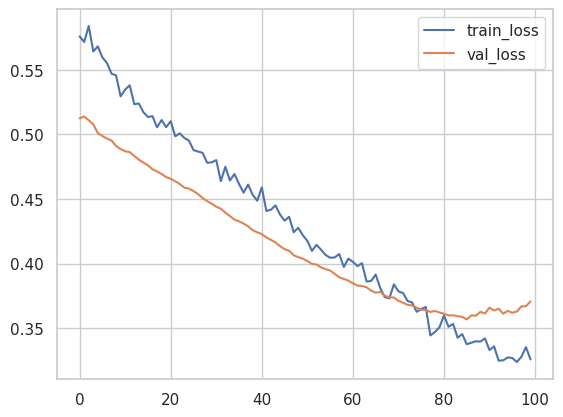

In [ ]:
###T#15/8/23
num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
batch_norm = best_hyperparameters['batch_norm']
dropout = best_hyperparameters['dropout']

best_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

best_model = DeepHitSingle(best_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

batch_size = best_hyperparameters['batch_size']
best_model.optimizer.set_lr(best_hyperparameters['lr'])

# Train on the entire training set
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience = best_hyperparameters['patience'] )]
log = best_model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
_ = log.plot()

# Evaluate on the test set
surv = best_model.predict_surv_df(x_test)
ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
c_index_test = ev_test.concordance_td('antolini')

print(f'Concordance index on test set: {c_index_test}')

# Calculate the integrated Brier score
ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))

print(f'Integrated Brier Score on test set: {ibs}')


0:	[0s / 0s],		train_loss: 0.1834,	val_loss: 0.1507
1:	[0s / 0s],		train_loss: 0.1532,	val_loss: 0.1360
2:	[0s / 0s],		train_loss: 0.1334,	val_loss: 0.1297
3:	[0s / 0s],		train_loss: 0.1334,	val_loss: 0.1277
4:	[0s / 0s],		train_loss: 0.1300,	val_loss: 0.1598
5:	[0s / 0s],		train_loss: 0.1340,	val_loss: 0.1315
6:	[0s / 0s],		train_loss: 0.1275,	val_loss: 0.1273
7:	[0s / 0s],		train_loss: 0.1302,	val_loss: 0.1316
8:	[0s / 0s],		train_loss: 0.1390,	val_loss: 0.1310
9:	[0s / 0s],		train_loss: 0.1330,	val_loss: 0.1327
10:	[0s / 0s],		train_loss: 0.1435,	val_loss: 0.1394
11:	[0s / 0s],		train_loss: 0.1397,	val_loss: 0.1356
12:	[0s / 1s],		train_loss: 0.1442,	val_loss: 0.1310
13:	[0s / 1s],		train_loss: 0.1403,	val_loss: 0.1325
14:	[0s / 1s],		train_loss: 0.1324,	val_loss: 0.1281
15:	[0s / 1s],		train_loss: 0.2045,	val_loss: 0.1473
16:	[0s / 1s],		train_loss: 0.1513,	val_loss: 0.1442
Concordance index on test set: 0.648731593321508
Integrated Brier Score on test set: 0.0896078084305159


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


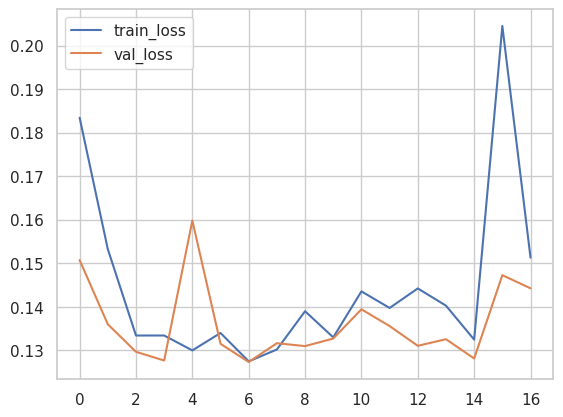

In [ ]:
# num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
# batch_norm = True if best_hyperparameters['activation_fn'] == 'relu' else False
# dropout = [best_hyperparameters['dropout']]

# best_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

# best_model = DeepHitSingle(best_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

# batch_size = best_hyperparameters['batch_size']
# best_model.optimizer.set_lr(best_hyperparameters['lr'])

# # Train on the entire training set
# epochs = 100
# callbacks = [tt.callbacks.EarlyStopping(patience = best_hyperparameters['patience'])]
# log = best_model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
# _ = log.plot()

# # Evaluate on the test set
# surv = best_model.predict_surv_df(x_test)
# ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
# c_index_test = ev_test.concordance_td('antolini')

# print(f'Concordance index on test set: {c_index_test}')

# # Calculate the integrated Brier score
# ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))

# print(f'Integrated Brier Score on test set: {ibs}')

In [ ]:
#15/8/23
from sklearn.utils import resample

# Number of bootstrap iterations
n_bootstrap_iterations = 50

# Arrays to store bootstrap C-indices and IBS scores
bootstrap_c_indices_deephit = np.zeros(n_bootstrap_iterations)
bootstrap_ibs_scores_deep_hit = np.zeros(n_bootstrap_iterations)

for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample of indices
    bootstrap_indices = resample(np.arange(len(x_train)), replace=True)

    # Use these indices to create bootstrap samples
    bootstrap_train_x = x_train[bootstrap_indices]
    bootstrap_train_y_times = y_train[0][bootstrap_indices]
    bootstrap_train_y_events = y_train[1][bootstrap_indices]

    #
    # Fit the model using the resampled training data with the best hyperparameters
    num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
    batch_norm = best_hyperparameters['batch_norm']
    dropout = best_hyperparameters['dropout']


    bootstrap_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    bootstrap_model = DeepHitSingle(bootstrap_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

    batch_size = best_hyperparameters['batch_size']
    bootstrap_model.optimizer.set_lr(best_hyperparameters['lr'])

    epochs = 100
    callbacks = [tt.callbacks.EarlyStopping()]
    log = bootstrap_model.fit(bootstrap_train_x, (bootstrap_train_y_times, bootstrap_train_y_events), batch_size, epochs, callbacks, val_data=val)
    # Evaluate on the test set
    surv = bootstrap_model.predict_surv_df(x_test)
    ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    c_index_test = ev_test.concordance_td('antolini')
    bootstrap_c_indices_deephit[i] = c_index_test

    # Calculate the integrated Brier score
    ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))
    bootstrap_ibs_scores_deep_hit[i] = ibs

# Compute the lower and upper percentiles for C-index
lower_percentile_c_index = np.percentile(bootstrap_c_indices_deephit, 2.5)
upper_percentile_c_index = np.percentile(bootstrap_c_indices_deephit, 97.5)

# Compute the lower and upper percentiles for IBS
lower_percentile_ibs = np.percentile(bootstrap_ibs_scores_deep_hit, 2.5)
upper_percentile_ibs = np.percentile(bootstrap_ibs_scores_deep_hit, 97.5)

print('Bootstrap 95% confidence interval for the C-index: ({:.2f}, {:.2f})'.format(lower_percentile_c_index, upper_percentile_c_index))
print('Bootstrap 95% confidence interval for the IBS: ({:.2f}, {:.2f})'.format(lower_percentile_ibs, upper_percentile_ibs))


0:	[0s / 0s],		train_loss: 0.5899,	val_loss: 0.5017
1:	[0s / 0s],		train_loss: 0.5818,	val_loss: 0.5022
2:	[0s / 0s],		train_loss: 0.5709,	val_loss: 0.4996
3:	[0s / 1s],		train_loss: 0.5632,	val_loss: 0.4966
4:	[0s / 1s],		train_loss: 0.5624,	val_loss: 0.4936
5:	[0s / 1s],		train_loss: 0.5479,	val_loss: 0.4911
6:	[0s / 2s],		train_loss: 0.5418,	val_loss: 0.4898
7:	[0s / 2s],		train_loss: 0.5295,	val_loss: 0.4862
8:	[0s / 2s],		train_loss: 0.5223,	val_loss: 0.4836
9:	[0s / 3s],		train_loss: 0.5318,	val_loss: 0.4820
10:	[0s / 3s],		train_loss: 0.5329,	val_loss: 0.4783
11:	[0s / 3s],		train_loss: 0.5200,	val_loss: 0.4782
12:	[0s / 4s],		train_loss: 0.5115,	val_loss: 0.4746
13:	[0s / 4s],		train_loss: 0.5129,	val_loss: 0.4735
14:	[0s / 4s],		train_loss: 0.5058,	val_loss: 0.4690
15:	[0s / 5s],		train_loss: 0.4980,	val_loss: 0.4661
16:	[0s / 5s],		train_loss: 0.5035,	val_loss: 0.4655
17:	[0s / 5s],		train_loss: 0.4946,	val_loss: 0.4643
18:	[0s / 5s],		train_loss: 0.5042,	val_loss: 0.4630
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6384,	val_loss: 0.5462
1:	[0s / 0s],		train_loss: 0.6103,	val_loss: 0.5490
2:	[0s / 0s],		train_loss: 0.6091,	val_loss: 0.5435
3:	[0s / 0s],		train_loss: 0.5909,	val_loss: 0.5387
4:	[0s / 0s],		train_loss: 0.5785,	val_loss: 0.5328
5:	[0s / 0s],		train_loss: 0.5818,	val_loss: 0.5294
6:	[0s / 0s],		train_loss: 0.5808,	val_loss: 0.5244
7:	[0s / 0s],		train_loss: 0.5551,	val_loss: 0.5188
8:	[0s / 0s],		train_loss: 0.5684,	val_loss: 0.5164
9:	[0s / 1s],		train_loss: 0.5454,	val_loss: 0.5142
10:	[0s / 1s],		train_loss: 0.5425,	val_loss: 0.5105
11:	[0s / 1s],		train_loss: 0.5452,	val_loss: 0.5056
12:	[0s / 1s],		train_loss: 0.5384,	val_loss: 0.5031
13:	[0s / 1s],		train_loss: 0.5478,	val_loss: 0.4999
14:	[0s / 1s],		train_loss: 0.5309,	val_loss: 0.4982
15:	[0s / 2s],		train_loss: 0.5193,	val_loss: 0.4954
16:	[0s / 2s],		train_loss: 0.5304,	val_loss: 0.4938
17:	[0s / 2s],		train_loss: 0.5187,	val_loss: 0.4915
18:	[0s / 2s],		train_loss: 0.5077,	val_loss: 0.4890
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6197,	val_loss: 0.5445
1:	[0s / 0s],		train_loss: 0.6012,	val_loss: 0.5452
2:	[0s / 0s],		train_loss: 0.5862,	val_loss: 0.5443
3:	[0s / 0s],		train_loss: 0.5794,	val_loss: 0.5405
4:	[0s / 0s],		train_loss: 0.5859,	val_loss: 0.5366
5:	[0s / 0s],		train_loss: 0.5653,	val_loss: 0.5309
6:	[0s / 0s],		train_loss: 0.5704,	val_loss: 0.5283
7:	[0s / 0s],		train_loss: 0.5700,	val_loss: 0.5254
8:	[0s / 0s],		train_loss: 0.5637,	val_loss: 0.5211
9:	[0s / 1s],		train_loss: 0.5433,	val_loss: 0.5185
10:	[0s / 1s],		train_loss: 0.5569,	val_loss: 0.5162
11:	[0s / 1s],		train_loss: 0.5437,	val_loss: 0.5128
12:	[0s / 1s],		train_loss: 0.5413,	val_loss: 0.5094
13:	[0s / 1s],		train_loss: 0.5433,	val_loss: 0.5061
14:	[0s / 1s],		train_loss: 0.5303,	val_loss: 0.5038
15:	[0s / 1s],		train_loss: 0.5337,	val_loss: 0.5023
16:	[0s / 1s],		train_loss: 0.5243,	val_loss: 0.4996
17:	[0s / 1s],		train_loss: 0.5204,	val_loss: 0.4982
18:	[0s / 2s],		train_loss: 0.5250,	val_loss: 0.4947
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.5999,	val_loss: 0.5114
2:	[0s / 0s],		train_loss: 0.6071,	val_loss: 0.5065
3:	[0s / 0s],		train_loss: 0.5823,	val_loss: 0.5018
4:	[0s / 0s],		train_loss: 0.5587,	val_loss: 0.4971
5:	[0s / 0s],		train_loss: 0.5585,	val_loss: 0.4962
6:	[0s / 0s],		train_loss: 0.5508,	val_loss: 0.4956
7:	[0s / 0s],		train_loss: 0.5470,	val_loss: 0.4919
8:	[0s / 0s],		train_loss: 0.5255,	val_loss: 0.4891
9:	[0s / 1s],		train_loss: 0.5372,	val_loss: 0.4883
10:	[0s / 1s],		train_loss: 0.5220,	val_loss: 0.4846
11:	[0s / 1s],		train_loss: 0.5190,	val_loss: 0.4838
12:	[0s / 1s],		train_loss: 0.5175,	val_loss: 0.4824
13:	[0s / 1s],		train_loss: 0.5188,	val_loss: 0.4785
14:	[0s / 1s],		train_loss: 0.5221,	val_loss: 0.4774
15:	[0s / 1s],		train_loss: 0.5081,	val_loss: 0.4760
16:	[0s / 1s],		train_loss: 0.4978,	val_loss: 0.4744
17:	[0s / 1s],		train_loss: 0.5021,	val_loss: 0.4732
18:	[0s / 1s],		train_loss: 0.4979,	val_loss: 0.4701
19:	[0s / 2s],		train_loss: 0.4931,	val_loss: 0.4700
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6107,	val_loss: 0.4960
1:	[0s / 0s],		train_loss: 0.5792,	val_loss: 0.4947
2:	[0s / 0s],		train_loss: 0.5758,	val_loss: 0.4923
3:	[0s / 0s],		train_loss: 0.5534,	val_loss: 0.4902
4:	[0s / 0s],		train_loss: 0.5471,	val_loss: 0.4840
5:	[0s / 0s],		train_loss: 0.5452,	val_loss: 0.4809
6:	[0s / 0s],		train_loss: 0.5444,	val_loss: 0.4767
7:	[0s / 0s],		train_loss: 0.5295,	val_loss: 0.4763
8:	[0s / 0s],		train_loss: 0.5341,	val_loss: 0.4734
9:	[0s / 1s],		train_loss: 0.5435,	val_loss: 0.4700
10:	[0s / 1s],		train_loss: 0.5281,	val_loss: 0.4676
11:	[0s / 1s],		train_loss: 0.5246,	val_loss: 0.4664
12:	[0s / 1s],		train_loss: 0.5225,	val_loss: 0.4630
13:	[0s / 1s],		train_loss: 0.5172,	val_loss: 0.4611
14:	[0s / 1s],		train_loss: 0.5100,	val_loss: 0.4582
15:	[0s / 1s],		train_loss: 0.5147,	val_loss: 0.4572
16:	[0s / 1s],		train_loss: 0.5039,	val_loss: 0.4544
17:	[0s / 1s],		train_loss: 0.5047,	val_loss: 0.4525
18:	[0s / 2s],		train_loss: 0.5033,	val_loss: 0.4501
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.5954,	val_loss: 0.5000
2:	[0s / 0s],		train_loss: 0.5805,	val_loss: 0.4996
3:	[0s / 0s],		train_loss: 0.5751,	val_loss: 0.4957
4:	[0s / 0s],		train_loss: 0.5607,	val_loss: 0.4945
5:	[0s / 0s],		train_loss: 0.5622,	val_loss: 0.4932
6:	[0s / 1s],		train_loss: 0.5531,	val_loss: 0.4914
7:	[0s / 1s],		train_loss: 0.5563,	val_loss: 0.4892
8:	[0s / 1s],		train_loss: 0.5450,	val_loss: 0.4870
9:	[0s / 1s],		train_loss: 0.5538,	val_loss: 0.4851
10:	[0s / 1s],		train_loss: 0.5380,	val_loss: 0.4830
11:	[0s / 1s],		train_loss: 0.5287,	val_loss: 0.4822
12:	[0s / 1s],		train_loss: 0.5314,	val_loss: 0.4796
13:	[0s / 2s],		train_loss: 0.5264,	val_loss: 0.4786
14:	[0s / 2s],		train_loss: 0.5210,	val_loss: 0.4757
15:	[0s / 2s],		train_loss: 0.5207,	val_loss: 0.4757
16:	[0s / 2s],		train_loss: 0.5180,	val_loss: 0.4734
17:	[0s / 2s],		train_loss: 0.5168,	val_loss: 0.4715
18:	[0s / 2s],		train_loss: 0.5101,	val_loss: 0.4692
19:	[0s / 3s],		train_loss: 0.5072,	val_loss: 0.4680
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.6108,	val_loss: 0.5148
2:	[0s / 0s],		train_loss: 0.5833,	val_loss: 0.5121
3:	[0s / 0s],		train_loss: 0.5704,	val_loss: 0.5085
4:	[0s / 0s],		train_loss: 0.5744,	val_loss: 0.5037
5:	[0s / 0s],		train_loss: 0.5639,	val_loss: 0.5001
6:	[0s / 0s],		train_loss: 0.5490,	val_loss: 0.4974
7:	[0s / 0s],		train_loss: 0.5457,	val_loss: 0.4950
8:	[0s / 0s],		train_loss: 0.5449,	val_loss: 0.4919
9:	[0s / 1s],		train_loss: 0.5392,	val_loss: 0.4906
10:	[0s / 1s],		train_loss: 0.5313,	val_loss: 0.4883
11:	[0s / 1s],		train_loss: 0.5331,	val_loss: 0.4857
12:	[0s / 1s],		train_loss: 0.5209,	val_loss: 0.4831
13:	[0s / 1s],		train_loss: 0.5233,	val_loss: 0.4806
14:	[0s / 1s],		train_loss: 0.5239,	val_loss: 0.4794
15:	[0s / 1s],		train_loss: 0.5254,	val_loss: 0.4774
16:	[0s / 1s],		train_loss: 0.5167,	val_loss: 0.4755
17:	[0s / 1s],		train_loss: 0.5073,	val_loss: 0.4726
18:	[0s / 1s],		train_loss: 0.5053,	val_loss: 0.4703
19:	[0s / 2s],		train_loss: 0.5100,	val_loss: 0.4685
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6006,	val_loss: 0.5148
1:	[0s / 0s],		train_loss: 0.5825,	val_loss: 0.5218
2:	[0s / 0s],		train_loss: 0.5766,	val_loss: 0.5216
3:	[0s / 0s],		train_loss: 0.5682,	val_loss: 0.5181
4:	[0s / 0s],		train_loss: 0.5454,	val_loss: 0.5150
5:	[0s / 0s],		train_loss: 0.5543,	val_loss: 0.5118
6:	[0s / 0s],		train_loss: 0.5482,	val_loss: 0.5060
7:	[0s / 0s],		train_loss: 0.5505,	val_loss: 0.5029
8:	[0s / 0s],		train_loss: 0.5385,	val_loss: 0.5000
9:	[0s / 1s],		train_loss: 0.5309,	val_loss: 0.4993
10:	[0s / 1s],		train_loss: 0.5279,	val_loss: 0.4952
11:	[0s / 1s],		train_loss: 0.5309,	val_loss: 0.4896
12:	[0s / 1s],		train_loss: 0.5205,	val_loss: 0.4856
13:	[0s / 1s],		train_loss: 0.5217,	val_loss: 0.4827
14:	[0s / 1s],		train_loss: 0.5023,	val_loss: 0.4805
15:	[0s / 1s],		train_loss: 0.5145,	val_loss: 0.4772
16:	[0s / 1s],		train_loss: 0.5094,	val_loss: 0.4739
17:	[0s / 1s],		train_loss: 0.5052,	val_loss: 0.4717
18:	[0s / 1s],		train_loss: 0.5048,	val_loss: 0.4687
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6117,	val_loss: 0.5131
1:	[0s / 0s],		train_loss: 0.5896,	val_loss: 0.5137
2:	[0s / 0s],		train_loss: 0.5751,	val_loss: 0.5112
3:	[0s / 0s],		train_loss: 0.5966,	val_loss: 0.5087
4:	[0s / 0s],		train_loss: 0.5588,	val_loss: 0.5071
5:	[0s / 0s],		train_loss: 0.5654,	val_loss: 0.5052
6:	[0s / 0s],		train_loss: 0.5677,	val_loss: 0.5012
7:	[0s / 0s],		train_loss: 0.5505,	val_loss: 0.4985
8:	[0s / 0s],		train_loss: 0.5544,	val_loss: 0.4979
9:	[0s / 1s],		train_loss: 0.5523,	val_loss: 0.4964
10:	[0s / 1s],		train_loss: 0.5437,	val_loss: 0.4929
11:	[0s / 1s],		train_loss: 0.5269,	val_loss: 0.4925
12:	[0s / 1s],		train_loss: 0.5443,	val_loss: 0.4895
13:	[0s / 1s],		train_loss: 0.5473,	val_loss: 0.4883
14:	[0s / 1s],		train_loss: 0.5312,	val_loss: 0.4876
15:	[0s / 1s],		train_loss: 0.5276,	val_loss: 0.4867
16:	[0s / 1s],		train_loss: 0.5244,	val_loss: 0.4850
17:	[0s / 1s],		train_loss: 0.5185,	val_loss: 0.4820
18:	[0s / 1s],		train_loss: 0.5090,	val_loss: 0.4805
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 0.5910,	val_loss: 0.5279
2:	[0s / 0s],		train_loss: 0.5905,	val_loss: 0.5256
3:	[0s / 0s],		train_loss: 0.5927,	val_loss: 0.5199
4:	[0s / 0s],		train_loss: 0.5618,	val_loss: 0.5143
5:	[0s / 0s],		train_loss: 0.5753,	val_loss: 0.5119
6:	[0s / 1s],		train_loss: 0.5689,	val_loss: 0.5088
7:	[0s / 1s],		train_loss: 0.5466,	val_loss: 0.5064
8:	[0s / 1s],		train_loss: 0.5376,	val_loss: 0.5032
9:	[0s / 1s],		train_loss: 0.5449,	val_loss: 0.5024
10:	[0s / 1s],		train_loss: 0.5421,	val_loss: 0.4988
11:	[0s / 1s],		train_loss: 0.5340,	val_loss: 0.4974
12:	[0s / 1s],		train_loss: 0.5411,	val_loss: 0.4932
13:	[0s / 1s],		train_loss: 0.5415,	val_loss: 0.4921
14:	[0s / 1s],		train_loss: 0.5277,	val_loss: 0.4914
15:	[0s / 2s],		train_loss: 0.5298,	val_loss: 0.4877
16:	[0s / 2s],		train_loss: 0.5300,	val_loss: 0.4843
17:	[0s / 2s],		train_loss: 0.5105,	val_loss: 0.4845
18:	[0s / 2s],		train_loss: 0.5156,	val_loss: 0.4817
19:	[0s / 2s],		train_loss: 0.5106,	val_loss: 0.4810
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6431,	val_loss: 0.5232
1:	[0s / 0s],		train_loss: 0.6264,	val_loss: 0.5214
2:	[0s / 0s],		train_loss: 0.6235,	val_loss: 0.5190
3:	[0s / 0s],		train_loss: 0.6031,	val_loss: 0.5152
4:	[0s / 0s],		train_loss: 0.5964,	val_loss: 0.5135
5:	[0s / 0s],		train_loss: 0.5887,	val_loss: 0.5090
6:	[0s / 0s],		train_loss: 0.6071,	val_loss: 0.5062
7:	[0s / 1s],		train_loss: 0.5872,	val_loss: 0.5033
8:	[0s / 1s],		train_loss: 0.5922,	val_loss: 0.5024
9:	[0s / 1s],		train_loss: 0.5737,	val_loss: 0.5001
10:	[0s / 1s],		train_loss: 0.5739,	val_loss: 0.4976
11:	[0s / 1s],		train_loss: 0.5693,	val_loss: 0.4943
12:	[0s / 1s],		train_loss: 0.5776,	val_loss: 0.4934
13:	[0s / 1s],		train_loss: 0.5666,	val_loss: 0.4924
14:	[0s / 2s],		train_loss: 0.5569,	val_loss: 0.4904
15:	[0s / 2s],		train_loss: 0.5625,	val_loss: 0.4891
16:	[0s / 2s],		train_loss: 0.5533,	val_loss: 0.4869
17:	[0s / 2s],		train_loss: 0.5445,	val_loss: 0.4857
18:	[0s / 2s],		train_loss: 0.5393,	val_loss: 0.4827
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6222,	val_loss: 0.5165
1:	[0s / 0s],		train_loss: 0.6235,	val_loss: 0.5192
2:	[0s / 0s],		train_loss: 0.5834,	val_loss: 0.5200
3:	[0s / 0s],		train_loss: 0.5837,	val_loss: 0.5169
4:	[0s / 0s],		train_loss: 0.5815,	val_loss: 0.5164
5:	[0s / 0s],		train_loss: 0.5683,	val_loss: 0.5128
6:	[0s / 0s],		train_loss: 0.5670,	val_loss: 0.5100
7:	[0s / 0s],		train_loss: 0.5590,	val_loss: 0.5063
8:	[0s / 0s],		train_loss: 0.5643,	val_loss: 0.5041
9:	[0s / 1s],		train_loss: 0.5537,	val_loss: 0.5036
10:	[0s / 1s],		train_loss: 0.5553,	val_loss: 0.5001
11:	[0s / 1s],		train_loss: 0.5411,	val_loss: 0.4982
12:	[0s / 1s],		train_loss: 0.5271,	val_loss: 0.4953
13:	[0s / 1s],		train_loss: 0.5522,	val_loss: 0.4932
14:	[0s / 1s],		train_loss: 0.5340,	val_loss: 0.4902
15:	[0s / 1s],		train_loss: 0.5231,	val_loss: 0.4876
16:	[0s / 1s],		train_loss: 0.5159,	val_loss: 0.4859
17:	[0s / 1s],		train_loss: 0.5221,	val_loss: 0.4866
18:	[0s / 1s],		train_loss: 0.5194,	val_loss: 0.4846
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.6272,	val_loss: 0.5113
1:	[0s / 0s],		train_loss: 0.6475,	val_loss: 0.5094
2:	[0s / 0s],		train_loss: 0.6131,	val_loss: 0.5057
3:	[0s / 0s],		train_loss: 0.6302,	val_loss: 0.5023
4:	[0s / 0s],		train_loss: 0.5864,	val_loss: 0.5002
5:	[0s / 0s],		train_loss: 0.5820,	val_loss: 0.4976
6:	[0s / 0s],		train_loss: 0.5729,	val_loss: 0.4930
7:	[0s / 0s],		train_loss: 0.5715,	val_loss: 0.4891
8:	[0s / 0s],		train_loss: 0.5634,	val_loss: 0.4863
9:	[0s / 1s],		train_loss: 0.5689,	val_loss: 0.4840
10:	[0s / 1s],		train_loss: 0.5622,	val_loss: 0.4810
11:	[0s / 1s],		train_loss: 0.5639,	val_loss: 0.4802
12:	[0s / 1s],		train_loss: 0.5718,	val_loss: 0.4768
13:	[0s / 1s],		train_loss: 0.5419,	val_loss: 0.4765
14:	[0s / 1s],		train_loss: 0.5518,	val_loss: 0.4749
15:	[0s / 1s],		train_loss: 0.5543,	val_loss: 0.4726
16:	[0s / 1s],		train_loss: 0.5392,	val_loss: 0.4704
17:	[0s / 1s],		train_loss: 0.5460,	val_loss: 0.4702
18:	[0s / 1s],		train_loss: 0.5314,	val_loss: 0.4689
19:

KeyboardInterrupt: ignored

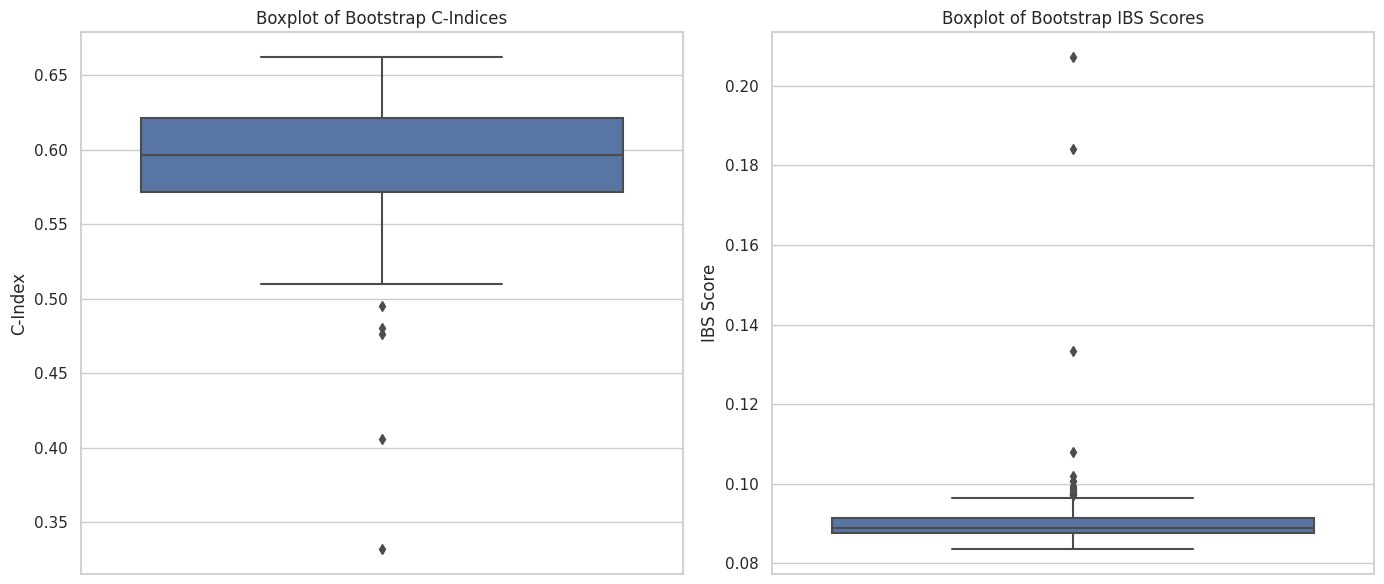

In [ ]:
# Boostrapped estimates 15/8/23
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(14, 6))

# Subplot for C-index
plt.subplot(1, 2, 1)
sns.boxplot(y=bootstrap_c_indices_deephit)
plt.title("Boxplot of Bootstrap C-Indices")
plt.ylabel("C-Index")

# Subplot for IBS
plt.subplot(1, 2, 2)
sns.boxplot(y=bootstrap_ibs_scores_deep_hit)
plt.title("Boxplot of Bootstrap IBS Scores")
plt.ylabel("IBS Score")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_c_indices_deephit.npy', bootstrap_c_indices_deephit)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_ibs_scores_deep_hit.npy', bootstrap_ibs_scores_deep_hit)


In [ ]:
## This gives;
## - Bootstrap 95% confidence interval for the C-index: (0.50, 0.63)
## - Bootstrap 95% confidence interval for the IBS: (0.09, 0.13)
best_hyperparameters = {'batch_size': 32, 'layers': 5, 'nodes': 300, 'activation_fn': 'elu', 'alpha': 0.1, 'sigma': 0.5, 'lr': 0.001, 'dropout': 0.3, 'patience': 30}

In [ ]:
best_hyperparameters = {'batch_size': 32, 'layers': 5, 'nodes': 50, 'activation_fn': 'elu', 'alpha': 0.1, 'sigma': 0.1, 'lr': 0.01}

In [ ]:
from sklearn.utils import resample

# Number of bootstrap iterations
n_bootstrap_iterations = 50

# Arrays to store bootstrap C-indices and IBS scores
bootstrap_c_indices_deephit = np.zeros(n_bootstrap_iterations)
bootstrap_ibs_scores_deep_hit = np.zeros(n_bootstrap_iterations)

best_hyperparameters = {
    'batch_size': 32,
    'layers': 5,
    'nodes': 50,
    'activation_fn': 'elu',
    'alpha': 0.1,
    'sigma': 0.1,
    'lr': 0.01
}

for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample of indices
    bootstrap_indices = resample(np.arange(len(x_train)), replace=True)

    # Use these indices to create bootstrap samples
    bootstrap_train_x = x_train[bootstrap_indices]
    bootstrap_train_y_times = y_train[0][bootstrap_indices]
    bootstrap_train_y_events = y_train[1][bootstrap_indices]

    # Fit the model using the resampled training data with the best hyperparameters
    num_nodes = [best_hyperparameters['nodes']] * best_hyperparameters['layers']
    batch_norm = False
    dropout = 0.4

    bootstrap_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    bootstrap_model = DeepHitSingle(bootstrap_net, tt.optim.Adam, alpha=best_hyperparameters['alpha'], sigma=best_hyperparameters['sigma'], duration_index=labtrans.cuts)

    batch_size = best_hyperparameters['batch_size']
    bootstrap_model.optimizer.set_lr(best_hyperparameters['lr'])

    epochs = 100
    callbacks = [tt.callbacks.EarlyStopping()]
    log = bootstrap_model.fit(bootstrap_train_x, (bootstrap_train_y_times, bootstrap_train_y_events), batch_size, epochs, callbacks, val_data=val)

    # Evaluate on the test set
    surv = bootstrap_model.predict_surv_df(x_test)
    ev_test = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    c_index_test = ev_test.concordance_td('antolini')
    bootstrap_c_indices_deephit[i] = c_index_test

    # Calculate the integrated Brier score
    ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, durations_test.max(), 100))
    bootstrap_ibs_scores_deep_hit[i] = ibs

# Compute the lower and upper percentiles for C-index
lower_percentile_c_index = np.percentile(bootstrap_c_indices_deephit, 2.5)
upper_percentile_c_index = np.percentile(bootstrap_c_indices_deephit, 97.5)

# Compute the lower and upper percentiles for IBS
lower_percentile_ibs = np.percentile(bootstrap_ibs_scores_deep_hit, 2.5)
upper_percentile_ibs = np.percentile(bootstrap_ibs_scores_deep_hit, 97.5)

print('Bootstrap 95% confidence interval for the C-index: ({:.2f}, {:.2f})'.format(lower_percentile_c_index, upper_percentile_c_index))
print('Bootstrap 95% confidence interval for the IBS: ({:.2f}, {:.2f})'.format(lower_percentile_ibs, upper_percentile_ibs))


0:	[0s / 0s],		train_loss: 0.2157,	val_loss: 0.1499
1:	[0s / 0s],		train_loss: 0.1603,	val_loss: 0.1417
2:	[0s / 0s],		train_loss: 0.1450,	val_loss: 0.1308
3:	[0s / 1s],		train_loss: 0.1420,	val_loss: 0.1255
4:	[0s / 1s],		train_loss: 0.1310,	val_loss: 0.1212
5:	[0s / 1s],		train_loss: 0.1230,	val_loss: 0.1172
6:	[0s / 1s],		train_loss: 0.1197,	val_loss: 0.1159
7:	[0s / 2s],		train_loss: 0.1191,	val_loss: 0.1150
8:	[0s / 2s],		train_loss: 0.1177,	val_loss: 0.1159
9:	[0s / 2s],		train_loss: 0.1161,	val_loss: 0.1155
10:	[0s / 2s],		train_loss: 0.1150,	val_loss: 0.1143
11:	[0s / 3s],		train_loss: 0.1158,	val_loss: 0.1157
12:	[0s / 3s],		train_loss: 0.1142,	val_loss: 0.1149
13:	[0s / 3s],		train_loss: 0.1152,	val_loss: 0.1151
14:	[0s / 4s],		train_loss: 0.1147,	val_loss: 0.1157
15:	[0s / 4s],		train_loss: 0.1143,	val_loss: 0.1155
16:	[0s / 4s],		train_loss: 0.1134,	val_loss: 0.1154
17:	[0s / 4s],		train_loss: 0.1110,	val_loss: 0.1193
18:	[0s / 5s],		train_loss: 0.1119,	val_loss: 0.1173
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2198,	val_loss: 0.1195
1:	[0s / 0s],		train_loss: 0.1573,	val_loss: 0.1205
2:	[0s / 0s],		train_loss: 0.1526,	val_loss: 0.1150
3:	[0s / 1s],		train_loss: 0.1467,	val_loss: 0.1141
4:	[0s / 1s],		train_loss: 0.1400,	val_loss: 0.1143
5:	[0s / 1s],		train_loss: 0.1336,	val_loss: 0.1130
6:	[0s / 2s],		train_loss: 0.1328,	val_loss: 0.1164
7:	[0s / 2s],		train_loss: 0.1355,	val_loss: 0.1153
8:	[0s / 3s],		train_loss: 0.1300,	val_loss: 0.1172
9:	[0s / 3s],		train_loss: 0.1277,	val_loss: 0.1162
10:	[0s / 3s],		train_loss: 0.1256,	val_loss: 0.1181
11:	[0s / 4s],		train_loss: 0.1281,	val_loss: 0.1186
12:	[0s / 4s],		train_loss: 0.1318,	val_loss: 0.1180
13:	[0s / 5s],		train_loss: 0.1259,	val_loss: 0.1194
14:	[0s / 5s],		train_loss: 0.1261,	val_loss: 0.1219
15:	[0s / 5s],		train_loss: 0.1243,	val_loss: 0.1239


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2476,	val_loss: 0.1233
1:	[0s / 0s],		train_loss: 0.1555,	val_loss: 0.1172
2:	[0s / 0s],		train_loss: 0.1340,	val_loss: 0.1163
3:	[0s / 1s],		train_loss: 0.1295,	val_loss: 0.1154
4:	[0s / 1s],		train_loss: 0.1279,	val_loss: 0.1144
5:	[0s / 1s],		train_loss: 0.1257,	val_loss: 0.1147
6:	[0s / 1s],		train_loss: 0.1254,	val_loss: 0.1138
7:	[0s / 2s],		train_loss: 0.1223,	val_loss: 0.1148
8:	[0s / 2s],		train_loss: 0.1216,	val_loss: 0.1137
9:	[0s / 2s],		train_loss: 0.1163,	val_loss: 0.1158
10:	[0s / 2s],		train_loss: 0.1156,	val_loss: 0.1141
11:	[0s / 3s],		train_loss: 0.1139,	val_loss: 0.1209
12:	[0s / 3s],		train_loss: 0.1187,	val_loss: 0.1187
13:	[0s / 3s],		train_loss: 0.1214,	val_loss: 0.1231
14:	[0s / 4s],		train_loss: 0.1192,	val_loss: 0.1161
15:	[0s / 4s],		train_loss: 0.1143,	val_loss: 0.1159
16:	[0s / 4s],		train_loss: 0.1126,	val_loss: 0.1298
17:	[0s / 4s],		train_loss: 0.1117,	val_loss: 0.1204
18:	[0s / 5s],		train_loss: 0.1315,	val_loss: 0.1199


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1798,	val_loss: 0.1195
1:	[0s / 0s],		train_loss: 0.1473,	val_loss: 0.1155
2:	[0s / 0s],		train_loss: 0.1351,	val_loss: 0.1155
3:	[0s / 1s],		train_loss: 0.1301,	val_loss: 0.1149
4:	[0s / 1s],		train_loss: 0.1291,	val_loss: 0.1164
5:	[0s / 1s],		train_loss: 0.1275,	val_loss: 0.1149
6:	[0s / 1s],		train_loss: 0.1252,	val_loss: 0.1149
7:	[0s / 2s],		train_loss: 0.1226,	val_loss: 0.1139
8:	[0s / 2s],		train_loss: 0.1198,	val_loss: 0.1183
9:	[0s / 2s],		train_loss: 0.1189,	val_loss: 0.1199
10:	[0s / 3s],		train_loss: 0.1589,	val_loss: 0.1141
11:	[0s / 3s],		train_loss: 0.1265,	val_loss: 0.1147
12:	[0s / 3s],		train_loss: 0.1226,	val_loss: 0.1150
13:	[0s / 3s],		train_loss: 0.1231,	val_loss: 0.1147
14:	[0s / 4s],		train_loss: 0.1229,	val_loss: 0.1176
15:	[0s / 4s],		train_loss: 0.1226,	val_loss: 0.1160
16:	[0s / 4s],		train_loss: 0.1181,	val_loss: 0.1194
17:	[0s / 5s],		train_loss: 0.1205,	val_loss: 0.1163


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2888,	val_loss: 0.1209
1:	[0s / 0s],		train_loss: 0.1691,	val_loss: 0.1223
2:	[0s / 1s],		train_loss: 0.1578,	val_loss: 0.1151
3:	[0s / 1s],		train_loss: 0.1491,	val_loss: 0.1176
4:	[0s / 2s],		train_loss: 0.1440,	val_loss: 0.1159
5:	[0s / 2s],		train_loss: 0.1620,	val_loss: 0.1183
6:	[0s / 2s],		train_loss: 0.1402,	val_loss: 0.1160
7:	[0s / 3s],		train_loss: 0.1370,	val_loss: 0.1142
8:	[0s / 3s],		train_loss: 0.1280,	val_loss: 0.1141
9:	[0s / 4s],		train_loss: 0.1363,	val_loss: 0.1146
10:	[0s / 4s],		train_loss: 0.1292,	val_loss: 0.1131
11:	[0s / 4s],		train_loss: 0.1300,	val_loss: 0.1138
12:	[0s / 4s],		train_loss: 0.1290,	val_loss: 0.1134
13:	[0s / 5s],		train_loss: 0.1283,	val_loss: 0.1138
14:	[0s / 5s],		train_loss: 0.1249,	val_loss: 0.1147
15:	[0s / 5s],		train_loss: 0.1264,	val_loss: 0.1130
16:	[0s / 6s],		train_loss: 0.1268,	val_loss: 0.1122
17:	[0s / 6s],		train_loss: 0.1229,	val_loss: 0.1133
18:	[0s / 6s],		train_loss: 0.1208,	val_loss: 0.1137
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2236,	val_loss: 0.1246
1:	[0s / 0s],		train_loss: 0.1527,	val_loss: 0.1207
2:	[0s / 0s],		train_loss: 0.1504,	val_loss: 0.1187
3:	[0s / 1s],		train_loss: 0.1371,	val_loss: 0.1182
4:	[0s / 1s],		train_loss: 0.1315,	val_loss: 0.1145
5:	[0s / 1s],		train_loss: 0.1329,	val_loss: 0.1172
6:	[0s / 1s],		train_loss: 0.1302,	val_loss: 0.1161
7:	[0s / 2s],		train_loss: 0.1287,	val_loss: 0.1150
8:	[0s / 2s],		train_loss: 0.1289,	val_loss: 0.1153
9:	[0s / 2s],		train_loss: 0.1254,	val_loss: 0.1135
10:	[0s / 3s],		train_loss: 0.1242,	val_loss: 0.1166
11:	[0s / 3s],		train_loss: 0.1220,	val_loss: 0.1227
12:	[0s / 3s],		train_loss: 0.1222,	val_loss: 0.1173
13:	[0s / 3s],		train_loss: 0.1195,	val_loss: 0.1204
14:	[0s / 4s],		train_loss: 0.1181,	val_loss: 0.1200
15:	[0s / 4s],		train_loss: 0.1206,	val_loss: 0.1176
16:	[0s / 4s],		train_loss: 0.2071,	val_loss: 0.1181
17:	[0s / 4s],		train_loss: 0.1672,	val_loss: 0.1182
18:	[0s / 5s],		train_loss: 0.1380,	val_loss: 0.1175
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2125,	val_loss: 0.1168
1:	[0s / 0s],		train_loss: 0.1626,	val_loss: 0.1151
2:	[0s / 1s],		train_loss: 0.1477,	val_loss: 0.1142
3:	[0s / 1s],		train_loss: 0.1380,	val_loss: 0.1158
4:	[0s / 2s],		train_loss: 0.1355,	val_loss: 0.1146
5:	[0s / 2s],		train_loss: 0.1373,	val_loss: 0.1140
6:	[0s / 2s],		train_loss: 0.1333,	val_loss: 0.1141
7:	[0s / 3s],		train_loss: 0.1302,	val_loss: 0.1131
8:	[0s / 3s],		train_loss: 0.1292,	val_loss: 0.1123
9:	[0s / 4s],		train_loss: 0.1283,	val_loss: 0.1135
10:	[0s / 4s],		train_loss: 0.1271,	val_loss: 0.1128
11:	[0s / 4s],		train_loss: 0.1289,	val_loss: 0.1141
12:	[0s / 5s],		train_loss: 0.1252,	val_loss: 0.1170
13:	[0s / 5s],		train_loss: 0.1338,	val_loss: 0.1161
14:	[0s / 5s],		train_loss: 0.1287,	val_loss: 0.1144
15:	[0s / 5s],		train_loss: 0.1276,	val_loss: 0.1186
16:	[0s / 6s],		train_loss: 0.1296,	val_loss: 0.1163
17:	[0s / 6s],		train_loss: 0.1276,	val_loss: 0.1142
18:	[0s / 6s],		train_loss: 0.1356,	val_loss: 0.1146


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1908,	val_loss: 0.1182
1:	[0s / 0s],		train_loss: 0.1542,	val_loss: 0.1158
2:	[0s / 0s],		train_loss: 0.1423,	val_loss: 0.1157
3:	[0s / 1s],		train_loss: 0.1316,	val_loss: 0.1142
4:	[0s / 1s],		train_loss: 0.1340,	val_loss: 0.1144
5:	[0s / 1s],		train_loss: 0.1309,	val_loss: 0.1130
6:	[0s / 1s],		train_loss: 0.1258,	val_loss: 0.1138
7:	[0s / 2s],		train_loss: 0.1247,	val_loss: 0.1128
8:	[0s / 2s],		train_loss: 0.1293,	val_loss: 0.1133
9:	[0s / 2s],		train_loss: 0.1280,	val_loss: 0.1121
10:	[0s / 3s],		train_loss: 0.1286,	val_loss: 0.1127
11:	[0s / 3s],		train_loss: 0.1221,	val_loss: 0.1134
12:	[0s / 3s],		train_loss: 0.1206,	val_loss: 0.1141
13:	[0s / 3s],		train_loss: 0.1270,	val_loss: 0.1158
14:	[0s / 4s],		train_loss: 0.1302,	val_loss: 0.1168
15:	[0s / 4s],		train_loss: 0.1258,	val_loss: 0.1223
16:	[0s / 4s],		train_loss: 0.1230,	val_loss: 0.1184
17:	[0s / 4s],		train_loss: 0.1199,	val_loss: 0.1173
18:	[0s / 5s],		train_loss: 0.1288,	val_loss: 0.1175
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1811,	val_loss: 0.1205
1:	[0s / 0s],		train_loss: 0.1349,	val_loss: 0.1190
2:	[0s / 0s],		train_loss: 0.1351,	val_loss: 0.1147
3:	[0s / 1s],		train_loss: 0.1365,	val_loss: 0.1154
4:	[0s / 1s],		train_loss: 0.1268,	val_loss: 0.1153
5:	[0s / 1s],		train_loss: 0.1279,	val_loss: 0.1140
6:	[0s / 1s],		train_loss: 0.1266,	val_loss: 0.1135
7:	[0s / 2s],		train_loss: 0.1228,	val_loss: 0.1127
8:	[0s / 2s],		train_loss: 0.1250,	val_loss: 0.1123
9:	[0s / 2s],		train_loss: 0.1207,	val_loss: 0.1119
10:	[0s / 3s],		train_loss: 0.1175,	val_loss: 0.1153
11:	[0s / 3s],		train_loss: 0.1195,	val_loss: 0.1170
12:	[0s / 4s],		train_loss: 0.1177,	val_loss: 0.1117
13:	[0s / 4s],		train_loss: 0.1166,	val_loss: 0.1150
14:	[0s / 5s],		train_loss: 0.1166,	val_loss: 0.1122
15:	[1s / 6s],		train_loss: 0.1158,	val_loss: 0.1129
16:	[0s / 6s],		train_loss: 0.1187,	val_loss: 0.1153
17:	[0s / 7s],		train_loss: 0.1207,	val_loss: 0.1174
18:	[0s / 7s],		train_loss: 0.1141,	val_loss: 0.1142
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1721,	val_loss: 0.1259
1:	[0s / 0s],		train_loss: 0.1463,	val_loss: 0.1195
2:	[0s / 0s],		train_loss: 0.1417,	val_loss: 0.1149
3:	[0s / 1s],		train_loss: 0.1332,	val_loss: 0.1155
4:	[0s / 1s],		train_loss: 0.1258,	val_loss: 0.1150
5:	[0s / 1s],		train_loss: 0.1307,	val_loss: 0.1161
6:	[0s / 1s],		train_loss: 0.1281,	val_loss: 0.1152
7:	[0s / 2s],		train_loss: 0.1224,	val_loss: 0.1153
8:	[0s / 2s],		train_loss: 0.1243,	val_loss: 0.1162
9:	[0s / 2s],		train_loss: 0.1218,	val_loss: 0.1149
10:	[0s / 2s],		train_loss: 0.1240,	val_loss: 0.1153
11:	[0s / 3s],		train_loss: 0.1209,	val_loss: 0.1161
12:	[0s / 3s],		train_loss: 0.1155,	val_loss: 0.1237
13:	[0s / 3s],		train_loss: 0.1202,	val_loss: 0.1177
14:	[0s / 4s],		train_loss: 0.1159,	val_loss: 0.1209
15:	[0s / 4s],		train_loss: 0.1159,	val_loss: 0.1240
16:	[0s / 4s],		train_loss: 0.1153,	val_loss: 0.1239
17:	[0s / 4s],		train_loss: 0.1128,	val_loss: 0.1260
18:	[0s / 5s],		train_loss: 0.1154,	val_loss: 0.1203
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2403,	val_loss: 0.1465
1:	[0s / 0s],		train_loss: 0.1671,	val_loss: 0.1314
2:	[0s / 0s],		train_loss: 0.1536,	val_loss: 0.1204
3:	[0s / 1s],		train_loss: 0.1309,	val_loss: 0.1180
4:	[0s / 1s],		train_loss: 0.1323,	val_loss: 0.1180
5:	[0s / 1s],		train_loss: 0.1209,	val_loss: 0.1169
6:	[0s / 1s],		train_loss: 0.1235,	val_loss: 0.1155
7:	[0s / 2s],		train_loss: 0.1181,	val_loss: 0.1140
8:	[0s / 2s],		train_loss: 0.1196,	val_loss: 0.1172
9:	[0s / 2s],		train_loss: 0.1215,	val_loss: 0.1148
10:	[0s / 3s],		train_loss: 0.1147,	val_loss: 0.1181
11:	[0s / 3s],		train_loss: 0.1193,	val_loss: 0.1169
12:	[0s / 3s],		train_loss: 0.1136,	val_loss: 0.1203
13:	[0s / 4s],		train_loss: 0.1120,	val_loss: 0.1210
14:	[0s / 4s],		train_loss: 0.1134,	val_loss: 0.1238
15:	[0s / 4s],		train_loss: 0.1121,	val_loss: 0.1192
16:	[0s / 5s],		train_loss: 0.1137,	val_loss: 0.1258
17:	[0s / 5s],		train_loss: 0.1136,	val_loss: 0.1251


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1948,	val_loss: 0.1192
1:	[0s / 0s],		train_loss: 0.1606,	val_loss: 0.1151
2:	[0s / 1s],		train_loss: 0.1388,	val_loss: 0.1160
3:	[0s / 1s],		train_loss: 0.1354,	val_loss: 0.1142
4:	[0s / 2s],		train_loss: 0.1312,	val_loss: 0.1148
5:	[0s / 2s],		train_loss: 0.1282,	val_loss: 0.1158
6:	[0s / 2s],		train_loss: 0.1253,	val_loss: 0.1155
7:	[0s / 2s],		train_loss: 0.1257,	val_loss: 0.1171
8:	[0s / 3s],		train_loss: 0.1229,	val_loss: 0.1174
9:	[0s / 3s],		train_loss: 0.1243,	val_loss: 0.1208
10:	[0s / 3s],		train_loss: 0.1246,	val_loss: 0.1156
11:	[0s / 4s],		train_loss: 0.1203,	val_loss: 0.1159
12:	[0s / 4s],		train_loss: 0.1209,	val_loss: 0.1210
13:	[0s / 4s],		train_loss: 0.1194,	val_loss: 0.1173


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1652,	val_loss: 0.1165
1:	[0s / 0s],		train_loss: 0.1466,	val_loss: 0.1161
2:	[0s / 0s],		train_loss: 0.1401,	val_loss: 0.1141
3:	[0s / 1s],		train_loss: 0.1387,	val_loss: 0.1132
4:	[0s / 1s],		train_loss: 0.1351,	val_loss: 0.1147
5:	[0s / 1s],		train_loss: 0.1322,	val_loss: 0.1136
6:	[0s / 1s],		train_loss: 0.1294,	val_loss: 0.1141
7:	[0s / 2s],		train_loss: 0.1285,	val_loss: 0.1128
8:	[0s / 2s],		train_loss: 0.1243,	val_loss: 0.1131
9:	[0s / 2s],		train_loss: 0.1272,	val_loss: 0.1161
10:	[0s / 2s],		train_loss: 0.1210,	val_loss: 0.1147
11:	[0s / 3s],		train_loss: 0.1223,	val_loss: 0.1152
12:	[0s / 3s],		train_loss: 0.1240,	val_loss: 0.1175
13:	[0s / 3s],		train_loss: 0.1260,	val_loss: 0.1179
14:	[0s / 4s],		train_loss: 0.1330,	val_loss: 0.1236
15:	[0s / 4s],		train_loss: 0.1263,	val_loss: 0.1171
16:	[0s / 4s],		train_loss: 0.1254,	val_loss: 0.1167
17:	[0s / 4s],		train_loss: 0.1280,	val_loss: 0.1149


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2080,	val_loss: 0.1264
1:	[0s / 0s],		train_loss: 0.1573,	val_loss: 0.1173
2:	[0s / 0s],		train_loss: 0.1397,	val_loss: 0.1160
3:	[0s / 1s],		train_loss: 0.1391,	val_loss: 0.1171
4:	[0s / 1s],		train_loss: 0.1335,	val_loss: 0.1168
5:	[0s / 1s],		train_loss: 0.1304,	val_loss: 0.1152
6:	[0s / 1s],		train_loss: 0.1270,	val_loss: 0.1159
7:	[0s / 2s],		train_loss: 0.1273,	val_loss: 0.1158
8:	[0s / 2s],		train_loss: 0.1247,	val_loss: 0.1222
9:	[0s / 2s],		train_loss: 0.1232,	val_loss: 0.1157
10:	[0s / 3s],		train_loss: 0.1248,	val_loss: 0.1152
11:	[0s / 3s],		train_loss: 0.1238,	val_loss: 0.1174
12:	[0s / 4s],		train_loss: 0.1225,	val_loss: 0.1204
13:	[0s / 4s],		train_loss: 0.1216,	val_loss: 0.1197
14:	[0s / 4s],		train_loss: 0.1174,	val_loss: 0.1243
15:	[0s / 5s],		train_loss: 0.1159,	val_loss: 0.1193


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2136,	val_loss: 0.1341
1:	[0s / 0s],		train_loss: 0.1499,	val_loss: 0.1208
2:	[0s / 1s],		train_loss: 0.1425,	val_loss: 0.1158
3:	[0s / 1s],		train_loss: 0.1309,	val_loss: 0.1167
4:	[0s / 2s],		train_loss: 0.1239,	val_loss: 0.1161
5:	[0s / 2s],		train_loss: 0.1238,	val_loss: 0.1141
6:	[0s / 2s],		train_loss: 0.1256,	val_loss: 0.1131
7:	[0s / 2s],		train_loss: 0.1206,	val_loss: 0.1136
8:	[0s / 3s],		train_loss: 0.1204,	val_loss: 0.1139
9:	[0s / 3s],		train_loss: 0.1213,	val_loss: 0.1155
10:	[0s / 3s],		train_loss: 0.1176,	val_loss: 0.1197
11:	[0s / 4s],		train_loss: 0.1175,	val_loss: 0.1157
12:	[0s / 4s],		train_loss: 0.1174,	val_loss: 0.1170
13:	[0s / 4s],		train_loss: 0.1141,	val_loss: 0.1146
14:	[0s / 4s],		train_loss: 0.1150,	val_loss: 0.1173
15:	[0s / 5s],		train_loss: 0.1137,	val_loss: 0.1152
16:	[0s / 5s],		train_loss: 0.1128,	val_loss: 0.1207


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2342,	val_loss: 0.1243
1:	[0s / 0s],		train_loss: 0.1541,	val_loss: 0.1250
2:	[0s / 0s],		train_loss: 0.1425,	val_loss: 0.1165
3:	[0s / 1s],		train_loss: 0.1381,	val_loss: 0.1163
4:	[0s / 1s],		train_loss: 0.1301,	val_loss: 0.1180
5:	[0s / 1s],		train_loss: 0.1288,	val_loss: 0.1161
6:	[0s / 1s],		train_loss: 0.1214,	val_loss: 0.1146
7:	[0s / 2s],		train_loss: 0.1197,	val_loss: 0.1181
8:	[0s / 2s],		train_loss: 0.1213,	val_loss: 0.1158
9:	[0s / 2s],		train_loss: 0.1201,	val_loss: 0.1171
10:	[0s / 3s],		train_loss: 0.1164,	val_loss: 0.1165
11:	[0s / 3s],		train_loss: 0.1159,	val_loss: 0.1161
12:	[0s / 3s],		train_loss: 0.1151,	val_loss: 0.1183
13:	[0s / 3s],		train_loss: 0.1128,	val_loss: 0.1230
14:	[0s / 4s],		train_loss: 0.1134,	val_loss: 0.1224
15:	[0s / 4s],		train_loss: 0.1125,	val_loss: 0.1210
16:	[0s / 4s],		train_loss: 0.1123,	val_loss: 0.1213


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1878,	val_loss: 0.1186
1:	[0s / 0s],		train_loss: 0.1487,	val_loss: 0.1186
2:	[0s / 0s],		train_loss: 0.1372,	val_loss: 0.1182
3:	[0s / 1s],		train_loss: 0.1282,	val_loss: 0.1174
4:	[0s / 1s],		train_loss: 0.1222,	val_loss: 0.1151
5:	[0s / 1s],		train_loss: 0.1238,	val_loss: 0.1153
6:	[0s / 1s],		train_loss: 0.1205,	val_loss: 0.1161
7:	[0s / 2s],		train_loss: 0.1165,	val_loss: 0.1148
8:	[0s / 2s],		train_loss: 0.1127,	val_loss: 0.1157
9:	[0s / 3s],		train_loss: 0.1125,	val_loss: 0.1167
10:	[0s / 3s],		train_loss: 0.1125,	val_loss: 0.1184
11:	[0s / 4s],		train_loss: 0.1107,	val_loss: 0.1235
12:	[1s / 5s],		train_loss: 0.1127,	val_loss: 0.1184
13:	[1s / 6s],		train_loss: 0.1115,	val_loss: 0.1224
14:	[0s / 7s],		train_loss: 0.1085,	val_loss: 0.1219
15:	[0s / 7s],		train_loss: 0.1144,	val_loss: 0.1194
16:	[0s / 7s],		train_loss: 0.1098,	val_loss: 0.1203
17:	[0s / 8s],		train_loss: 0.1048,	val_loss: 0.1255


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1644,	val_loss: 0.1199
1:	[0s / 0s],		train_loss: 0.1513,	val_loss: 0.1196
2:	[0s / 0s],		train_loss: 0.1337,	val_loss: 0.1155
3:	[0s / 1s],		train_loss: 0.1295,	val_loss: 0.1178
4:	[0s / 1s],		train_loss: 0.1242,	val_loss: 0.1162
5:	[0s / 1s],		train_loss: 0.1177,	val_loss: 0.1158
6:	[0s / 1s],		train_loss: 0.1197,	val_loss: 0.1149
7:	[0s / 2s],		train_loss: 0.1246,	val_loss: 0.1150
8:	[0s / 2s],		train_loss: 0.1198,	val_loss: 0.1151
9:	[0s / 2s],		train_loss: 0.1251,	val_loss: 0.1152
10:	[0s / 3s],		train_loss: 0.1197,	val_loss: 0.1152
11:	[0s / 3s],		train_loss: 0.1133,	val_loss: 0.1161
12:	[0s / 3s],		train_loss: 0.1221,	val_loss: 0.1163
13:	[0s / 3s],		train_loss: 0.1171,	val_loss: 0.1153
14:	[0s / 4s],		train_loss: 0.1158,	val_loss: 0.1156
15:	[0s / 4s],		train_loss: 0.1167,	val_loss: 0.1151
16:	[0s / 4s],		train_loss: 0.1142,	val_loss: 0.1154


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2661,	val_loss: 0.1298
1:	[0s / 0s],		train_loss: 0.1787,	val_loss: 0.1186
2:	[0s / 0s],		train_loss: 0.1572,	val_loss: 0.1178
3:	[0s / 1s],		train_loss: 0.1471,	val_loss: 0.1184
4:	[0s / 1s],		train_loss: 0.1432,	val_loss: 0.1149
5:	[0s / 1s],		train_loss: 0.1406,	val_loss: 0.1155
6:	[0s / 1s],		train_loss: 0.1407,	val_loss: 0.1163
7:	[0s / 2s],		train_loss: 0.1416,	val_loss: 0.1152
8:	[0s / 2s],		train_loss: 0.1347,	val_loss: 0.1143
9:	[0s / 2s],		train_loss: 0.1321,	val_loss: 0.1159
10:	[0s / 3s],		train_loss: 0.1277,	val_loss: 0.1148
11:	[0s / 3s],		train_loss: 0.1242,	val_loss: 0.1164
12:	[0s / 3s],		train_loss: 0.1294,	val_loss: 0.1144
13:	[0s / 3s],		train_loss: 0.1299,	val_loss: 0.1154
14:	[0s / 4s],		train_loss: 0.1227,	val_loss: 0.1135
15:	[0s / 4s],		train_loss: 0.1222,	val_loss: 0.1125
16:	[0s / 4s],		train_loss: 0.1248,	val_loss: 0.1153
17:	[0s / 5s],		train_loss: 0.1234,	val_loss: 0.1169
18:	[0s / 6s],		train_loss: 0.1226,	val_loss: 0.1161
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2750,	val_loss: 0.1213
1:	[0s / 0s],		train_loss: 0.1420,	val_loss: 0.1213
2:	[0s / 0s],		train_loss: 0.1444,	val_loss: 0.1187
3:	[0s / 1s],		train_loss: 0.1386,	val_loss: 0.1174
4:	[0s / 1s],		train_loss: 0.1288,	val_loss: 0.1178
5:	[0s / 1s],		train_loss: 0.1348,	val_loss: 0.1199
6:	[0s / 1s],		train_loss: 0.1289,	val_loss: 0.1165
7:	[0s / 2s],		train_loss: 0.1280,	val_loss: 0.1158
8:	[0s / 2s],		train_loss: 0.1238,	val_loss: 0.1147
9:	[0s / 2s],		train_loss: 0.1214,	val_loss: 0.1155
10:	[0s / 3s],		train_loss: 0.1209,	val_loss: 0.1142
11:	[0s / 3s],		train_loss: 0.1206,	val_loss: 0.1159
12:	[0s / 3s],		train_loss: 0.1207,	val_loss: 0.1145
13:	[0s / 3s],		train_loss: 0.1162,	val_loss: 0.1163
14:	[0s / 4s],		train_loss: 0.1172,	val_loss: 0.1177
15:	[0s / 4s],		train_loss: 0.1159,	val_loss: 0.1187
16:	[0s / 4s],		train_loss: 0.1179,	val_loss: 0.1168
17:	[0s / 5s],		train_loss: 0.1484,	val_loss: 0.1250
18:	[0s / 5s],		train_loss: 0.1227,	val_loss: 0.1181
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1722,	val_loss: 0.1210
1:	[0s / 0s],		train_loss: 0.1380,	val_loss: 0.1157
2:	[0s / 0s],		train_loss: 0.1289,	val_loss: 0.1168
3:	[0s / 1s],		train_loss: 0.1223,	val_loss: 0.1141
4:	[0s / 1s],		train_loss: 0.1232,	val_loss: 0.1152
5:	[0s / 1s],		train_loss: 0.1200,	val_loss: 0.1157
6:	[0s / 1s],		train_loss: 0.1177,	val_loss: 0.1157
7:	[0s / 2s],		train_loss: 0.1198,	val_loss: 0.1142
8:	[0s / 2s],		train_loss: 0.1145,	val_loss: 0.1145
9:	[0s / 2s],		train_loss: 0.1141,	val_loss: 0.1155
10:	[0s / 3s],		train_loss: 0.1116,	val_loss: 0.1154
11:	[0s / 3s],		train_loss: 0.1093,	val_loss: 0.1156
12:	[0s / 3s],		train_loss: 0.1133,	val_loss: 0.1172
13:	[0s / 3s],		train_loss: 0.1073,	val_loss: 0.1259


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2020,	val_loss: 0.1189
1:	[0s / 0s],		train_loss: 0.1453,	val_loss: 0.1201
2:	[0s / 1s],		train_loss: 0.1385,	val_loss: 0.1182
3:	[0s / 1s],		train_loss: 0.1325,	val_loss: 0.1162
4:	[0s / 1s],		train_loss: 0.1276,	val_loss: 0.1170
5:	[0s / 2s],		train_loss: 0.1265,	val_loss: 0.1155
6:	[0s / 2s],		train_loss: 0.1206,	val_loss: 0.1168
7:	[0s / 3s],		train_loss: 0.1208,	val_loss: 0.1152
8:	[0s / 3s],		train_loss: 0.1204,	val_loss: 0.1147
9:	[0s / 3s],		train_loss: 0.1172,	val_loss: 0.1156
10:	[0s / 4s],		train_loss: 0.1135,	val_loss: 0.1190
11:	[0s / 4s],		train_loss: 0.1123,	val_loss: 0.1218
12:	[0s / 5s],		train_loss: 0.1168,	val_loss: 0.1233
13:	[0s / 5s],		train_loss: 0.1152,	val_loss: 0.1207
14:	[0s / 5s],		train_loss: 0.1146,	val_loss: 0.1188
15:	[0s / 5s],		train_loss: 0.1137,	val_loss: 0.1248
16:	[0s / 6s],		train_loss: 0.1103,	val_loss: 0.1304
17:	[0s / 6s],		train_loss: 0.1072,	val_loss: 0.1291
18:	[0s / 6s],		train_loss: 0.1081,	val_loss: 0.1329


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1838,	val_loss: 0.1189
1:	[0s / 0s],		train_loss: 0.1456,	val_loss: 0.1188
2:	[0s / 0s],		train_loss: 0.1360,	val_loss: 0.1133
3:	[0s / 1s],		train_loss: 0.1255,	val_loss: 0.1134
4:	[0s / 1s],		train_loss: 0.1236,	val_loss: 0.1142
5:	[0s / 1s],		train_loss: 0.1180,	val_loss: 0.1130
6:	[0s / 1s],		train_loss: 0.1185,	val_loss: 0.1129
7:	[0s / 2s],		train_loss: 0.1196,	val_loss: 0.1128
8:	[0s / 2s],		train_loss: 0.1168,	val_loss: 0.1148
9:	[0s / 2s],		train_loss: 0.1204,	val_loss: 0.1128
10:	[0s / 3s],		train_loss: 0.1159,	val_loss: 0.1133
11:	[0s / 3s],		train_loss: 0.1151,	val_loss: 0.1113
12:	[0s / 3s],		train_loss: 0.1160,	val_loss: 0.1120
13:	[0s / 3s],		train_loss: 0.1131,	val_loss: 0.1111
14:	[0s / 4s],		train_loss: 0.1170,	val_loss: 0.1121
15:	[0s / 4s],		train_loss: 0.1116,	val_loss: 0.1152
16:	[0s / 4s],		train_loss: 0.1122,	val_loss: 0.1135
17:	[0s / 5s],		train_loss: 0.1155,	val_loss: 0.1115
18:	[0s / 5s],		train_loss: 0.1140,	val_loss: 0.1149
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1636,	val_loss: 0.1219
1:	[0s / 0s],		train_loss: 0.1386,	val_loss: 0.1152
2:	[0s / 0s],		train_loss: 0.1276,	val_loss: 0.1128
3:	[0s / 1s],		train_loss: 0.1193,	val_loss: 0.1122
4:	[0s / 1s],		train_loss: 0.1221,	val_loss: 0.1147
5:	[0s / 1s],		train_loss: 0.1139,	val_loss: 0.1156
6:	[0s / 1s],		train_loss: 0.1149,	val_loss: 0.1135
7:	[0s / 2s],		train_loss: 0.1141,	val_loss: 0.1139
8:	[0s / 2s],		train_loss: 0.1166,	val_loss: 0.1151
9:	[0s / 3s],		train_loss: 0.1155,	val_loss: 0.1134
10:	[0s / 3s],		train_loss: 0.1149,	val_loss: 0.1128
11:	[0s / 4s],		train_loss: 0.1135,	val_loss: 0.1140
12:	[0s / 4s],		train_loss: 0.1148,	val_loss: 0.1139
13:	[0s / 4s],		train_loss: 0.1139,	val_loss: 0.1148


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2277,	val_loss: 0.1252
1:	[0s / 0s],		train_loss: 0.1432,	val_loss: 0.1182
2:	[0s / 1s],		train_loss: 0.1404,	val_loss: 0.1175
3:	[0s / 1s],		train_loss: 0.1265,	val_loss: 0.1159
4:	[0s / 1s],		train_loss: 0.1277,	val_loss: 0.1151
5:	[0s / 2s],		train_loss: 0.1265,	val_loss: 0.1146
6:	[0s / 2s],		train_loss: 0.1197,	val_loss: 0.1152
7:	[0s / 2s],		train_loss: 0.1165,	val_loss: 0.1155
8:	[0s / 3s],		train_loss: 0.1181,	val_loss: 0.1144
9:	[0s / 3s],		train_loss: 0.1137,	val_loss: 0.1157
10:	[0s / 3s],		train_loss: 0.1148,	val_loss: 0.1151
11:	[0s / 3s],		train_loss: 0.1119,	val_loss: 0.1142
12:	[0s / 4s],		train_loss: 0.1139,	val_loss: 0.1157
13:	[0s / 4s],		train_loss: 0.1106,	val_loss: 0.1188
14:	[0s / 4s],		train_loss: 0.1103,	val_loss: 0.1169
15:	[0s / 4s],		train_loss: 0.1085,	val_loss: 0.1178
16:	[0s / 5s],		train_loss: 0.1098,	val_loss: 0.1221
17:	[0s / 5s],		train_loss: 0.1118,	val_loss: 0.1219
18:	[0s / 5s],		train_loss: 0.1150,	val_loss: 0.1181
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2087,	val_loss: 0.1215
1:	[0s / 0s],		train_loss: 0.1523,	val_loss: 0.1215
2:	[0s / 0s],		train_loss: 0.1506,	val_loss: 0.1163
3:	[0s / 1s],		train_loss: 0.1501,	val_loss: 0.1150
4:	[0s / 1s],		train_loss: 0.1359,	val_loss: 0.1121
5:	[0s / 1s],		train_loss: 0.1302,	val_loss: 0.1143
6:	[0s / 1s],		train_loss: 0.1281,	val_loss: 0.1146
7:	[0s / 2s],		train_loss: 0.1285,	val_loss: 0.1127
8:	[0s / 2s],		train_loss: 0.1299,	val_loss: 0.1152
9:	[0s / 2s],		train_loss: 0.1241,	val_loss: 0.1146
10:	[0s / 2s],		train_loss: 0.1247,	val_loss: 0.1141
11:	[0s / 3s],		train_loss: 0.1250,	val_loss: 0.1109
12:	[0s / 3s],		train_loss: 0.1219,	val_loss: 0.1131
13:	[0s / 3s],		train_loss: 0.1237,	val_loss: 0.1103
14:	[0s / 4s],		train_loss: 0.1224,	val_loss: 0.1123
15:	[0s / 4s],		train_loss: 0.1211,	val_loss: 0.1107
16:	[0s / 4s],		train_loss: 0.1241,	val_loss: 0.1128
17:	[0s / 4s],		train_loss: 0.1231,	val_loss: 0.1123
18:	[0s / 5s],		train_loss: 0.1225,	val_loss: 0.1121
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2283,	val_loss: 0.1474
1:	[0s / 0s],		train_loss: 0.1672,	val_loss: 0.1477
2:	[0s / 1s],		train_loss: 0.1560,	val_loss: 0.1421
3:	[0s / 1s],		train_loss: 0.1475,	val_loss: 0.1365
4:	[0s / 2s],		train_loss: 0.1374,	val_loss: 0.1279
5:	[0s / 2s],		train_loss: 0.1350,	val_loss: 0.1231
6:	[0s / 2s],		train_loss: 0.1318,	val_loss: 0.1185
7:	[0s / 3s],		train_loss: 0.1238,	val_loss: 0.1177
8:	[0s / 3s],		train_loss: 0.1262,	val_loss: 0.1142
9:	[0s / 4s],		train_loss: 0.1232,	val_loss: 0.1156
10:	[0s / 4s],		train_loss: 0.1212,	val_loss: 0.1139
11:	[0s / 4s],		train_loss: 0.1222,	val_loss: 0.1152
12:	[0s / 5s],		train_loss: 0.1216,	val_loss: 0.1145
13:	[0s / 5s],		train_loss: 0.1188,	val_loss: 0.1144
14:	[0s / 5s],		train_loss: 0.1168,	val_loss: 0.1123
15:	[0s / 5s],		train_loss: 0.1178,	val_loss: 0.1133
16:	[0s / 6s],		train_loss: 0.1202,	val_loss: 0.1127
17:	[0s / 6s],		train_loss: 0.1166,	val_loss: 0.1135
18:	[0s / 6s],		train_loss: 0.1139,	val_loss: 0.1131
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3021,	val_loss: 0.1221
1:	[0s / 0s],		train_loss: 0.1637,	val_loss: 0.1216
2:	[0s / 0s],		train_loss: 0.1623,	val_loss: 0.1205
3:	[0s / 1s],		train_loss: 0.1509,	val_loss: 0.1181
4:	[0s / 1s],		train_loss: 0.1379,	val_loss: 0.1197
5:	[0s / 2s],		train_loss: 0.1336,	val_loss: 0.1182
6:	[0s / 2s],		train_loss: 0.1367,	val_loss: 0.1174
7:	[0s / 3s],		train_loss: 0.1269,	val_loss: 0.1172
8:	[0s / 3s],		train_loss: 0.1252,	val_loss: 0.1170
9:	[0s / 3s],		train_loss: 0.1238,	val_loss: 0.1159
10:	[0s / 4s],		train_loss: 0.1237,	val_loss: 0.1171
11:	[0s / 4s],		train_loss: 0.1192,	val_loss: 0.1160
12:	[0s / 5s],		train_loss: 0.1193,	val_loss: 0.1190
13:	[0s / 5s],		train_loss: 0.1196,	val_loss: 0.1158
14:	[0s / 5s],		train_loss: 0.1223,	val_loss: 0.1168
15:	[0s / 5s],		train_loss: 0.1180,	val_loss: 0.1152
16:	[0s / 6s],		train_loss: 0.1206,	val_loss: 0.1153
17:	[0s / 6s],		train_loss: 0.1114,	val_loss: 0.1168
18:	[0s / 6s],		train_loss: 0.1187,	val_loss: 0.1178
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2257,	val_loss: 0.1244
1:	[0s / 0s],		train_loss: 0.1593,	val_loss: 0.1129
2:	[0s / 0s],		train_loss: 0.1524,	val_loss: 0.1176
3:	[0s / 1s],		train_loss: 0.1400,	val_loss: 0.1139
4:	[0s / 1s],		train_loss: 0.1312,	val_loss: 0.1154
5:	[0s / 1s],		train_loss: 0.1243,	val_loss: 0.1137
6:	[0s / 1s],		train_loss: 0.1241,	val_loss: 0.1151
7:	[0s / 2s],		train_loss: 0.1237,	val_loss: 0.1143
8:	[0s / 2s],		train_loss: 0.1210,	val_loss: 0.1144
9:	[0s / 2s],		train_loss: 0.1190,	val_loss: 0.1155
10:	[0s / 2s],		train_loss: 0.1156,	val_loss: 0.1162
11:	[0s / 3s],		train_loss: 0.1155,	val_loss: 0.1148


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1832,	val_loss: 0.1192
1:	[0s / 0s],		train_loss: 0.1453,	val_loss: 0.1160
2:	[0s / 0s],		train_loss: 0.1466,	val_loss: 0.1134
3:	[0s / 1s],		train_loss: 0.1331,	val_loss: 0.1142
4:	[0s / 1s],		train_loss: 0.1266,	val_loss: 0.1151
5:	[0s / 1s],		train_loss: 0.1260,	val_loss: 0.1151
6:	[0s / 1s],		train_loss: 0.1244,	val_loss: 0.1150
7:	[0s / 2s],		train_loss: 0.1242,	val_loss: 0.1144
8:	[0s / 2s],		train_loss: 0.1199,	val_loss: 0.1137
9:	[0s / 2s],		train_loss: 0.1210,	val_loss: 0.1126
10:	[0s / 3s],		train_loss: 0.1209,	val_loss: 0.1133
11:	[0s / 3s],		train_loss: 0.1177,	val_loss: 0.1148
12:	[0s / 3s],		train_loss: 0.1176,	val_loss: 0.1199
13:	[0s / 4s],		train_loss: 0.1150,	val_loss: 0.1192
14:	[0s / 4s],		train_loss: 0.1151,	val_loss: 0.1234
15:	[0s / 4s],		train_loss: 0.1153,	val_loss: 0.1218
16:	[0s / 5s],		train_loss: 0.1138,	val_loss: 0.1222
17:	[0s / 5s],		train_loss: 0.1160,	val_loss: 0.1230
18:	[0s / 6s],		train_loss: 0.1114,	val_loss: 0.1252
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2321,	val_loss: 0.1210
1:	[0s / 0s],		train_loss: 0.1528,	val_loss: 0.1179
2:	[0s / 1s],		train_loss: 0.1524,	val_loss: 0.1180
3:	[0s / 1s],		train_loss: 0.1435,	val_loss: 0.1137
4:	[0s / 1s],		train_loss: 0.1387,	val_loss: 0.1150
5:	[0s / 2s],		train_loss: 0.1363,	val_loss: 0.1149
6:	[0s / 2s],		train_loss: 0.1346,	val_loss: 0.1145
7:	[0s / 2s],		train_loss: 0.1305,	val_loss: 0.1138
8:	[0s / 2s],		train_loss: 0.1275,	val_loss: 0.1138
9:	[0s / 3s],		train_loss: 0.1258,	val_loss: 0.1150
10:	[0s / 3s],		train_loss: 0.1244,	val_loss: 0.1141
11:	[0s / 3s],		train_loss: 0.1239,	val_loss: 0.1125
12:	[0s / 4s],		train_loss: 0.1224,	val_loss: 0.1132
13:	[0s / 4s],		train_loss: 0.1244,	val_loss: 0.1123
14:	[0s / 4s],		train_loss: 0.1233,	val_loss: 0.1116
15:	[0s / 4s],		train_loss: 0.1247,	val_loss: 0.1124
16:	[0s / 5s],		train_loss: 0.1198,	val_loss: 0.1154
17:	[0s / 5s],		train_loss: 0.1208,	val_loss: 0.1128
18:	[0s / 5s],		train_loss: 0.1176,	val_loss: 0.1154
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2246,	val_loss: 0.1234
1:	[0s / 0s],		train_loss: 0.1865,	val_loss: 0.1158
2:	[0s / 0s],		train_loss: 0.1484,	val_loss: 0.1140
3:	[0s / 1s],		train_loss: 0.1453,	val_loss: 0.1154
4:	[0s / 1s],		train_loss: 0.1430,	val_loss: 0.1152
5:	[0s / 1s],		train_loss: 0.1415,	val_loss: 0.1157
6:	[0s / 1s],		train_loss: 0.1382,	val_loss: 0.1131
7:	[0s / 2s],		train_loss: 0.1366,	val_loss: 0.1123
8:	[0s / 2s],		train_loss: 0.1372,	val_loss: 0.1146
9:	[0s / 2s],		train_loss: 0.1357,	val_loss: 0.1163
10:	[0s / 3s],		train_loss: 0.1329,	val_loss: 0.1138
11:	[0s / 3s],		train_loss: 0.1361,	val_loss: 0.1148
12:	[0s / 3s],		train_loss: 0.1351,	val_loss: 0.1150
13:	[0s / 3s],		train_loss: 0.1313,	val_loss: 0.1129
14:	[0s / 4s],		train_loss: 0.1318,	val_loss: 0.1155
15:	[0s / 4s],		train_loss: 0.1328,	val_loss: 0.1152
16:	[0s / 4s],		train_loss: 0.1305,	val_loss: 0.1139
17:	[0s / 5s],		train_loss: 0.1275,	val_loss: 0.1140


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2679,	val_loss: 0.1312
1:	[0s / 0s],		train_loss: 0.1552,	val_loss: 0.1178
2:	[0s / 1s],		train_loss: 0.1410,	val_loss: 0.1173
3:	[0s / 1s],		train_loss: 0.1470,	val_loss: 0.1145
4:	[0s / 2s],		train_loss: 0.1345,	val_loss: 0.1189
5:	[0s / 2s],		train_loss: 0.1346,	val_loss: 0.1153
6:	[0s / 2s],		train_loss: 0.1318,	val_loss: 0.1168
7:	[0s / 3s],		train_loss: 0.1315,	val_loss: 0.1136
8:	[0s / 3s],		train_loss: 0.1254,	val_loss: 0.1139
9:	[0s / 3s],		train_loss: 0.1245,	val_loss: 0.1147
10:	[0s / 4s],		train_loss: 0.1256,	val_loss: 0.1129
11:	[0s / 4s],		train_loss: 0.1224,	val_loss: 0.1128
12:	[0s / 4s],		train_loss: 0.1230,	val_loss: 0.1139
13:	[0s / 4s],		train_loss: 0.1188,	val_loss: 0.1118
14:	[0s / 5s],		train_loss: 0.1207,	val_loss: 0.1169
15:	[0s / 5s],		train_loss: 0.1202,	val_loss: 0.1141
16:	[0s / 5s],		train_loss: 0.1192,	val_loss: 0.1156
17:	[0s / 6s],		train_loss: 0.1154,	val_loss: 0.1158
18:	[0s / 6s],		train_loss: 0.1192,	val_loss: 0.1182
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2168,	val_loss: 0.1234
1:	[0s / 0s],		train_loss: 0.1538,	val_loss: 0.1182
2:	[0s / 0s],		train_loss: 0.1441,	val_loss: 0.1167
3:	[0s / 1s],		train_loss: 0.1325,	val_loss: 0.1198
4:	[0s / 1s],		train_loss: 0.1358,	val_loss: 0.1173
5:	[0s / 1s],		train_loss: 0.1283,	val_loss: 0.1151
6:	[0s / 1s],		train_loss: 0.1303,	val_loss: 0.1156
7:	[0s / 2s],		train_loss: 0.1273,	val_loss: 0.1157
8:	[0s / 2s],		train_loss: 0.1221,	val_loss: 0.1158
9:	[0s / 2s],		train_loss: 0.1256,	val_loss: 0.1162
10:	[0s / 3s],		train_loss: 0.1230,	val_loss: 0.1163
11:	[0s / 3s],		train_loss: 0.1216,	val_loss: 0.1171
12:	[0s / 3s],		train_loss: 0.1246,	val_loss: 0.1178
13:	[0s / 3s],		train_loss: 0.1182,	val_loss: 0.1185
14:	[0s / 4s],		train_loss: 0.1199,	val_loss: 0.1206
15:	[0s / 4s],		train_loss: 0.1198,	val_loss: 0.1224


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1776,	val_loss: 0.1236
1:	[0s / 0s],		train_loss: 0.1535,	val_loss: 0.1196
2:	[0s / 0s],		train_loss: 0.1317,	val_loss: 0.1190
3:	[0s / 1s],		train_loss: 0.1210,	val_loss: 0.1155
4:	[0s / 1s],		train_loss: 0.1210,	val_loss: 0.1210
5:	[0s / 1s],		train_loss: 0.1209,	val_loss: 0.1152
6:	[0s / 2s],		train_loss: 0.1151,	val_loss: 0.1178
7:	[0s / 2s],		train_loss: 0.1165,	val_loss: 0.1148
8:	[0s / 3s],		train_loss: 0.1133,	val_loss: 0.1150
9:	[0s / 3s],		train_loss: 0.1155,	val_loss: 0.1158
10:	[0s / 3s],		train_loss: 0.1119,	val_loss: 0.1143
11:	[0s / 4s],		train_loss: 0.1125,	val_loss: 0.1149
12:	[0s / 4s],		train_loss: 0.1085,	val_loss: 0.1164
13:	[0s / 5s],		train_loss: 0.1076,	val_loss: 0.1210
14:	[0s / 5s],		train_loss: 0.1084,	val_loss: 0.1157
15:	[0s / 5s],		train_loss: 0.1109,	val_loss: 0.1175
16:	[0s / 6s],		train_loss: 0.1095,	val_loss: 0.1204
17:	[0s / 6s],		train_loss: 0.1084,	val_loss: 0.1175
18:	[0s / 6s],		train_loss: 0.1068,	val_loss: 0.1189
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1861,	val_loss: 0.1364
1:	[0s / 0s],		train_loss: 0.1554,	val_loss: 0.1186
2:	[0s / 0s],		train_loss: 0.1451,	val_loss: 0.1190
3:	[0s / 1s],		train_loss: 0.1425,	val_loss: 0.1211
4:	[0s / 1s],		train_loss: 0.1259,	val_loss: 0.1191
5:	[0s / 1s],		train_loss: 0.1255,	val_loss: 0.1167
6:	[0s / 1s],		train_loss: 0.1211,	val_loss: 0.1158
7:	[0s / 2s],		train_loss: 0.1187,	val_loss: 0.1203
8:	[0s / 2s],		train_loss: 0.1205,	val_loss: 0.1199
9:	[0s / 2s],		train_loss: 0.1193,	val_loss: 0.1163
10:	[0s / 3s],		train_loss: 0.1197,	val_loss: 0.1181
11:	[0s / 3s],		train_loss: 0.1289,	val_loss: 0.1162
12:	[0s / 3s],		train_loss: 0.1122,	val_loss: 0.1141
13:	[0s / 3s],		train_loss: 0.1165,	val_loss: 0.1153
14:	[0s / 4s],		train_loss: 0.1124,	val_loss: 0.1134
15:	[0s / 4s],		train_loss: 0.1147,	val_loss: 0.1153
16:	[0s / 4s],		train_loss: 0.1159,	val_loss: 0.1146
17:	[0s / 5s],		train_loss: 0.1265,	val_loss: 0.1181
18:	[0s / 5s],		train_loss: 0.1155,	val_loss: 0.1143
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1966,	val_loss: 0.1227
1:	[0s / 0s],		train_loss: 0.1500,	val_loss: 0.1168
2:	[0s / 0s],		train_loss: 0.1384,	val_loss: 0.1168
3:	[0s / 1s],		train_loss: 0.1318,	val_loss: 0.1181
4:	[0s / 1s],		train_loss: 0.1279,	val_loss: 0.1156
5:	[0s / 1s],		train_loss: 0.1257,	val_loss: 0.1157
6:	[0s / 2s],		train_loss: 0.1207,	val_loss: 0.1172
7:	[0s / 2s],		train_loss: 0.1203,	val_loss: 0.1184
8:	[0s / 3s],		train_loss: 0.1230,	val_loss: 0.1163
9:	[0s / 3s],		train_loss: 0.1187,	val_loss: 0.1166
10:	[0s / 4s],		train_loss: 0.1163,	val_loss: 0.1157
11:	[0s / 4s],		train_loss: 0.1176,	val_loss: 0.1160
12:	[0s / 4s],		train_loss: 0.1180,	val_loss: 0.1169
13:	[0s / 5s],		train_loss: 0.1145,	val_loss: 0.1198
14:	[0s / 5s],		train_loss: 0.1136,	val_loss: 0.1173


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3817,	val_loss: 0.1262
1:	[0s / 0s],		train_loss: 0.1733,	val_loss: 0.1224
2:	[0s / 0s],		train_loss: 0.1536,	val_loss: 0.1182
3:	[0s / 1s],		train_loss: 0.1463,	val_loss: 0.1161
4:	[0s / 1s],		train_loss: 0.1403,	val_loss: 0.1170
5:	[0s / 1s],		train_loss: 0.1363,	val_loss: 0.1199
6:	[0s / 1s],		train_loss: 0.1387,	val_loss: 0.1172
7:	[0s / 2s],		train_loss: 0.1342,	val_loss: 0.1176
8:	[0s / 2s],		train_loss: 0.1288,	val_loss: 0.1157
9:	[0s / 2s],		train_loss: 0.1288,	val_loss: 0.1169
10:	[0s / 3s],		train_loss: 0.1312,	val_loss: 0.1161
11:	[0s / 3s],		train_loss: 0.1274,	val_loss: 0.1158
12:	[0s / 3s],		train_loss: 0.1265,	val_loss: 0.1169
13:	[0s / 3s],		train_loss: 0.1270,	val_loss: 0.1168
14:	[0s / 4s],		train_loss: 0.1257,	val_loss: 0.1167
15:	[0s / 4s],		train_loss: 0.1356,	val_loss: 0.1146
16:	[0s / 4s],		train_loss: 0.1251,	val_loss: 0.1143
17:	[0s / 4s],		train_loss: 0.1240,	val_loss: 0.1145
18:	[0s / 5s],		train_loss: 0.1232,	val_loss: 0.1170
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1982,	val_loss: 0.1289
1:	[0s / 0s],		train_loss: 0.1482,	val_loss: 0.1172
2:	[0s / 0s],		train_loss: 0.1479,	val_loss: 0.1180
3:	[0s / 1s],		train_loss: 0.1345,	val_loss: 0.1183
4:	[0s / 1s],		train_loss: 0.1330,	val_loss: 0.1164
5:	[0s / 1s],		train_loss: 0.1335,	val_loss: 0.1161
6:	[0s / 1s],		train_loss: 0.1286,	val_loss: 0.1155
7:	[0s / 2s],		train_loss: 0.1259,	val_loss: 0.1166
8:	[0s / 2s],		train_loss: 0.1257,	val_loss: 0.1175
9:	[0s / 2s],		train_loss: 0.1213,	val_loss: 0.1203
10:	[0s / 3s],		train_loss: 0.1211,	val_loss: 0.1167
11:	[0s / 3s],		train_loss: 0.1204,	val_loss: 0.1173
12:	[0s / 3s],		train_loss: 0.1201,	val_loss: 0.1161
13:	[0s / 4s],		train_loss: 0.1185,	val_loss: 0.1153
14:	[0s / 4s],		train_loss: 0.1191,	val_loss: 0.1175
15:	[0s / 5s],		train_loss: 0.1109,	val_loss: 0.1200
16:	[0s / 5s],		train_loss: 0.1187,	val_loss: 0.1247
17:	[0s / 5s],		train_loss: 0.1147,	val_loss: 0.1198
18:	[0s / 6s],		train_loss: 0.1198,	val_loss: 0.1198
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1815,	val_loss: 0.1214
1:	[0s / 0s],		train_loss: 0.1458,	val_loss: 0.1170
2:	[0s / 0s],		train_loss: 0.1441,	val_loss: 0.1176
3:	[0s / 1s],		train_loss: 0.1307,	val_loss: 0.1182
4:	[0s / 1s],		train_loss: 0.1268,	val_loss: 0.1145
5:	[0s / 1s],		train_loss: 0.1252,	val_loss: 0.1159
6:	[0s / 1s],		train_loss: 0.1205,	val_loss: 0.1161
7:	[0s / 2s],		train_loss: 0.1165,	val_loss: 0.1170
8:	[0s / 2s],		train_loss: 0.1202,	val_loss: 0.1136
9:	[0s / 2s],		train_loss: 0.1152,	val_loss: 0.1151
10:	[0s / 2s],		train_loss: 0.1114,	val_loss: 0.1142
11:	[0s / 3s],		train_loss: 0.1122,	val_loss: 0.1148
12:	[0s / 3s],		train_loss: 0.1161,	val_loss: 0.1164
13:	[0s / 3s],		train_loss: 0.1158,	val_loss: 0.1147
14:	[0s / 4s],		train_loss: 0.1110,	val_loss: 0.1204
15:	[0s / 4s],		train_loss: 0.1148,	val_loss: 0.1160
16:	[0s / 4s],		train_loss: 0.1115,	val_loss: 0.1155
17:	[0s / 4s],		train_loss: 0.1128,	val_loss: 0.1206
18:	[0s / 5s],		train_loss: 0.1118,	val_loss: 0.1159


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2171,	val_loss: 0.1189
1:	[0s / 0s],		train_loss: 0.1526,	val_loss: 0.1175
2:	[0s / 0s],		train_loss: 0.1468,	val_loss: 0.1178
3:	[0s / 1s],		train_loss: 0.1390,	val_loss: 0.1168
4:	[0s / 1s],		train_loss: 0.1361,	val_loss: 0.1200
5:	[0s / 1s],		train_loss: 0.1316,	val_loss: 0.1161
6:	[0s / 1s],		train_loss: 0.1293,	val_loss: 0.1177
7:	[0s / 2s],		train_loss: 0.1286,	val_loss: 0.1164
8:	[0s / 2s],		train_loss: 0.1273,	val_loss: 0.1187
9:	[0s / 2s],		train_loss: 0.1277,	val_loss: 0.1180
10:	[0s / 3s],		train_loss: 0.1255,	val_loss: 0.1170
11:	[0s / 3s],		train_loss: 0.1254,	val_loss: 0.1155
12:	[0s / 3s],		train_loss: 0.1232,	val_loss: 0.1157
13:	[0s / 3s],		train_loss: 0.1227,	val_loss: 0.1175
14:	[0s / 4s],		train_loss: 0.1218,	val_loss: 0.1160
15:	[0s / 4s],		train_loss: 0.1200,	val_loss: 0.1203
16:	[0s / 4s],		train_loss: 0.1233,	val_loss: 0.1189
17:	[0s / 5s],		train_loss: 0.1209,	val_loss: 0.1172
18:	[0s / 5s],		train_loss: 0.1199,	val_loss: 0.1206
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2241,	val_loss: 0.1196
1:	[0s / 0s],		train_loss: 0.1424,	val_loss: 0.1193
2:	[0s / 0s],		train_loss: 0.1419,	val_loss: 0.1159
3:	[0s / 1s],		train_loss: 0.1390,	val_loss: 0.1146
4:	[0s / 1s],		train_loss: 0.1328,	val_loss: 0.1164
5:	[0s / 1s],		train_loss: 0.1273,	val_loss: 0.1159
6:	[0s / 1s],		train_loss: 0.1260,	val_loss: 0.1152
7:	[0s / 2s],		train_loss: 0.1263,	val_loss: 0.1166
8:	[0s / 2s],		train_loss: 0.1205,	val_loss: 0.1143
9:	[0s / 2s],		train_loss: 0.1220,	val_loss: 0.1146
10:	[0s / 2s],		train_loss: 0.1217,	val_loss: 0.1195
11:	[0s / 3s],		train_loss: 0.1202,	val_loss: 0.1162
12:	[0s / 3s],		train_loss: 0.1199,	val_loss: 0.1147
13:	[0s / 3s],		train_loss: 0.1137,	val_loss: 0.1168
14:	[0s / 3s],		train_loss: 0.1140,	val_loss: 0.1154
15:	[0s / 4s],		train_loss: 0.1185,	val_loss: 0.1138
16:	[0s / 4s],		train_loss: 0.1102,	val_loss: 0.1169
17:	[0s / 4s],		train_loss: 0.1090,	val_loss: 0.1211
18:	[0s / 5s],		train_loss: 0.1083,	val_loss: 0.1237
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1841,	val_loss: 0.1184
1:	[0s / 0s],		train_loss: 0.1412,	val_loss: 0.1146
2:	[0s / 0s],		train_loss: 0.1334,	val_loss: 0.1177
3:	[0s / 1s],		train_loss: 0.1287,	val_loss: 0.1146
4:	[0s / 1s],		train_loss: 0.1261,	val_loss: 0.1143
5:	[0s / 1s],		train_loss: 0.1221,	val_loss: 0.1134
6:	[0s / 1s],		train_loss: 0.1250,	val_loss: 0.1147
7:	[0s / 2s],		train_loss: 0.1185,	val_loss: 0.1157
8:	[0s / 2s],		train_loss: 0.1194,	val_loss: 0.1132
9:	[0s / 2s],		train_loss: 0.1215,	val_loss: 0.1139
10:	[0s / 3s],		train_loss: 0.1185,	val_loss: 0.1164
11:	[0s / 3s],		train_loss: 0.1188,	val_loss: 0.1189
12:	[0s / 4s],		train_loss: 0.1191,	val_loss: 0.1162
13:	[0s / 4s],		train_loss: 0.1190,	val_loss: 0.1143
14:	[0s / 4s],		train_loss: 0.1181,	val_loss: 0.1179
15:	[0s / 5s],		train_loss: 0.1167,	val_loss: 0.1131
16:	[0s / 5s],		train_loss: 0.1157,	val_loss: 0.1187
17:	[0s / 6s],		train_loss: 0.1175,	val_loss: 0.1130
18:	[0s / 6s],		train_loss: 0.1248,	val_loss: 0.1193
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1949,	val_loss: 0.1234
1:	[0s / 0s],		train_loss: 0.1406,	val_loss: 0.1180
2:	[0s / 0s],		train_loss: 0.1293,	val_loss: 0.1151
3:	[0s / 1s],		train_loss: 0.1233,	val_loss: 0.1131
4:	[0s / 1s],		train_loss: 0.1156,	val_loss: 0.1197
5:	[0s / 1s],		train_loss: 0.1132,	val_loss: 0.1120
6:	[0s / 1s],		train_loss: 0.1103,	val_loss: 0.1136
7:	[0s / 2s],		train_loss: 0.1156,	val_loss: 0.1102
8:	[0s / 2s],		train_loss: 0.1074,	val_loss: 0.1124
9:	[0s / 2s],		train_loss: 0.1067,	val_loss: 0.1126
10:	[0s / 3s],		train_loss: 0.1060,	val_loss: 0.1162
11:	[0s / 3s],		train_loss: 0.1074,	val_loss: 0.1160
12:	[0s / 3s],		train_loss: 0.1038,	val_loss: 0.1162
13:	[0s / 3s],		train_loss: 0.1016,	val_loss: 0.1170
14:	[0s / 4s],		train_loss: 0.1016,	val_loss: 0.1237
15:	[0s / 4s],		train_loss: 0.1008,	val_loss: 0.1217
16:	[0s / 4s],		train_loss: 0.0972,	val_loss: 0.1222
17:	[0s / 4s],		train_loss: 0.0972,	val_loss: 0.1235


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.3141,	val_loss: 0.1203
1:	[0s / 0s],		train_loss: 0.1559,	val_loss: 0.1148
2:	[0s / 0s],		train_loss: 0.1384,	val_loss: 0.1156
3:	[0s / 1s],		train_loss: 0.1399,	val_loss: 0.1163
4:	[0s / 1s],		train_loss: 0.1371,	val_loss: 0.1144
5:	[0s / 2s],		train_loss: 0.1283,	val_loss: 0.1144
6:	[0s / 2s],		train_loss: 0.1294,	val_loss: 0.1154
7:	[0s / 2s],		train_loss: 0.1264,	val_loss: 0.1160
8:	[0s / 3s],		train_loss: 0.1249,	val_loss: 0.1152
9:	[0s / 3s],		train_loss: 0.1197,	val_loss: 0.1190
10:	[0s / 4s],		train_loss: 0.1195,	val_loss: 0.1159
11:	[0s / 4s],		train_loss: 0.1212,	val_loss: 0.1141
12:	[0s / 5s],		train_loss: 0.1183,	val_loss: 0.1144
13:	[0s / 5s],		train_loss: 0.1203,	val_loss: 0.1147
14:	[0s / 5s],		train_loss: 0.1205,	val_loss: 0.1183
15:	[0s / 5s],		train_loss: 0.1135,	val_loss: 0.1149
16:	[0s / 6s],		train_loss: 0.1170,	val_loss: 0.1154
17:	[0s / 6s],		train_loss: 0.1132,	val_loss: 0.1172
18:	[0s / 6s],		train_loss: 0.1126,	val_loss: 0.1174
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1868,	val_loss: 0.1182
1:	[0s / 0s],		train_loss: 0.1523,	val_loss: 0.1162
2:	[0s / 0s],		train_loss: 0.1384,	val_loss: 0.1144
3:	[0s / 1s],		train_loss: 0.1305,	val_loss: 0.1161
4:	[0s / 1s],		train_loss: 0.1227,	val_loss: 0.1128
5:	[0s / 1s],		train_loss: 0.1186,	val_loss: 0.1151
6:	[0s / 1s],		train_loss: 0.1173,	val_loss: 0.1106
7:	[0s / 2s],		train_loss: 0.1158,	val_loss: 0.1125
8:	[0s / 2s],		train_loss: 0.1178,	val_loss: 0.1139
9:	[0s / 2s],		train_loss: 0.1149,	val_loss: 0.1143
10:	[0s / 2s],		train_loss: 0.1140,	val_loss: 0.1136
11:	[0s / 3s],		train_loss: 0.1132,	val_loss: 0.1114
12:	[0s / 3s],		train_loss: 0.1088,	val_loss: 0.1153
13:	[0s / 3s],		train_loss: 0.1076,	val_loss: 0.1140
14:	[0s / 3s],		train_loss: 0.1127,	val_loss: 0.1168
15:	[0s / 4s],		train_loss: 0.1119,	val_loss: 0.1191
16:	[0s / 4s],		train_loss: 0.1082,	val_loss: 0.1164


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2889,	val_loss: 0.1201
1:	[0s / 0s],		train_loss: 0.1613,	val_loss: 0.1226
2:	[0s / 0s],		train_loss: 0.1493,	val_loss: 0.1200
3:	[0s / 1s],		train_loss: 0.1350,	val_loss: 0.1208
4:	[0s / 1s],		train_loss: 0.1345,	val_loss: 0.1179
5:	[0s / 1s],		train_loss: 0.1324,	val_loss: 0.1175
6:	[0s / 1s],		train_loss: 0.1306,	val_loss: 0.1163
7:	[0s / 2s],		train_loss: 0.1239,	val_loss: 0.1173
8:	[0s / 2s],		train_loss: 0.1215,	val_loss: 0.1177
9:	[0s / 2s],		train_loss: 0.1223,	val_loss: 0.1181
10:	[0s / 3s],		train_loss: 0.1204,	val_loss: 0.1188
11:	[0s / 3s],		train_loss: 0.1200,	val_loss: 0.1198
12:	[0s / 3s],		train_loss: 0.1203,	val_loss: 0.1176
13:	[0s / 4s],		train_loss: 0.1180,	val_loss: 0.1257
14:	[0s / 4s],		train_loss: 0.1165,	val_loss: 0.1282
15:	[0s / 4s],		train_loss: 0.1196,	val_loss: 0.1223
16:	[0s / 5s],		train_loss: 0.1168,	val_loss: 0.1193


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1974,	val_loss: 0.1229
1:	[0s / 0s],		train_loss: 0.1429,	val_loss: 0.1181
2:	[0s / 1s],		train_loss: 0.1305,	val_loss: 0.1188
3:	[0s / 1s],		train_loss: 0.1287,	val_loss: 0.1156
4:	[0s / 2s],		train_loss: 0.1251,	val_loss: 0.1155
5:	[0s / 2s],		train_loss: 0.1235,	val_loss: 0.1129
6:	[0s / 2s],		train_loss: 0.1208,	val_loss: 0.1139
7:	[0s / 3s],		train_loss: 0.1217,	val_loss: 0.1129
8:	[0s / 3s],		train_loss: 0.1173,	val_loss: 0.1132
9:	[0s / 3s],		train_loss: 0.1181,	val_loss: 0.1127
10:	[0s / 3s],		train_loss: 0.1178,	val_loss: 0.1124
11:	[0s / 4s],		train_loss: 0.1139,	val_loss: 0.1116
12:	[0s / 4s],		train_loss: 0.1135,	val_loss: 0.1112
13:	[0s / 4s],		train_loss: 0.1156,	val_loss: 0.1152
14:	[0s / 5s],		train_loss: 0.1143,	val_loss: 0.1144
15:	[0s / 5s],		train_loss: 0.1109,	val_loss: 0.1135
16:	[0s / 5s],		train_loss: 0.1131,	val_loss: 0.1151
17:	[0s / 5s],		train_loss: 0.1137,	val_loss: 0.1153
18:	[0s / 6s],		train_loss: 0.1099,	val_loss: 0.1170
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.2296,	val_loss: 0.1179
1:	[0s / 0s],		train_loss: 0.1647,	val_loss: 0.1169
2:	[0s / 0s],		train_loss: 0.1561,	val_loss: 0.1170
3:	[0s / 1s],		train_loss: 0.1427,	val_loss: 0.1147
4:	[0s / 1s],		train_loss: 0.1323,	val_loss: 0.1148
5:	[0s / 1s],		train_loss: 0.1312,	val_loss: 0.1136
6:	[0s / 2s],		train_loss: 0.1317,	val_loss: 0.1136
7:	[0s / 2s],		train_loss: 0.1244,	val_loss: 0.1133
8:	[0s / 2s],		train_loss: 0.1221,	val_loss: 0.1130
9:	[0s / 2s],		train_loss: 0.1240,	val_loss: 0.1132
10:	[0s / 3s],		train_loss: 0.1238,	val_loss: 0.1131
11:	[0s / 3s],		train_loss: 0.1169,	val_loss: 0.1108
12:	[0s / 3s],		train_loss: 0.1191,	val_loss: 0.1130
13:	[0s / 4s],		train_loss: 0.1138,	val_loss: 0.1111
14:	[0s / 4s],		train_loss: 0.1129,	val_loss: 0.1123
15:	[0s / 4s],		train_loss: 0.1154,	val_loss: 0.1101
16:	[0s / 4s],		train_loss: 0.1139,	val_loss: 0.1105
17:	[0s / 5s],		train_loss: 0.1094,	val_loss: 0.1089
18:	[0s / 5s],		train_loss: 0.1123,	val_loss: 0.1123
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 0.1679,	val_loss: 0.1168
1:	[0s / 0s],		train_loss: 0.1593,	val_loss: 0.1155
2:	[0s / 1s],		train_loss: 0.1318,	val_loss: 0.1126
3:	[0s / 1s],		train_loss: 0.1223,	val_loss: 0.1148
4:	[0s / 1s],		train_loss: 0.1205,	val_loss: 0.1135
5:	[0s / 2s],		train_loss: 0.1129,	val_loss: 0.1180
6:	[0s / 2s],		train_loss: 0.1094,	val_loss: 0.1163
7:	[0s / 2s],		train_loss: 0.1109,	val_loss: 0.1171
8:	[0s / 2s],		train_loss: 0.1094,	val_loss: 0.1141
9:	[0s / 3s],		train_loss: 0.1076,	val_loss: 0.1142
10:	[0s / 3s],		train_loss: 0.1066,	val_loss: 0.1139
11:	[0s / 3s],		train_loss: 0.1060,	val_loss: 0.1155
12:	[0s / 3s],		train_loss: 0.1068,	val_loss: 0.1155
Bootstrap 95% confidence interval for the C-index: (0.52, 0.65)
Bootstrap 95% confidence interval for the IBS: (0.08, 0.09)


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_c_indices_deephit.npy', bootstrap_c_indices_deephit)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_ibs_scores_deep_hit.npy', bootstrap_ibs_scores_deep_hit)
